# Bonsai Interview Test

**Project Definition**<br>
- Goal: Recommend a product that a user is most likely to buy next using the purchase history provided.
- Submission: MxN matrix where each entry is the likelihood the user m will purchase product n

**Methodology Outline**<br>

I'm to going to represent this problem with several different learning tasks and solve each with one or more different models. The final models will be evaluated with AUROC on a held out test set. The model which scores highest will then be retrained on all the data to product the MxN matrix for submission.

The model types considered are: 
- Matrix factorization
- Collaborative filtering
- Neural Network



**Learning tasks**<br>

1) Predicting Rating Matrix<br> 

For collaborative filtering and matrix factorization tasks, you're usually given a matrix with missing values, and the task is to predict what those missing values are. 
In this problem, we're not directly given a matrix in this form, so we'll have to create our own. There's many different ways of doing this, none of which give us the exact value that we actually care about: the probability that the customer will by this product next. So each rating matrix will have a built in assumption about what information in the transaction history is the most representative of the probabilities we care about.
Throughout the notebook, I'll to the customer/product matrix as a "rating matrix" where the elements of the matrix are ratings which are proportional to the likelihood that the customer will buy that product.<br>

2) Predicting Product Purchase<br>
For the neural network, I'll try to define a learning task and model architecture which directly learns the consumer preferences from the transactions without needing to define a rating matrix in advance.


## Load data and imports

In [141]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt

In [142]:
data_dir = 'training_mixpanel.txt'
with open(data_dir) as f:
    purchase_data = json.load(f)
data = [item['properties'] for item in purchase_data]
df_raw = pd.DataFrame(data)

In [144]:
df_full = df_raw.copy()
df_full['invoice_date'] = pd.to_datetime(df_raw['invoice_date'])
df_full.sort_values('invoice_date', inplace=True)

In [143]:
df_full.head()

,country,customer_id,description,invoice_date,invoice_no,product_id,quantity,unit_price
0,United Kingdom,17850,WHITE HANGING HEART T-LIGHT HOLDER,12/1/2010 8:26,536365,85123A,6,2.55
1,United Kingdom,17850,WHITE METAL LANTERN,12/1/2010 8:26,536365,71053,6,3.39
2,United Kingdom,17850,SET 7 BABUSHKA NESTING BOXES,12/1/2010 8:26,536365,22752,2,7.65
3,United Kingdom,17850,GLASS STAR FROSTED T-LIGHT HOLDER,12/1/2010 8:26,536365,21730,6,4.25
4,United Kingdom,17850,HAND WARMER UNION JACK,12/1/2010 8:28,536366,22633,6,1.85


## Evaluation

I'll start by splitting the data into a training set and a test set. The models will be fit to the training set and the compared according to their performance on the test set. Because we want a model which can make good predictions today, not yesterday, we select the latest data for the test set.

During training, I'll use a validation set to check whether or not we're overfitting to the training set. For the collaborative filtering and matrix factorization models, I'll use cross validation and for the neural network I'll select the last 20% of examples in the training set for validation.

For the final model evaluation, I'll compute the AUROC score on the held out test set. 

I'll construct the prediction task on the test set to reflect the the situation we really care about: recommending products that the customer will want to buy. Each instance will be a unique invoice and each label will be a boolean vector representation of the purchased items. We can think of each instance as a customer who has arrived at the store ready to buy something and the labels as the truth of what they wanted to buy. Once we've fit our models to the training set, we can use it to produce customer ratings for each product. I'll then line up each customer rating vector with each of the instances in the test set and compare the actual purchases to our predictions.

In [145]:
train_ratio = 0.8
i = int(len(df_full)*train_ratio)
df_train = df_full.iloc[:i].copy()
df_test = df_full.iloc[i:].copy()

In [146]:
dfs = {'train':df_train, 'test': df_test}
for name,df in dfs.items():
    print(name, len(df))

train 258300
test 64575


In [261]:
from sklearn.metrics import roc_curve, auc
def multiclass_roc(y_trues, y_preds, auc_mean_only=True):
    fpr, tpr, roc_auc = {},{},{}
    for i in range(y_trues.shape[1]):
        fpr[i], tpr[i], _ = roc_curve(y_trues[:,i], y_preds[:,i])
        roc_auc[i] = auc(fpr[i],tpr[i])
    if auc_mean_only:
        return np.mean(list(roc_auc.values()))
    return fpr, tpr, roc_auc

## Exploration

### Table description

We'll start by checking for missing data. Looks like we're ok here.

In [68]:
np.any(df_full.isna())

False

Check for duplicates: 

In [69]:
df_full.shape[0], df_full.drop_duplicates().shape[0]

(322875, 318776)

It looks like there are some, but I noticed that there are records that are almost duplicates but differ in the quantity purchased. See the first two records below.

In [114]:
all_except_quantity = ['country', 'customer_id', 'description', 'invoice_date', 'invoice_no',
                       'product_id', 'unit_price']
df = df_full[df_full.duplicated(subset=all_except_quantity, keep=False)]

In [117]:
df.sort_values(['invoice_no','product_id']).head()

,country,customer_id,description,invoice_date,invoice_no,product_id,quantity,unit_price
97,United Kingdom,15311,PHOTO CLIP LINE,2010-12-01 09:41:00,536381,71270,3,1.25
87,United Kingdom,15311,PHOTO CLIP LINE,2010-12-01 09:41:00,536381,71270,1,1.25
433,United Kingdom,17908,SCOTTIE DOG HOT WATER BOTTLE,2010-12-01 11:45:00,536409,22111,1,4.95
390,United Kingdom,17908,SCOTTIE DOG HOT WATER BOTTLE,2010-12-01 11:45:00,536409,22111,1,4.95
423,United Kingdom,17908,HAND WARMER SCOTTY DOG DESIGN,2010-12-01 11:45:00,536409,22866,1,2.10


My guess is that purchases are broken into multiple records sometimes, and this isn't the case where records were duplicated by mistake. So I'll leave the duplicates alone.

In [70]:
df_full.describe(include='all')

,country,customer_id,description,invoice_date,invoice_no,product_id,quantity,unit_price
count,322875,322875.000000,322875,322875,322875,322875,322875.000000,322875.000000
unique,37,NaN,3878,19591,21154,3677,NaN,NaN
top,United Kingdom,NaN,WHITE HANGING HEART T-LIGHT HOLDER,2011-11-14 15:27:00,576339,85123A,NaN,NaN
freq,287700,NaN,1644,426,425,1646,NaN,NaN
first,NaN,NaN,NaN,2010-12-01 08:26:00,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,2011-12-09 12:50:00,NaN,NaN,NaN,NaN
mean,NaN,15285.738180,NaN,NaN,NaN,NaN,12.103250,2.934132
std,NaN,1712.664883,NaN,NaN,NaN,NaN,278.315144,6.228682
min,NaN,12346.000000,NaN,NaN,NaN,NaN,-80995.000000,0.000000
25%,NaN,13952.000000,NaN,NaN,NaN,NaN,2.000000,1.250000


A few things to note here which I'll look into later. The quantities are sometimes negative which probably indicates a returned item. Also, both the unit price and quantity is generally very small, but they have some outliers which we might need to look out for.

### Month to Month
Looking at how the number of purchases changes from month to month

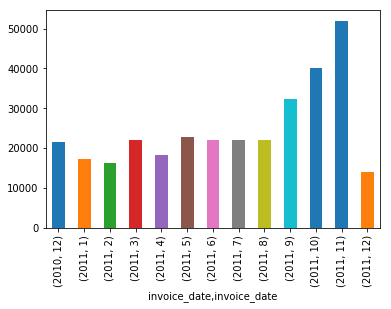

In [132]:
year = df_full.invoice_date.dt.year
month = df_full.invoice_date.dt.month
df_full.groupby([year,month]).invoice_no.agg('count').plot.bar()

### Day of week
We can also see how purchase frequency differs across week days

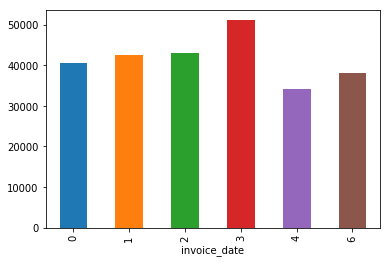

In [72]:
week = df_train.invoice_date.dt.weekday
df_train.groupby([week]).invoice_no.agg('count').plot.bar()

### Unit price

Here I took at look at the unit price. I want to clip the upper value to stop outliers from affecting the models. I played with the range and looked at how much of the data I would be leaving untouched for different limits.

In [133]:
for lim in range(0,30,5):
    print(lim,(df_train.unit_price<lim).mean())

0 0.0
5 0.867526006513
10 0.97458431638
15 0.993819322329
20 0.998197469247
25 0.998553969774


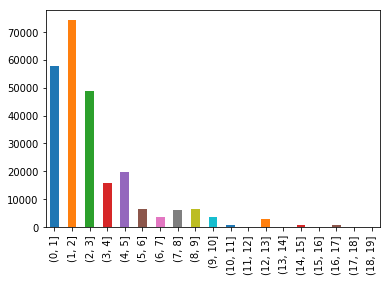

In [134]:
bins = np.arange(0,20)
s = pd.cut(df_train.unit_price[df_train.unit_price<20], bins)
s.value_counts(sort=False).plot.bar()

### Quantity

I did the same this as above for quantity. Looking for a range which includes most the values while excluding the major outliers. I'm going to keep the negative quantites for now because I'm going to use them later to construct some of the rating matrices. Once those rating matrices are created, I'll drop them.

In [135]:
s = df_full.quantity
s = s[s>=0]
for lim in range(0,200,20):
    print(lim,(s<lim).mean())

0 0.0
20 0.849918501052
40 0.950670190375
60 0.971223750218
80 0.978566568024
100 0.98396290611
120 0.988862337991
140 0.990720197496
160 0.993467424159
180 0.993733284803


In [136]:
s = df_full.quantity
s = s[s<0]
for lim in range(0,-200,-20):
    print(lim,(s>lim).mean())

0 0.0
-20 0.897687861272
-40 0.952023121387
-60 0.968641618497
-80 0.973699421965
-100 0.976589595376
-120 0.983092485549
-140 0.985838150289
-160 0.98901734104
-180 0.989595375723


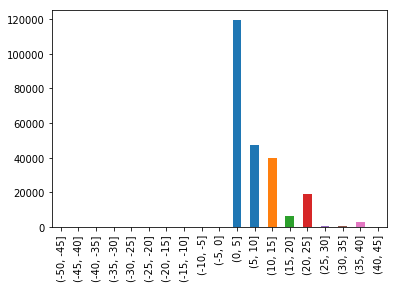

In [137]:
bins = np.arange(-50,50,5)
s = pd.cut(df_train.quantity[df_train.quantity<150], bins)
s.value_counts(sort=False).plot.bar()

## Preprocessing

Set columns type to categorical, continuous, or date:

In [147]:
cols_categorical = ['country','customer_id','invoice_no','product_id']
cols_continuous = ['unit_price','quantity']
cols_dates = ['invoice_date']

In [148]:
for name,df in dfs.items():
    for col in cols_categorical:
        df[col] = df[col].astype('category').cat.as_ordered()
    for col in cols_dates:
        df[col] = pd.to_datetime(df[col])

Clip outliers and Drop duplicates

In [149]:
for name,df in dfs.items():
    df['unit_price_clipped'] = df['unit_price'].clip_upper(20)
    df['quantity_clipped'] = df['quantity'].clip(lower=-50, upper=50)

## Create Ratings Matrix

This problem feels very similar to the Netflix competition, where you're given ratings from users, and the task is to predict ratings for users on movie which they haven't rated. The difference here is that we're not given a matrix. We have transactions and from that we want to product a matrix where the elements represent the likelihood that the customer will buy that product. 

So to learn to this ratings matrix, we first need to create a matrix based on the information we have for a limited number of customer-product pairs from the transaction history. I'll try several different ways of creating this matrix, and see which one leads to better model predictions on the test set.

In [271]:
# df = dfs['train'] # use this for training
# df = dfs['train'].append(dfs['test']) # use this for the final submission

In [272]:
rating_mat = df.groupby(['customer_id','product_id']).quantity.agg('count')
rating_mat = pd.DataFrame(rating_mat).rename(columns={'quantity':'count_total'})

In [273]:
display(rating_mat.head())
print('NaN?: ',np.any(rating_mat.isna()))

count_total
customer_id product_id             
12346       23166                 2
12347       16008                 1
            17021                 1
            20665                 1
            20719                 4

NaN?:  False


In [274]:
col = 'quantity_clipped'
# col = 'quantity'

In [275]:
df_pos = df[df[col] >= 0]
df_neg = df[df[col] < 0]

In [276]:
rating_mat['count_pos'] = df_pos.groupby(['customer_id','product_id'])[col].agg('count')
rating_mat['count_pos'] = rating_mat['count_pos'].fillna(0)

In [277]:
rating_mat['count_neg'] = df_neg.groupby(['customer_id','product_id'])[col].agg('count')
rating_mat['count_neg'] = rating_mat['count_neg'].fillna(0)

In [278]:
rating_mat['count_ratio'] = rating_mat.count_pos / (rating_mat.count_neg+1)

In [279]:
rating_mat['sum_pos'] = df_pos.groupby(['customer_id','product_id'])[col].agg('sum')
rating_mat['sum_pos'] = rating_mat['sum_pos'].fillna(0)

In [280]:
rating_mat['sum_neg'] = df_neg.groupby(['customer_id','product_id'])[col].agg('sum')
rating_mat['sum_neg'] = rating_mat['sum_neg'].fillna(0)

In [281]:
rating_mat['sum_ratio'] = rating_mat.sum_pos / (np.abs(rating_mat.sum_neg)+1)

In [282]:
unit_price = df.groupby(['product_id']).unit_price.agg(['mean']).rename(columns={'mean':'unit_price'})
rating_mat = pd.merge(rating_mat, unit_price, left_index=True, right_index=True)
rating_mat['sum_pos_cost'] = rating_mat.sum_pos*rating_mat.unit_price
rating_mat['sum_ratio_cost'] = rating_mat.sum_ratio*rating_mat.unit_price

In [283]:
rating_mat = rating_mat[['count_pos','count_ratio',
                           'sum_pos','sum_ratio',
                           'sum_pos_cost','sum_ratio_cost']]
rating_mat = rating_mat / rating_mat.max(axis=0)

Now that the rating matrices are created, we can drop the records of returned items.

In [163]:
df_train = df_train[df_train.quantity > 0]
df_test = df_test[df_test.quantity > 0]
df_test.shape[0]/df_train.shape[0]

0.25157955198161974

In [284]:
rating_mat.head()

count_pos  count_ratio   sum_pos  sum_ratio  \
customer_id product_id                                                
12346       23166        0.015625       0.0125  0.036765   0.000721   
12347       16008        0.015625       0.0250  0.017647   0.017647   
            17021        0.015625       0.0250  0.026471   0.026471   
            20665        0.015625       0.0250  0.004412   0.004412   
            20719        0.062500       0.1000  0.029412   0.029412   

                        sum_pos_cost  sum_ratio_cost  
customer_id product_id                                
12346       23166           0.007134        0.000140  
12347       16008           0.000388        0.000388  
            17021           0.001248        0.001248  
            20665           0.002072        0.002072  
            20719           0.003926        0.003926

## Prepare Test Set

Because we've split the dataset, there may be some customers or products that we never see during training which appear in the test set. In the real world, this will happen and we can do things like recommend the most popular products to new customers. In this case, I'm just using the test set to compare how well the models have captured how customers and products interact, so I'll drop all the transactions in the test set which are by customers or for products we've never seen in training.

In [166]:
df_test = df_test[df_test.customer_id.isin(df_train.customer_id)]
df_test = df_test[df_test.product_id.isin(df_train.product_id)]

Confirm that I didn't mess something up: check customers and products in the test set are in the training set

In [168]:
df_test.customer_id.isin(df_train.customer_id).mean(), df_test.product_id.isin(df_train.product_id).mean()

(1.0, 1.0)

In [169]:
df_test.shape[0]/df_train.shape[0]

0.20807304561389608

### Create Test Instances and Labels

In [170]:
test_instances = df_test[['invoice_no','customer_id']].drop_duplicates()
test_instances.set_index('invoice_no', inplace=True)
test_instances.sort_index(inplace=True)
test_instances.head(3)

,customer_id
invoice_no,
573921,16352
573922,14032
573923,17965


In [171]:
test_labels = df_test.groupby(['invoice_no','product_id']).quantity.count().unstack()
test_labels.sort_index(inplace=True)
test_labels.fillna(0, inplace=True)
test_labels[test_labels > 1] = 1 #in case a product shows up on separate lines on an invoice
test_labels.head(3)

product_id,10080,10120,10125,10135,11001,15030,15034,15036,15039,15044A,...,90214E,90214H,90214J,90214K,90214L,90214M,90214N,90214P,90214R,90214S
invoice_no,,,,,,,,,,,,,,,,,,,,,
573921,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
573922,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
573923,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Baseline

Create some baseline results to compare to. For each of the rating matrices above, I fill the missing elements of the matrix with the global, product, or customer average rating.

In [252]:
filled_global_avg = {}
for name, col in rating_mat.items():
    mat = col.unstack()
    global_mean = mat.mean().mean()
    mat = mat.fillna(global_mean)
    filled_global_avg[name] = mat

In [254]:
filled_product_mean = {}
for name, col in rating_mat.items():
    mat = col.unstack()
    mat = mat.apply(lambda x: x.fillna(x.mean()), axis=0)
    filled_product_mean[name] = mat

In [256]:
filled_customer_mean = {}
for name, col in rating_mat.items():
    mat = col.unstack()
    for cust_name, cust_row in mat.iterrows():
        mat.loc[cust_name] = cust_row.fillna(cust_row.mean())
    filled_customer_mean[name] = mat

### Fill missing ratings with global average

In [258]:
mean_auc = {}
for mat_name, mat in filled_global_avg.items():
    test_preds = pd.merge(test_instances, mat, left_on='customer_id', right_index=True)
    test_preds = test_preds[test_labels.columns]
    mean_auc[mat_name] = multiclass_roc(test_labels.values, test_preds.values)

In [259]:
for rating_name, auroc in mean_auc.items():
    print("{0}: {1}".format(rating_name,auroc))

count_pos: 0.5000741241520592
count_ratio: 0.5001278450590868
sum_pos: 0.5015400207989932
sum_ratio: 0.5015001051580614
sum_pos_cost: 0.5016272851973534
sum_ratio_cost: 0.5015238439356388


### Fill missing ratings with product mean

In [262]:
mean_auc = {}
for mat_name, mat in filled_product_mean.items():
    test_preds = pd.merge(test_instances, mat, left_on='customer_id', right_index=True)
    test_preds = test_preds[test_labels.columns]
    mean_auc[mat_name] = multiclass_roc(test_labels.values, test_preds.values)

In [263]:
for rating_name, auroc in mean_auc.items():
    print("{0}: {1}".format(rating_name,auroc))

count_pos: 0.5005046030132948
count_ratio: 0.500675926002597
sum_pos: 0.5007637775291999
sum_ratio: 0.5008318411541303
sum_pos_cost: 0.5007716417917594
sum_ratio_cost: 0.5008366221336447


### Fill missing values with customer_mean

In [264]:
mean_auc = {}
for mat_name, mat in filled_customer_mean.items():
    test_preds = pd.merge(test_instances, mat, left_on='customer_id', right_index=True)
    test_preds = test_preds[test_labels.columns]
    mean_auc[mat_name] = multiclass_roc(test_labels.values, test_preds.values)

In [265]:
for rating_name, auroc in mean_auc.items():
    print("{0}: {1}".format(rating_name,auroc))

count_pos: 0.5086777939185589
count_ratio: 0.5076011391428056
sum_pos: 0.5084499309629407
sum_ratio: 0.5062382906408531
sum_pos_cost: 0.5088789581899674
sum_ratio_cost: 0.5060041732345437


## Collaborative Filtering and Matrix Factorization

**Collaborative Filtering**<br>
The first technique I'll try for predicting the missing values in the rating matrix is collaborative filtering. In the case of customer collaborative filtering, the customer ratings are used as a vector representation of the customer. When two customers have vector representations which point in a similar direction, we assume that these customers have similar preferences for products. For ratings which don't exist in the table, we can average the ratings from some number of similar customers (weighted by how similar they are). The same is done for product collaborative filtering but with product vectors instead of customer.

**SVD**<br>
The next technique is matrix factorization, specifically svd. SVD starts by randomly initializing customer and product vectors. A customers rating for a product is estimated by taking the dot product of the customer vector and product vector. By trying to predict the ratings which we have in the training set, and using SGD to improve the customer and product vectors, we eventually have a set of customer and product vectors that can be used to predict any customer-product pair. SVD++ is another variation I try which takes into account implicit feedback from the customers by assuming that products that are purchased more often will be rated higher.

In [172]:
from surprise import KNNWithMeans, SVD, SVDpp 
from surprise import Dataset, Reader
from surprise.model_selection import GridSearchCV
from surprise.model_selection import train_test_split

### Models and Dataset

Prepare the collection of rating matrices and models to test

In [239]:
model_names = ['product_collab', 'customer_collab','svd','svd_pp']

In [240]:
product_collab = KNNWithMeans(k=5, sim_options={'user_based':True})
customer_collab = KNNWithMeans(k=5, sim_options={'user_based':False})
svd = SVD()
svd_pp = SVDpp()
models = [product_collab, customer_collab, svd, svd_pp]

In [290]:
reader = Reader(rating_scale=(0,1))
datasets = {}
for name,col in rating_mat.items():
    data = col.reset_index()
    data = Dataset.load_from_df(data, reader)
    datasets[name] = data

### Training

Train each model on each rating matrix.

In [247]:
%%time
models_trained = {}
for ds, dataset in datasets.items():
    models_trained[ds] = {}
    for m, model in zip(model_names, models):        
        model.fit(dataset.build_full_trainset())
        models_trained[ds][m] = model

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


KeyboardInterrupt: 

### Predict

Generate the customer-product pairs that appear in the test set with each model. Measure the performance of the model on the test yet using AUROC.

In [188]:
def format_surprise_preds(preds):
    # Convert surprise predictions to dataframe
    np_preds = np.array(preds)[:,[0,1,3]]
    df_preds = pd.DataFrame(np_preds, columns=['customer_id','product_id','rating'])
    preds = df_preds.set_index(['customer_id','product_id']).unstack()
    preds.columns = preds.columns.droplevel(0)
    return preds

In [189]:
c,p = df_test.customer_id.cat.categories, df_test.product_id.cat.categories
index = pd.MultiIndex.from_product([c,p], names=['customer_id','product_id'])
all_test_pairs = pd.DataFrame([],index).reset_index()
all_test_pairs['rating'] = np.nan

In [ ]:
models_auroc = {}
for rating_mat_name, models in models_trained.items():
    models_auroc[rating_mat_name] = {}
    for model_name, model in models.items():
        # Make and format predictions
        preds = model.test(all_test_pairs.values)
        preds = format_surprise_preds(preds)
        # Line up predictions with test invoices
        test_preds = pd.merge(test_instances, preds, left_on='customer_id', right_index=True)
        test_preds = test_preds.drop(columns=['customer_id'])
        test_preds = test_preds[test_labels.columns]
        # Calculate mean auroc
        mean_auc = multiclass_roc(test_labels.values, test_preds.values)
        models_auroc[rating_mat_name][model_name] = mean_auc

## SVD++

SVD++ on the "count_pos" rating matrix had the best performance. I'll train this model on the full dataset and use it to create the full MxN rating matrix. 

In [293]:
dataset = datasets['count_pos']

In [294]:
svd_pp.fit(dataset.build_full_trainset())

In [314]:
c,u = df_raw.customer_id.unique(), df_raw.product_id.unique()
index = pd.MultiIndex.from_product([c,u], names=['customer_id','product_id'])
all_pairs = pd.DataFrame([], index=index).reset_index()
all_pairs['rating']=0 

In [332]:
# Make and format predictions
preds = svd_pp.test(all_pairs.values)
preds = format_surprise_preds(preds)

KeyboardInterrupt: 

## Neural Network

I wasn't able to finish testing this model, so I didn't use it to produce the results for this submission. Below I describe the motivation for the network architecture and explain some of the design decisions. The model is coded up as well.

#### Problems with above method

1) Need to create a rating matrix<br>
Something that I don't like about the techniques above is the fact that we need to make a decision about how to represent the rating matrix. We side step that a bit by trying several different representations but there's still a sense that we're not directly learning user preferences.

2) Information in the dataset not used<br>
None of the above models use the date, price, or country information from the training data. 
I can imagine that there are certain purchases that have more to do with the time of year than a customers preferences. For example, the purchase of a hand warmer is probably best explained by the time of year rather than a customers preference for hand warmers.

#### Learning task

What I want is a model which can take in each invoice with all the information associated with it, and predict which products that customer is likely to buy. The input and output come directly from the training data, no need to create a rating matrix.

By inputting the other information available, we can probably make better predictions. But the goal of the project is to create a matrix of customer-product ratings. Each rating represents the probability that the customer will purchase this product, irrespective of the other information available in the transactions.

#### Model

What I proposed is to create a neural network that has two intermediate outputs: 
1) given a product and customer, predict the probability that the customer will purchase that product
2) given a product and all the other information available, predict the probability that the customer will purchase that product.

The final output will be a combination of these two intermediate outputs. This final output is what will be compared to the labeled training data (did the customer purchase this product or not).

The hope is that the influences on the purchase that don't have to do with a customers preference for that product will be encoded in part of the network which produces the second intermediate output. For example: a purchase of a handwarmer in december isn't significant evidence that a customer prefers handwarmers if everyone is purchasing handwarmers in december.

#### Handling imbalanced dataset

In the learning task I've defined, we have an the problem of an imbalanced dataset. There are two ways of looking at this. One way is that we only have positive examples of purchases. Every row in our transaction history is a positive example of a purchase of that item.

Another way to look at this is that we have way too many negative examples. Each time a customer buys a collection of products, they're NOT buying every other product. Thought of this way, there are way to many negative examples.

I propose that, for every invoice, we generate as many negative examples as there are positive purchases. So if a customer purchases two items, we randomly select two other items which were not purchases as examples.

### Features and Preprocessing

In [39]:
from fastai.column_data import ColumnarModelData
from fastai.structured import add_datepart 
from fastai.structured import proc_df, apply_cats

In [40]:
nn_train = df_train.copy().sort_index()
nn_test = df_test.copy().sort_index()

In [41]:
add_datepart(nn_train, 'invoice_date', drop=False)
add_datepart(nn_test, 'invoice_date', drop=False)

In [42]:
cols_categorical = ['customer_id', 'product_id', 'country',
                    'invoice_Year', 'invoice_Month','invoice_Week', 
                    'invoice_Day', 'invoice_Dayofweek', 'invoice_Dayofyear',
                    'invoice_Is_month_end', 'invoice_Is_month_start',
                    'invoice_Is_quarter_end', 'invoice_Is_quarter_start',
                    'invoice_Is_year_end', 'invoice_Is_year_start', 'invoice_Elapsed']

In [43]:
nn_train = nn_train[cols_categorical]
nn_test = nn_test[cols_categorical]

In [44]:
for col in cols_categorical:
    nn_train[col] = nn_train[col].astype('category').cat.as_ordered()

numericalize categories

In [45]:
nn_train_coded = nn_train.copy()
for col in cols_categorical:
    nn_train_coded[col] = nn_train_coded[col].cat.codes+1

### Model

I used the fastai library to implement the model. 

In [46]:
import torch
import torch.nn.functional as F
from torch import nn
from torch.nn.init import kaiming_uniform, kaiming_normal
from fastai.column_data import ColumnarModelData
from fastai.learner import fit, optim

Prepare data

In [48]:
train_size = int(train_ratio*len(nn_train_coded))
val_idxs = np.arange(train_size,len(nn_train_coded))

In [49]:
labels = np.ones(len(nn_train_coded))
md = ColumnarModelData.from_data_frame(%pwd, val_idxs, nn_train_coded, labels, cat_flds=cols_categorical, 
                                       bs=32)

Define embedding sizes 

In [50]:
def define_embed_sizes(categories, customer, product):
    embed_sizes = {name:(size, min(50,(size+1)//2)) 
                   for name,size in categories.items()}
    customer_embed_size = embed_sizes.pop(customer)
    product_embed_size = embed_sizes.pop(product)
    other_embed_sizes = list(embed_sizes.values())
    return customer_embed_size, product_embed_size, other_embed_sizes

In [58]:
category_sizes = {col: len(nn_train[col].cat.categories)+1 for col in cols_categorical}
embed_sizes = define_embed_sizes(category_sizes, 'customer_id', 'product_id')
customer_embed_size, product_embed_size, other_embed_sizes = embed_sizes

In [55]:
def embed_init(num_cats, emb_size):
    embed = nn.Embedding(num_cats, emb_size)
    x = embed.weight.data
    sc = 2/(x.size(1)+1)
    x.uniform_(-sc,sc)
    return embed

In [60]:
class MixedInputModel(nn.Module):
    def __init__(self, customer_embed_size, product_embed_size, other_embed_sizes, 
                 lin_sizes1, lin_sizes2, emb_drop, drops, bias_average):
        super().__init__()
        # Initialize emeddings
        self.embed_product = embed_init(*product_embed_size)
        self.embed_customer = embed_init(*customer_embed_size)
        self.embed_other = nn.ModuleList([embed_init(num_cats,embed_size) 
                                          for num_cats, embed_size in other_embed_sizes])
        self.bias_product = embed_init(product_embed_size[0],1)
        self.bias_customer = embed_init(customer_embed_size[0],1)
        self.bias_average = torch.FloatTensor([[bias_average]]) 
        # Calculate the total length of the concatenated embeddings
        embeds1 = [self.embed_product, self.embed_customer]
        embeds2 = [self.embed_product, *self.embed_other]
        len_embeds1 = sum(embed.embedding_dim for embed in embeds1)
        len_embeds2 = sum(embed.embedding_dim for embed in embeds2)
        # Define the input size to the first linear layer
        lin_sizes1 = [len_embeds1] + lin_sizes1
        lin_sizes2 = [len_embeds2] + lin_sizes2
        # Create linear layers
        self.lins1 = nn.ModuleList([nn.Linear(lin_sizes1[j],lin_sizes1[j+1])
                                    for j in range(len(lin_sizes1)-1)])
        self.lins2 = nn.ModuleList([nn.Linear(lin_sizes2[j],lin_sizes2[j+1])
                                    for j in range(len(lin_sizes2)-1)])
        for lin in self.lins1: nn.init.kaiming_normal_(lin.weight.data)
        for lin in self.lins2: nn.init.kaiming_normal_(lin.weight.data)
        # Create dropout layers
        self.emb_drop = nn.Dropout(emb_drop)
        self.drop = nn.Dropout(drop)
        
    def forward(self, x_cat, x_cont):
        x_customer, x_product, x_other = x_cat[:,0], x_cat[:,1], x_cat[:,2:]
#         import pdb; pdb.set_trace()
        # P(customer|product)
        embeds = [self.embed_product(x_product), self.embed_customer(x_customer)]
        x1 = torch.cat(embeds, 1)
        x1 = self.emb_drop(x1)
        x1 = self.lins1[0](x1)
        x1 = F.relu(x1)
        x1 = self.drop(x1)
        # P(other|product)
        embeds = [self.embed_product(x_product)]
        embeds += [embed(x_other[:,i]) for i,embed in enumerate(self.embed_other)]
        x2 = torch.cat(embeds, 1)
        x2 = self.emb_drop(x2)
        x2 = self.lins2[0](x2)
        x2 = F.relu(x2)
        x2 = self.drop(x2)
        # Output
        bp = self.bias_product(x_product)
        bc = self.bias_customer(x_customer)
        mu = self.bias_average
        return F.sigmoid(mu + bp + bc + x1 + x2)
    
    def predict_rating(self, x_customer, x_product):
        embeds = [self.embed_product(x_product), self.embed_customer(x_customer)]
        x1 = torch.cat(embeds, 1)
        x1 = self.emb_drop(x1)
        x1 = self.lins1[0](x1)
        x1 = F.relu(x1)
        x1 = self.drop(x1)
        # Output
        bp = self.bias_product(x_product)
        bc = self.bias_customer(x_customer)
        mu = self.bias_average
        return F.sigmoid(mu + bp + bc + x1)

In [ ]:
model = MixedInputModel(customer_embed_size, product_embed_size, other_embed_sizes,
                        len(cols_continuous)-1, 0.04, 1, [1000,500], [1000,500], [0.001,0.01])

### Define and Train model

In [61]:
nb_cont = 0
output_size = 1 
lin_sizes1 = [1] #[1000,500] 
lin_sizes2 = [1] #[1000,500]
emb_drop = 0.04
drop = 0.001 #[0.001,0.01]
model = MixedInputModel(customer_embed_size, product_embed_size, other_embed_sizes, 
                        lin_sizes1, lin_sizes2, emb_drop, drop, 0.0009)

In [64]:
wd=2e-4
opt = optim.SGD(model.parameters(), 1e-2, weight_decay=wd, momentum=0.9)

In [65]:
fit(model, md, 3, opt, F.mse_loss)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

  0%|          | 1/6242 [00:00<1:32:47,  1.12it/s, loss=tensor(0.2777)]

/home/taylor/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/model.py:49: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  return raw_loss.data[0]


  1%|          | 58/6242 [00:02<04:34, 22.49it/s, loss=tensor(1.00000e-02 *
  1%|          | 58/6242 [00:02<04:37, 22.28it/s, loss=tensor(1.00000e-02 *
  1%|          | 58/6242 [00:02<04:40, 22.06it/s, loss=tensor(1.00000e-02 *
  1%|          | 62/6242 [00:02<04:22, 23.53it/s, loss=tensor(1.00000e-02 *
  1%|          | 62/6242 [00:02<04:25, 23.30it/s, loss=tensor(1.00000e-02 *
  1%|          | 62/6242 [00:02<04:27, 23.15it/s, loss=tensor(1.00000e-02 *
  1%|          | 62/6242 [00:02<04:29, 22.95it/s, loss=tensor(1.00000e-02 *
  1%|          | 62/6242 [00:02<04:31, 22.75it/s, loss=tensor(1.00000e-02 *
  1%|          | 62/6242 [00:02<04:35, 22.40it/s, loss=tensor(1.00000e-02 *
  1%|          | 67/6242 [00:02<04:15, 24.17it/s, loss=tensor(1.00000e-02 *
  1%|          | 67/6242 [00:02<04:17, 24.01it/s, loss=tensor(1.00000e-02 *
  1%|          | 67/6242 [00:02<04:20, 23.70it/s, loss=tensor(1.00000e-02 *
  1%|          | 67/6242 [00:02<04:22, 23.55it/s, loss=tensor(1.00000e-02 *
  1%|       

  2%|▏         | 146/6242 [00:04<03:25, 29.66it/s, loss=tensor(1.00000e-02 *
  2%|▏         | 146/6242 [00:04<03:26, 29.48it/s, loss=tensor(1.00000e-02 *
  2%|▏         | 146/6242 [00:04<03:27, 29.35it/s, loss=tensor(1.00000e-02 *
  2%|▏         | 146/6242 [00:05<03:28, 29.19it/s, loss=tensor(1.00000e-02 *
  2%|▏         | 150/6242 [00:05<03:23, 29.97it/s, loss=tensor(1.00000e-02 *
  2%|▏         | 150/6242 [00:05<03:24, 29.81it/s, loss=tensor(1.00000e-02 *
  2%|▏         | 150/6242 [00:05<03:25, 29.69it/s, loss=tensor(1.00000e-02 *
  2%|▏         | 150/6242 [00:05<03:26, 29.56it/s, loss=tensor(1.00000e-02 *
  2%|▏         | 150/6242 [00:05<03:27, 29.41it/s, loss=tensor(1.00000e-02 *
  2%|▏         | 150/6242 [00:05<03:28, 29.27it/s, loss=tensor(1.00000e-02 *
  2%|▏         | 155/6242 [00:05<03:21, 30.22it/s, loss=tensor(1.00000e-02 *
  2%|▏         | 155/6242 [00:05<03:22, 30.05it/s, loss=tensor(1.00000e-02 *
  2%|▏         | 155/6242 [00:05<03:23, 29.86it/s, loss=tensor(1.00000e-02 *

  4%|▎         | 233/6242 [00:07<03:00, 33.25it/s, loss=tensor(1.00000e-03 *
  4%|▎         | 233/6242 [00:07<03:01, 33.17it/s, loss=tensor(1.00000e-03 *
  4%|▎         | 233/6242 [00:07<03:01, 33.09it/s, loss=tensor(1.00000e-03 *
  4%|▎         | 233/6242 [00:07<03:02, 32.86it/s, loss=tensor(1.00000e-03 *
  4%|▍         | 239/6242 [00:07<02:58, 33.68it/s, loss=tensor(1.00000e-03 *
  4%|▍         | 239/6242 [00:07<02:58, 33.61it/s, loss=tensor(1.00000e-03 *
  4%|▍         | 239/6242 [00:07<02:59, 33.53it/s, loss=tensor(1.00000e-03 *
  4%|▍         | 239/6242 [00:07<02:59, 33.44it/s, loss=tensor(1.00000e-03 *
  4%|▍         | 239/6242 [00:07<02:59, 33.36it/s, loss=tensor(1.00000e-03 *
  4%|▍         | 239/6242 [00:07<03:00, 33.28it/s, loss=tensor(1.00000e-03 *
  4%|▍         | 239/6242 [00:07<03:00, 33.19it/s, loss=tensor(1.00000e-03 *
  4%|▍         | 245/6242 [00:07<02:56, 34.01it/s, loss=tensor(1.00000e-03 *
  4%|▍         | 245/6242 [00:07<02:56, 33.94it/s, loss=tensor(1.00000e-03 *

  5%|▌         | 323/6242 [00:08<02:42, 36.47it/s, loss=tensor(1.00000e-03 *
  5%|▌         | 323/6242 [00:08<02:42, 36.41it/s, loss=tensor(1.00000e-03 *
  5%|▌         | 323/6242 [00:08<02:42, 36.34it/s, loss=tensor(1.00000e-03 *
  5%|▌         | 329/6242 [00:08<02:39, 36.99it/s, loss=tensor(1.00000e-03 *
  5%|▌         | 329/6242 [00:08<02:40, 36.90it/s, loss=tensor(1.00000e-03 *
  5%|▌         | 329/6242 [00:08<02:40, 36.83it/s, loss=tensor(1.00000e-03 *
  5%|▌         | 329/6242 [00:08<02:40, 36.76it/s, loss=tensor(1.00000e-03 *
  5%|▌         | 329/6242 [00:08<02:41, 36.70it/s, loss=tensor(1.00000e-03 *
  5%|▌         | 329/6242 [00:08<02:41, 36.64it/s, loss=tensor(1.00000e-03 *
  5%|▌         | 329/6242 [00:08<02:41, 36.56it/s, loss=tensor(1.00000e-03 *
  5%|▌         | 335/6242 [00:09<02:38, 37.20it/s, loss=tensor(1.00000e-03 *
  5%|▌         | 335/6242 [00:09<02:39, 37.12it/s, loss=tensor(1.00000e-03 *
  5%|▌         | 335/6242 [00:09<02:39, 37.04it/s, loss=tensor(1.00000e-03 *

  7%|▋         | 416/6242 [00:10<02:29, 38.95it/s, loss=tensor(1.00000e-03 *
  7%|▋         | 416/6242 [00:10<02:29, 38.89it/s, loss=tensor(1.00000e-03 *
  7%|▋         | 416/6242 [00:10<02:30, 38.82it/s, loss=tensor(1.00000e-03 *
  7%|▋         | 416/6242 [00:10<02:30, 38.76it/s, loss=tensor(1.00000e-03 *
  7%|▋         | 416/6242 [00:10<02:30, 38.68it/s, loss=tensor(1.00000e-03 *
  7%|▋         | 422/6242 [00:10<02:28, 39.23it/s, loss=tensor(1.00000e-03 *
  7%|▋         | 422/6242 [00:10<02:28, 39.17it/s, loss=tensor(1.00000e-03 *
  7%|▋         | 422/6242 [00:10<02:28, 39.11it/s, loss=tensor(1.00000e-03 *
  7%|▋         | 422/6242 [00:10<02:29, 39.05it/s, loss=tensor(1.00000e-03 *
  7%|▋         | 422/6242 [00:10<02:29, 38.97it/s, loss=tensor(1.00000e-03 *
  7%|▋         | 422/6242 [00:10<02:29, 38.91it/s, loss=tensor(1.00000e-03 *
  7%|▋         | 422/6242 [00:10<02:29, 38.85it/s, loss=tensor(1.00000e-03 *
  7%|▋         | 428/6242 [00:10<02:27, 39.39it/s, loss=tensor(1.00000e-03 *

  8%|▊         | 506/6242 [00:12<02:20, 40.72it/s, loss=tensor(1.00000e-03 *
  8%|▊         | 506/6242 [00:12<02:21, 40.67it/s, loss=tensor(1.00000e-03 *
  8%|▊         | 506/6242 [00:12<02:21, 40.62it/s, loss=tensor(1.00000e-03 *
  8%|▊         | 512/6242 [00:12<02:19, 41.08it/s, loss=tensor(1.00000e-03 *
  8%|▊         | 512/6242 [00:12<02:19, 41.03it/s, loss=tensor(1.00000e-03 *
  8%|▊         | 512/6242 [00:12<02:19, 40.97it/s, loss=tensor(1.00000e-03 *
  8%|▊         | 512/6242 [00:12<02:20, 40.91it/s, loss=tensor(1.00000e-03 *
  8%|▊         | 512/6242 [00:12<02:20, 40.85it/s, loss=tensor(1.00000e-03 *
  8%|▊         | 512/6242 [00:12<02:20, 40.80it/s, loss=tensor(1.00000e-03 *
  8%|▊         | 512/6242 [00:12<02:20, 40.74it/s, loss=tensor(1.00000e-03 *
  8%|▊         | 518/6242 [00:12<02:18, 41.20it/s, loss=tensor(1.00000e-03 *
  8%|▊         | 518/6242 [00:12<02:19, 41.13it/s, loss=tensor(1.00000e-03 *
  8%|▊         | 518/6242 [00:12<02:19, 41.07it/s, loss=tensor(1.00000e-03 *

 10%|▉         | 596/6242 [00:14<02:13, 42.15it/s, loss=tensor(1.00000e-03 *
 10%|▉         | 602/6242 [00:14<02:12, 42.56it/s, loss=tensor(1.00000e-03 *
 10%|▉         | 602/6242 [00:14<02:12, 42.51it/s, loss=tensor(1.00000e-03 *
 10%|▉         | 602/6242 [00:14<02:12, 42.46it/s, loss=tensor(1.00000e-03 *
 10%|▉         | 602/6242 [00:14<02:13, 42.39it/s, loss=tensor(1.00000e-03 *
 10%|▉         | 602/6242 [00:14<02:13, 42.35it/s, loss=tensor(1.00000e-03 *
 10%|▉         | 602/6242 [00:14<02:13, 42.30it/s, loss=tensor(1.00000e-03 *
 10%|▉         | 602/6242 [00:14<02:13, 42.26it/s, loss=tensor(1.00000e-03 *
 10%|▉         | 608/6242 [00:14<02:12, 42.66it/s, loss=tensor(1.00000e-03 *
 10%|▉         | 608/6242 [00:14<02:12, 42.62it/s, loss=tensor(1.00000e-03 *
 10%|▉         | 608/6242 [00:14<02:12, 42.55it/s, loss=tensor(1.00000e-03 *
 10%|▉         | 608/6242 [00:14<02:12, 42.50it/s, loss=tensor(1.00000e-03 *
 10%|▉         | 608/6242 [00:14<02:12, 42.45it/s, loss=tensor(1.00000e-03 *

 11%|█         | 692/6242 [00:15<02:07, 43.67it/s, loss=tensor(1.00000e-04 *
 11%|█         | 692/6242 [00:15<02:07, 43.63it/s, loss=tensor(1.00000e-04 *
 11%|█         | 692/6242 [00:15<02:07, 43.58it/s, loss=tensor(1.00000e-04 *
 11%|█         | 692/6242 [00:15<02:07, 43.53it/s, loss=tensor(1.00000e-04 *
 11%|█         | 692/6242 [00:15<02:07, 43.48it/s, loss=tensor(1.00000e-04 *
 11%|█         | 692/6242 [00:15<02:07, 43.44it/s, loss=tensor(1.00000e-04 *
 11%|█         | 698/6242 [00:15<02:06, 43.80it/s, loss=tensor(1.00000e-04 *
 11%|█         | 698/6242 [00:15<02:06, 43.76it/s, loss=tensor(1.00000e-04 *
 11%|█         | 698/6242 [00:15<02:06, 43.71it/s, loss=tensor(1.00000e-04 *
 11%|█         | 698/6242 [00:15<02:06, 43.67it/s, loss=tensor(1.00000e-04 *
 11%|█         | 698/6242 [00:16<02:07, 43.61it/s, loss=tensor(1.00000e-04 *
 11%|█         | 698/6242 [00:16<02:07, 43.56it/s, loss=tensor(1.00000e-04 *
 11%|█         | 698/6242 [00:16<02:07, 43.50it/s, loss=tensor(1.00000e-04 *

 13%|█▎        | 782/6242 [00:17<02:02, 44.50it/s, loss=tensor(1.00000e-04 *
 13%|█▎        | 782/6242 [00:17<02:02, 44.46it/s, loss=tensor(1.00000e-04 *
 13%|█▎        | 782/6242 [00:17<02:02, 44.41it/s, loss=tensor(1.00000e-04 *
 13%|█▎        | 782/6242 [00:17<02:03, 44.37it/s, loss=tensor(1.00000e-04 *
 13%|█▎        | 788/6242 [00:17<02:02, 44.70it/s, loss=tensor(1.00000e-04 *
 13%|█▎        | 788/6242 [00:17<02:02, 44.66it/s, loss=tensor(1.00000e-04 *
 13%|█▎        | 788/6242 [00:17<02:02, 44.60it/s, loss=tensor(1.00000e-04 *
 13%|█▎        | 788/6242 [00:17<02:02, 44.56it/s, loss=tensor(1.00000e-04 *
 13%|█▎        | 788/6242 [00:17<02:02, 44.52it/s, loss=tensor(1.00000e-04 *
 13%|█▎        | 788/6242 [00:17<02:02, 44.49it/s, loss=tensor(1.00000e-04 *
 13%|█▎        | 788/6242 [00:17<02:02, 44.36it/s, loss=tensor(1.00000e-04 *
 13%|█▎        | 794/6242 [00:17<02:01, 44.69it/s, loss=tensor(1.00000e-04 *
 13%|█▎        | 794/6242 [00:17<02:02, 44.65it/s, loss=tensor(1.00000e-04 *

 14%|█▍        | 874/6242 [00:19<01:58, 45.24it/s, loss=tensor(1.00000e-04 *
 14%|█▍        | 874/6242 [00:19<01:58, 45.20it/s, loss=tensor(1.00000e-04 *
 14%|█▍        | 874/6242 [00:19<01:58, 45.17it/s, loss=tensor(1.00000e-04 *
 14%|█▍        | 874/6242 [00:19<01:58, 45.13it/s, loss=tensor(1.00000e-04 *
 14%|█▍        | 880/6242 [00:19<01:58, 45.43it/s, loss=tensor(1.00000e-04 *
 14%|█▍        | 880/6242 [00:19<01:58, 45.40it/s, loss=tensor(1.00000e-04 *
 14%|█▍        | 880/6242 [00:19<01:58, 45.36it/s, loss=tensor(1.00000e-04 *
 14%|█▍        | 880/6242 [00:19<01:58, 45.32it/s, loss=tensor(1.00000e-04 *
 14%|█▍        | 880/6242 [00:19<01:58, 45.28it/s, loss=tensor(1.00000e-04 *
 14%|█▍        | 880/6242 [00:19<01:58, 45.24it/s, loss=tensor(1.00000e-04 *
 14%|█▍        | 880/6242 [00:19<01:58, 45.20it/s, loss=tensor(1.00000e-04 *
 14%|█▍        | 886/6242 [00:19<01:57, 45.50it/s, loss=tensor(1.00000e-04 *
 14%|█▍        | 886/6242 [00:19<01:57, 45.46it/s, loss=tensor(1.00000e-04 *

 15%|█▌        | 964/6242 [00:21<01:55, 45.86it/s, loss=tensor(1.00000e-04 *
 15%|█▌        | 964/6242 [00:21<01:55, 45.82it/s, loss=tensor(1.00000e-04 *
 16%|█▌        | 970/6242 [00:21<01:54, 46.09it/s, loss=tensor(1.00000e-04 *
 16%|█▌        | 970/6242 [00:21<01:54, 46.05it/s, loss=tensor(1.00000e-04 *
 16%|█▌        | 970/6242 [00:21<01:54, 46.02it/s, loss=tensor(1.00000e-04 *
 16%|█▌        | 970/6242 [00:21<01:54, 45.98it/s, loss=tensor(1.00000e-04 *
 16%|█▌        | 970/6242 [00:21<01:54, 45.93it/s, loss=tensor(1.00000e-04 *
 16%|█▌        | 970/6242 [00:21<01:54, 45.90it/s, loss=tensor(1.00000e-04 *
 16%|█▌        | 970/6242 [00:21<01:54, 45.86it/s, loss=tensor(1.00000e-04 *
 16%|█▌        | 976/6242 [00:21<01:54, 46.14it/s, loss=tensor(1.00000e-04 *
 16%|█▌        | 976/6242 [00:21<01:54, 46.11it/s, loss=tensor(1.00000e-04 *
 16%|█▌        | 976/6242 [00:21<01:54, 46.07it/s, loss=tensor(1.00000e-04 *
 16%|█▌        | 976/6242 [00:21<01:54, 46.02it/s, loss=tensor(1.00000e-04 *

 17%|█▋        | 1054/6242 [00:22<01:51, 46.42it/s, loss=tensor(1.00000e-04 *
 17%|█▋        | 1060/6242 [00:22<01:51, 46.68it/s, loss=tensor(1.00000e-04 *
 17%|█▋        | 1060/6242 [00:22<01:51, 46.64it/s, loss=tensor(1.00000e-04 *
 17%|█▋        | 1060/6242 [00:22<01:51, 46.61it/s, loss=tensor(1.00000e-04 *
 17%|█▋        | 1060/6242 [00:22<01:51, 46.57it/s, loss=tensor(1.00000e-04 *
 17%|█▋        | 1060/6242 [00:22<01:51, 46.53it/s, loss=tensor(1.00000e-04 *
 17%|█▋        | 1060/6242 [00:22<01:51, 46.50it/s, loss=tensor(1.00000e-04 *
 17%|█▋        | 1060/6242 [00:22<01:51, 46.47it/s, loss=tensor(1.00000e-04 *
 17%|█▋        | 1066/6242 [00:22<01:50, 46.72it/s, loss=tensor(1.00000e-04 *
 17%|█▋        | 1066/6242 [00:22<01:50, 46.69it/s, loss=tensor(1.00000e-04 *
 17%|█▋        | 1066/6242 [00:22<01:50, 46.64it/s, loss=tensor(1.00000e-04 *
 17%|█▋        | 1066/6242 [00:22<01:51, 46.61it/s, loss=tensor(1.00000e-04 *
 17%|█▋        | 1066/6242 [00:22<01:51, 46.58it/s, loss=tensor(

 18%|█▊        | 1149/6242 [00:24<01:48, 47.05it/s, loss=tensor(1.00000e-04 *
 18%|█▊        | 1149/6242 [00:24<01:48, 47.02it/s, loss=tensor(1.00000e-04 *
 18%|█▊        | 1149/6242 [00:24<01:48, 46.98it/s, loss=tensor(1.00000e-04 *
 18%|█▊        | 1149/6242 [00:24<01:48, 46.95it/s, loss=tensor(1.00000e-04 *
 18%|█▊        | 1149/6242 [00:24<01:48, 46.92it/s, loss=tensor(1.00000e-04 *
 18%|█▊        | 1149/6242 [00:24<01:48, 46.89it/s, loss=tensor(1.00000e-04 *
 18%|█▊        | 1149/6242 [00:24<01:48, 46.85it/s, loss=tensor(1.00000e-04 *
 19%|█▊        | 1155/6242 [00:24<01:48, 47.09it/s, loss=tensor(1.00000e-04 *
 19%|█▊        | 1155/6242 [00:24<01:48, 47.06it/s, loss=tensor(1.00000e-04 *
 19%|█▊        | 1155/6242 [00:24<01:48, 47.01it/s, loss=tensor(1.00000e-04 *
 19%|█▊        | 1155/6242 [00:24<01:48, 46.98it/s, loss=tensor(1.00000e-04 *
 19%|█▊        | 1155/6242 [00:24<01:48, 46.94it/s, loss=tensor(1.00000e-04 *
 19%|█▊        | 1155/6242 [00:24<01:48, 46.90it/s, loss=tensor(

 20%|█▉        | 1239/6242 [00:26<01:45, 47.50it/s, loss=tensor(1.00000e-04 *
 20%|█▉        | 1239/6242 [00:26<01:45, 47.47it/s, loss=tensor(1.00000e-04 *
 20%|█▉        | 1239/6242 [00:26<01:45, 47.44it/s, loss=tensor(1.00000e-04 *
 20%|█▉        | 1239/6242 [00:26<01:45, 47.42it/s, loss=tensor(1.00000e-04 *
 20%|█▉        | 1239/6242 [00:26<01:45, 47.39it/s, loss=tensor(1.00000e-04 *
 20%|█▉        | 1239/6242 [00:26<01:45, 47.35it/s, loss=tensor(1.00000e-04 *
 20%|█▉        | 1239/6242 [00:26<01:45, 47.32it/s, loss=tensor(1.00000e-04 *
 20%|█▉        | 1245/6242 [00:26<01:45, 47.54it/s, loss=tensor(1.00000e-04 *
 20%|█▉        | 1245/6242 [00:26<01:45, 47.52it/s, loss=tensor(1.00000e-04 *
 20%|█▉        | 1245/6242 [00:26<01:45, 47.49it/s, loss=tensor(1.00000e-04 *
 20%|█▉        | 1245/6242 [00:26<01:45, 47.46it/s, loss=tensor(1.00000e-04 *
 20%|█▉        | 1245/6242 [00:26<01:45, 47.42it/s, loss=tensor(1.00000e-04 *
 20%|█▉        | 1245/6242 [00:26<01:45, 47.39it/s, loss=tensor(

 21%|██        | 1324/6242 [00:27<01:43, 47.71it/s, loss=tensor(1.00000e-04 *
 21%|██▏       | 1330/6242 [00:27<01:42, 47.92it/s, loss=tensor(1.00000e-04 *
 21%|██▏       | 1330/6242 [00:27<01:42, 47.89it/s, loss=tensor(1.00000e-04 *
 21%|██▏       | 1330/6242 [00:27<01:42, 47.86it/s, loss=tensor(1.00000e-04 *
 21%|██▏       | 1330/6242 [00:27<01:42, 47.83it/s, loss=tensor(1.00000e-04 *
 21%|██▏       | 1330/6242 [00:27<01:42, 47.79it/s, loss=tensor(1.00000e-04 *
 21%|██▏       | 1330/6242 [00:27<01:42, 47.76it/s, loss=tensor(1.00000e-04 *
 21%|██▏       | 1330/6242 [00:27<01:42, 47.74it/s, loss=tensor(1.00000e-04 *
 21%|██▏       | 1336/6242 [00:27<01:42, 47.94it/s, loss=tensor(1.00000e-04 *
 21%|██▏       | 1336/6242 [00:27<01:42, 47.92it/s, loss=tensor(1.00000e-04 *
 21%|██▏       | 1336/6242 [00:27<01:42, 47.89it/s, loss=tensor(1.00000e-04 *
 21%|██▏       | 1336/6242 [00:27<01:42, 47.86it/s, loss=tensor(1.00000e-04 *
 21%|██▏       | 1336/6242 [00:27<01:42, 47.83it/s, loss=tensor(

 23%|██▎       | 1414/6242 [00:29<01:40, 47.97it/s, loss=tensor(1.00000e-04 *
 23%|██▎       | 1420/6242 [00:29<01:40, 48.17it/s, loss=tensor(1.00000e-04 *
 23%|██▎       | 1420/6242 [00:29<01:40, 48.10it/s, loss=tensor(1.00000e-04 *
 23%|██▎       | 1420/6242 [00:29<01:40, 48.05it/s, loss=tensor(1.00000e-04 *
 23%|██▎       | 1420/6242 [00:29<01:40, 47.98it/s, loss=tensor(1.00000e-04 *
 23%|██▎       | 1420/6242 [00:29<01:40, 47.92it/s, loss=tensor(1.00000e-04 *
 23%|██▎       | 1420/6242 [00:29<01:40, 47.88it/s, loss=tensor(1.00000e-04 *
 23%|██▎       | 1420/6242 [00:29<01:40, 47.86it/s, loss=tensor(1.00000e-04 *
 23%|██▎       | 1426/6242 [00:29<01:40, 48.06it/s, loss=tensor(1.00000e-04 *
 23%|██▎       | 1426/6242 [00:29<01:40, 48.01it/s, loss=tensor(1.00000e-04 *
 23%|██▎       | 1426/6242 [00:29<01:40, 47.97it/s, loss=tensor(1.00000e-04 *
 23%|██▎       | 1426/6242 [00:29<01:40, 47.94it/s, loss=tensor(1.00000e-04 *
 23%|██▎       | 1426/6242 [00:29<01:40, 47.91it/s, loss=tensor(

 24%|██▍       | 1509/6242 [00:31<01:38, 48.25it/s, loss=tensor(1.00000e-04 *
 24%|██▍       | 1509/6242 [00:31<01:38, 48.23it/s, loss=tensor(1.00000e-04 *
 24%|██▍       | 1509/6242 [00:31<01:38, 48.20it/s, loss=tensor(1.00000e-04 *
 24%|██▍       | 1509/6242 [00:31<01:38, 48.17it/s, loss=tensor(1.00000e-04 *
 24%|██▍       | 1509/6242 [00:31<01:38, 48.14it/s, loss=tensor(1.00000e-04 *
 24%|██▍       | 1509/6242 [00:31<01:38, 48.12it/s, loss=tensor(1.00000e-04 *
 24%|██▍       | 1509/6242 [00:31<01:38, 48.09it/s, loss=tensor(1.00000e-04 *
 24%|██▍       | 1515/6242 [00:31<01:37, 48.28it/s, loss=tensor(1.00000e-04 *
 24%|██▍       | 1515/6242 [00:31<01:37, 48.25it/s, loss=tensor(1.00000e-04 *
 24%|██▍       | 1515/6242 [00:31<01:38, 48.22it/s, loss=tensor(1.00000e-04 *
 24%|██▍       | 1515/6242 [00:31<01:38, 48.19it/s, loss=tensor(1.00000e-04 *
 24%|██▍       | 1515/6242 [00:31<01:38, 48.16it/s, loss=tensor(1.00000e-04 *
 24%|██▍       | 1515/6242 [00:31<01:38, 48.14it/s, loss=tensor(

 26%|██▌       | 1598/6242 [00:33<01:35, 48.40it/s, loss=tensor(1.00000e-04 *
 26%|██▌       | 1598/6242 [00:33<01:36, 48.37it/s, loss=tensor(1.00000e-04 *
 26%|██▌       | 1598/6242 [00:33<01:36, 48.35it/s, loss=tensor(1.00000e-04 *
 26%|██▌       | 1598/6242 [00:33<01:36, 48.33it/s, loss=tensor(1.00000e-04 *
 26%|██▌       | 1598/6242 [00:33<01:36, 48.30it/s, loss=tensor(1.00000e-04 *
 26%|██▌       | 1598/6242 [00:33<01:36, 48.28it/s, loss=tensor(1.00000e-04 *
 26%|██▌       | 1604/6242 [00:33<01:35, 48.45it/s, loss=tensor(1.00000e-04 *
 26%|██▌       | 1604/6242 [00:33<01:35, 48.43it/s, loss=tensor(1.00000e-04 *
 26%|██▌       | 1604/6242 [00:33<01:35, 48.40it/s, loss=tensor(1.00000e-04 *
 26%|██▌       | 1604/6242 [00:33<01:35, 48.38it/s, loss=tensor(1.00000e-04 *
 26%|██▌       | 1604/6242 [00:33<01:35, 48.35it/s, loss=tensor(1.00000e-04 *
 26%|██▌       | 1604/6242 [00:33<01:35, 48.33it/s, loss=tensor(1.00000e-04 *
 26%|██▌       | 1604/6242 [00:33<01:36, 48.30it/s, loss=tensor(

 27%|██▋       | 1689/6242 [00:34<01:33, 48.70it/s, loss=tensor(1.00000e-04 *
 27%|██▋       | 1689/6242 [00:34<01:33, 48.67it/s, loss=tensor(1.00000e-04 *
 27%|██▋       | 1689/6242 [00:34<01:33, 48.63it/s, loss=tensor(1.00000e-04 *
 27%|██▋       | 1689/6242 [00:34<01:33, 48.60it/s, loss=tensor(1.00000e-04 *
 27%|██▋       | 1689/6242 [00:34<01:33, 48.57it/s, loss=tensor(1.00000e-04 *
 27%|██▋       | 1689/6242 [00:34<01:33, 48.54it/s, loss=tensor(1.00000e-04 *
 27%|██▋       | 1689/6242 [00:34<01:33, 48.51it/s, loss=tensor(1.00000e-04 *
 27%|██▋       | 1695/6242 [00:34<01:33, 48.68it/s, loss=tensor(1.00000e-04 *
 27%|██▋       | 1695/6242 [00:34<01:33, 48.65it/s, loss=tensor(1.00000e-04 *
 27%|██▋       | 1695/6242 [00:34<01:33, 48.63it/s, loss=tensor(1.00000e-04 *
 27%|██▋       | 1695/6242 [00:34<01:33, 48.60it/s, loss=tensor(1.00000e-04 *
 27%|██▋       | 1695/6242 [00:34<01:33, 48.57it/s, loss=tensor(1.00000e-04 *
 27%|██▋       | 1695/6242 [00:34<01:33, 48.55it/s, loss=tensor(

 28%|██▊       | 1774/6242 [00:36<01:31, 48.69it/s, loss=tensor(1.00000e-04 *
 29%|██▊       | 1780/6242 [00:36<01:31, 48.85it/s, loss=tensor(1.00000e-04 *
 29%|██▊       | 1780/6242 [00:36<01:31, 48.83it/s, loss=tensor(1.00000e-04 *
 29%|██▊       | 1780/6242 [00:36<01:31, 48.81it/s, loss=tensor(1.00000e-04 *
 29%|██▊       | 1780/6242 [00:36<01:31, 48.79it/s, loss=tensor(1.00000e-04 *
 29%|██▊       | 1780/6242 [00:36<01:31, 48.76it/s, loss=tensor(1.00000e-04 *
 29%|██▊       | 1780/6242 [00:36<01:31, 48.73it/s, loss=tensor(1.00000e-04 *
 29%|██▊       | 1780/6242 [00:36<01:31, 48.70it/s, loss=tensor(1.00000e-04 *
 29%|██▊       | 1786/6242 [00:36<01:31, 48.85it/s, loss=tensor(1.00000e-04 *
 29%|██▊       | 1786/6242 [00:36<01:31, 48.83it/s, loss=tensor(1.00000e-04 *
 29%|██▊       | 1786/6242 [00:36<01:31, 48.80it/s, loss=tensor(1.00000e-04 *
 29%|██▊       | 1786/6242 [00:36<01:31, 48.77it/s, loss=tensor(1.00000e-04 *
 29%|██▊       | 1786/6242 [00:36<01:31, 48.73it/s, loss=tensor(

 30%|██▉       | 1867/6242 [00:38<01:29, 48.96it/s, loss=tensor(1.00000e-04 *
 30%|██▉       | 1867/6242 [00:38<01:29, 48.94it/s, loss=tensor(1.00000e-04 *
 30%|██▉       | 1867/6242 [00:38<01:29, 48.92it/s, loss=tensor(1.00000e-04 *
 30%|██▉       | 1867/6242 [00:38<01:29, 48.90it/s, loss=tensor(1.00000e-04 *
 30%|███       | 1873/6242 [00:38<01:29, 49.05it/s, loss=tensor(1.00000e-04 *
 30%|███       | 1873/6242 [00:38<01:29, 49.03it/s, loss=tensor(1.00000e-04 *
 30%|███       | 1873/6242 [00:38<01:29, 49.01it/s, loss=tensor(1.00000e-04 *
 30%|███       | 1873/6242 [00:38<01:29, 48.99it/s, loss=tensor(1.00000e-04 *
 30%|███       | 1873/6242 [00:38<01:29, 48.96it/s, loss=tensor(1.00000e-04 *
 30%|███       | 1873/6242 [00:38<01:29, 48.94it/s, loss=tensor(1.00000e-04 *
 30%|███       | 1873/6242 [00:38<01:29, 48.92it/s, loss=tensor(1.00000e-04 *
 30%|███       | 1879/6242 [00:38<01:28, 49.07it/s, loss=tensor(1.00000e-04 *
 30%|███       | 1879/6242 [00:38<01:28, 49.05it/s, loss=tensor(

 31%|███▏      | 1960/6242 [00:39<01:26, 49.29it/s, loss=tensor(1.00000e-04 *
 31%|███▏      | 1960/6242 [00:39<01:26, 49.27it/s, loss=tensor(1.00000e-04 *
 31%|███▏      | 1960/6242 [00:39<01:26, 49.24it/s, loss=tensor(1.00000e-04 *
 31%|███▏      | 1960/6242 [00:39<01:27, 49.22it/s, loss=tensor(1.00000e-04 *
 31%|███▏      | 1960/6242 [00:39<01:27, 49.20it/s, loss=tensor(1.00000e-04 *
 31%|███▏      | 1960/6242 [00:39<01:27, 49.17it/s, loss=tensor(1.00000e-04 *
 31%|███▏      | 1960/6242 [00:39<01:27, 49.15it/s, loss=tensor(1.00000e-04 *
 31%|███▏      | 1966/6242 [00:39<01:26, 49.29it/s, loss=tensor(1.00000e-04 *
 31%|███▏      | 1966/6242 [00:39<01:26, 49.27it/s, loss=tensor(1.00000e-04 *
 31%|███▏      | 1966/6242 [00:39<01:26, 49.24it/s, loss=tensor(1.00000e-04 *
 31%|███▏      | 1966/6242 [00:39<01:26, 49.22it/s, loss=tensor(1.00000e-04 *
 31%|███▏      | 1966/6242 [00:39<01:26, 49.21it/s, loss=tensor(1.00000e-04 *
 31%|███▏      | 1966/6242 [00:39<01:26, 49.18it/s, loss=tensor(

 33%|███▎      | 2045/6242 [00:41<01:25, 49.31it/s, loss=tensor(1.00000e-04 *
 33%|███▎      | 2051/6242 [00:41<01:24, 49.45it/s, loss=tensor(1.00000e-04 *
 33%|███▎      | 2051/6242 [00:41<01:24, 49.43it/s, loss=tensor(1.00000e-04 *
 33%|███▎      | 2051/6242 [00:41<01:24, 49.41it/s, loss=tensor(1.00000e-04 *
 33%|███▎      | 2051/6242 [00:41<01:24, 49.39it/s, loss=tensor(1.00000e-04 *
 33%|███▎      | 2051/6242 [00:41<01:24, 49.37it/s, loss=tensor(1.00000e-04 *
 33%|███▎      | 2051/6242 [00:41<01:24, 49.35it/s, loss=tensor(1.00000e-04 *
 33%|███▎      | 2051/6242 [00:41<01:24, 49.32it/s, loss=tensor(1.00000e-04 *
 33%|███▎      | 2057/6242 [00:41<01:24, 49.46it/s, loss=tensor(1.00000e-04 *
 33%|███▎      | 2057/6242 [00:41<01:24, 49.40it/s, loss=tensor(1.00000e-04 *
 33%|███▎      | 2057/6242 [00:41<01:24, 49.37it/s, loss=tensor(1.00000e-04 *
 33%|███▎      | 2057/6242 [00:41<01:24, 49.34it/s, loss=tensor(1.00000e-04 *
 33%|███▎      | 2057/6242 [00:41<01:24, 49.31it/s, loss=tensor(

 34%|███▍      | 2137/6242 [00:43<01:23, 49.05it/s, loss=tensor(1.00000e-04 *
 34%|███▍      | 2137/6242 [00:43<01:23, 49.01it/s, loss=tensor(1.00000e-04 *
 34%|███▍      | 2137/6242 [00:43<01:23, 48.99it/s, loss=tensor(1.00000e-04 *
 34%|███▍      | 2137/6242 [00:43<01:23, 48.96it/s, loss=tensor(1.00000e-04 *
 34%|███▍      | 2142/6242 [00:43<01:23, 49.07it/s, loss=tensor(1.00000e-04 *
 34%|███▍      | 2142/6242 [00:43<01:23, 49.05it/s, loss=tensor(1.00000e-04 *
 34%|███▍      | 2142/6242 [00:43<01:23, 49.03it/s, loss=tensor(1.00000e-04 *
 34%|███▍      | 2142/6242 [00:43<01:23, 49.00it/s, loss=tensor(1.00000e-04 *
 34%|███▍      | 2142/6242 [00:43<01:23, 48.97it/s, loss=tensor(1.00000e-04 *
 34%|███▍      | 2142/6242 [00:43<01:23, 48.95it/s, loss=tensor(1.00000e-04 *
 34%|███▍      | 2147/6242 [00:43<01:23, 49.06it/s, loss=tensor(1.00000e-04 *
 34%|███▍      | 2147/6242 [00:43<01:23, 49.04it/s, loss=tensor(1.00000e-04 *
 34%|███▍      | 2147/6242 [00:43<01:23, 49.02it/s, loss=tensor(

 36%|███▌      | 2225/6242 [00:45<01:22, 48.93it/s, loss=tensor(1.00000e-04 *
 36%|███▌      | 2225/6242 [00:45<01:22, 48.92it/s, loss=tensor(1.00000e-04 *
 36%|███▌      | 2225/6242 [00:45<01:22, 48.90it/s, loss=tensor(1.00000e-04 *
 36%|███▌      | 2225/6242 [00:45<01:22, 48.88it/s, loss=tensor(1.00000e-04 *
 36%|███▌      | 2231/6242 [00:45<01:21, 49.01it/s, loss=tensor(1.00000e-04 *
 36%|███▌      | 2231/6242 [00:45<01:21, 48.99it/s, loss=tensor(1.00000e-04 *
 36%|███▌      | 2231/6242 [00:45<01:21, 48.97it/s, loss=tensor(1.00000e-04 *
 36%|███▌      | 2231/6242 [00:45<01:21, 48.95it/s, loss=tensor(1.00000e-04 *
 36%|███▌      | 2231/6242 [00:45<01:21, 48.94it/s, loss=tensor(1.00000e-04 *
 36%|███▌      | 2231/6242 [00:45<01:21, 48.92it/s, loss=tensor(1.00000e-04 *
 36%|███▌      | 2231/6242 [00:45<01:22, 48.90it/s, loss=tensor(1.00000e-04 *
 36%|███▌      | 2237/6242 [00:45<01:21, 49.03it/s, loss=tensor(1.00000e-04 *
 36%|███▌      | 2237/6242 [00:45<01:21, 49.01it/s, loss=tensor(

 37%|███▋      | 2315/6242 [00:47<01:20, 48.61it/s, loss=tensor(1.00000e-04 *
 37%|███▋      | 2315/6242 [00:47<01:20, 48.59it/s, loss=tensor(1.00000e-04 *
 37%|███▋      | 2315/6242 [00:47<01:20, 48.57it/s, loss=tensor(1.00000e-04 *
 37%|███▋      | 2315/6242 [00:47<01:20, 48.54it/s, loss=tensor(1.00000e-04 *
 37%|███▋      | 2315/6242 [00:47<01:20, 48.51it/s, loss=tensor(1.00000e-04 *
 37%|███▋      | 2320/6242 [00:47<01:20, 48.60it/s, loss=tensor(1.00000e-04 *
 37%|███▋      | 2320/6242 [00:47<01:20, 48.58it/s, loss=tensor(1.00000e-04 *
 37%|███▋      | 2320/6242 [00:47<01:20, 48.55it/s, loss=tensor(1.00000e-04 *
 37%|███▋      | 2320/6242 [00:47<01:20, 48.49it/s, loss=tensor(1.00000e-04 *
 37%|███▋      | 2320/6242 [00:47<01:20, 48.45it/s, loss=tensor(1.00000e-04 *
 37%|███▋      | 2320/6242 [00:47<01:21, 48.42it/s, loss=tensor(1.00000e-04 *
 37%|███▋      | 2325/6242 [00:47<01:20, 48.52it/s, loss=tensor(1.00000e-04 *
 37%|███▋      | 2325/6242 [00:47<01:20, 48.50it/s, loss=tensor(

 38%|███▊      | 2403/6242 [00:49<01:19, 48.54it/s, loss=tensor(1.00000e-04 *
 38%|███▊      | 2403/6242 [00:49<01:19, 48.52it/s, loss=tensor(1.00000e-04 *
 38%|███▊      | 2403/6242 [00:49<01:19, 48.50it/s, loss=tensor(1.00000e-04 *
 38%|███▊      | 2403/6242 [00:49<01:19, 48.48it/s, loss=tensor(1.00000e-04 *
 39%|███▊      | 2410/6242 [00:49<01:18, 48.62it/s, loss=tensor(1.00000e-04 *
 39%|███▊      | 2410/6242 [00:49<01:18, 48.55it/s, loss=tensor(1.00000e-04 *
 39%|███▊      | 2410/6242 [00:49<01:18, 48.52it/s, loss=tensor(1.00000e-04 *
 39%|███▊      | 2410/6242 [00:49<01:19, 48.50it/s, loss=tensor(1.00000e-04 *
 39%|███▊      | 2410/6242 [00:49<01:19, 48.49it/s, loss=tensor(1.00000e-04 *
 39%|███▊      | 2410/6242 [00:49<01:19, 48.47it/s, loss=tensor(1.00000e-04 *
 39%|███▊      | 2410/6242 [00:49<01:19, 48.45it/s, loss=tensor(1.00000e-04 *
 39%|███▊      | 2416/6242 [00:49<01:18, 48.56it/s, loss=tensor(1.00000e-04 *
 39%|███▊      | 2416/6242 [00:49<01:18, 48.54it/s, loss=tensor(

 40%|████      | 2497/6242 [00:51<01:17, 48.46it/s, loss=tensor(1.00000e-04 *
 40%|████      | 2497/6242 [00:51<01:17, 48.45it/s, loss=tensor(1.00000e-04 *
 40%|████      | 2497/6242 [00:51<01:17, 48.43it/s, loss=tensor(1.00000e-04 *
 40%|████      | 2497/6242 [00:51<01:17, 48.41it/s, loss=tensor(1.00000e-04 *
 40%|████      | 2497/6242 [00:51<01:17, 48.39it/s, loss=tensor(1.00000e-04 *
 40%|████      | 2502/6242 [00:51<01:17, 48.48it/s, loss=tensor(1.00000e-04 *
 40%|████      | 2502/6242 [00:51<01:17, 48.47it/s, loss=tensor(1.00000e-04 *
 40%|████      | 2502/6242 [00:51<01:17, 48.45it/s, loss=tensor(1.00000e-04 *
 40%|████      | 2502/6242 [00:51<01:17, 48.44it/s, loss=tensor(1.00000e-04 *
 40%|████      | 2502/6242 [00:51<01:17, 48.43it/s, loss=tensor(1.00000e-04 *
 40%|████      | 2502/6242 [00:51<01:17, 48.41it/s, loss=tensor(1.00000e-04 *
 40%|████      | 2502/6242 [00:51<01:17, 48.40it/s, loss=tensor(1.00000e-04 *
 40%|████      | 2502/6242 [00:51<01:17, 48.39it/s, loss=tensor(

 41%|████▏     | 2584/6242 [00:52<01:14, 48.87it/s, loss=tensor(1.00000e-04 *
 41%|████▏     | 2584/6242 [00:52<01:14, 48.86it/s, loss=tensor(1.00000e-04 *
 42%|████▏     | 2592/6242 [00:52<01:14, 49.01it/s, loss=tensor(1.00000e-04 *
 42%|████▏     | 2592/6242 [00:52<01:14, 49.00it/s, loss=tensor(1.00000e-04 *
 42%|████▏     | 2592/6242 [00:52<01:14, 48.99it/s, loss=tensor(1.00000e-04 *
 42%|████▏     | 2592/6242 [00:52<01:14, 48.97it/s, loss=tensor(1.00000e-04 *
 42%|████▏     | 2592/6242 [00:52<01:14, 48.96it/s, loss=tensor(1.00000e-04 *
 42%|████▏     | 2592/6242 [00:52<01:14, 48.95it/s, loss=tensor(1.00000e-04 *
 42%|████▏     | 2592/6242 [00:52<01:14, 48.94it/s, loss=tensor(1.00000e-04 *
 42%|████▏     | 2592/6242 [00:52<01:14, 48.93it/s, loss=tensor(1.00000e-04 *
 42%|████▏     | 2592/6242 [00:52<01:14, 48.91it/s, loss=tensor(1.00000e-04 *
 42%|████▏     | 2600/6242 [00:52<01:14, 49.06it/s, loss=tensor(1.00000e-04 *
 42%|████▏     | 2600/6242 [00:53<01:14, 49.05it/s, loss=tensor(

 43%|████▎     | 2681/6242 [00:54<01:11, 49.53it/s, loss=tensor(1.00000e-04 *
 43%|████▎     | 2681/6242 [00:54<01:11, 49.52it/s, loss=tensor(1.00000e-04 *
 43%|████▎     | 2681/6242 [00:54<01:11, 49.51it/s, loss=tensor(1.00000e-04 *
 43%|████▎     | 2681/6242 [00:54<01:11, 49.49it/s, loss=tensor(1.00000e-04 *
 43%|████▎     | 2681/6242 [00:54<01:11, 49.48it/s, loss=tensor(1.00000e-04 *
 43%|████▎     | 2681/6242 [00:54<01:11, 49.47it/s, loss=tensor(1.00000e-04 *
 43%|████▎     | 2689/6242 [00:54<01:11, 49.62it/s, loss=tensor(1.00000e-04 *
 43%|████▎     | 2689/6242 [00:54<01:11, 49.61it/s, loss=tensor(1.00000e-04 *
 43%|████▎     | 2689/6242 [00:54<01:11, 49.60it/s, loss=tensor(1.00000e-04 *
 43%|████▎     | 2689/6242 [00:54<01:11, 49.58it/s, loss=tensor(1.00000e-04 *
 43%|████▎     | 2689/6242 [00:54<01:11, 49.57it/s, loss=tensor(1.00000e-04 *
 43%|████▎     | 2689/6242 [00:54<01:11, 49.56it/s, loss=tensor(1.00000e-04 *
 43%|████▎     | 2689/6242 [00:54<01:11, 49.55it/s, loss=tensor(

 44%|████▍     | 2770/6242 [00:55<01:09, 50.00it/s, loss=tensor(1.00000e-04 *
 45%|████▍     | 2778/6242 [00:55<01:09, 50.14it/s, loss=tensor(1.00000e-04 *
 45%|████▍     | 2778/6242 [00:55<01:09, 50.13it/s, loss=tensor(1.00000e-04 *
 45%|████▍     | 2778/6242 [00:55<01:09, 50.12it/s, loss=tensor(1.00000e-04 *
 45%|████▍     | 2778/6242 [00:55<01:09, 50.11it/s, loss=tensor(1.00000e-04 *
 45%|████▍     | 2778/6242 [00:55<01:09, 50.10it/s, loss=tensor(1.00000e-04 *
 45%|████▍     | 2778/6242 [00:55<01:09, 50.08it/s, loss=tensor(1.00000e-04 *
 45%|████▍     | 2778/6242 [00:55<01:09, 50.07it/s, loss=tensor(1.00000e-04 *
 45%|████▍     | 2778/6242 [00:55<01:09, 50.06it/s, loss=tensor(1.00000e-04 *
 45%|████▍     | 2778/6242 [00:55<01:09, 50.05it/s, loss=tensor(1.00000e-04 *
 45%|████▍     | 2786/6242 [00:55<01:08, 50.19it/s, loss=tensor(1.00000e-04 *
 45%|████▍     | 2786/6242 [00:55<01:08, 50.17it/s, loss=tensor(1.00000e-04 *
 45%|████▍     | 2786/6242 [00:55<01:08, 50.16it/s, loss=tensor(

 46%|████▌     | 2869/6242 [00:57<01:07, 50.23it/s, loss=tensor(1.00000e-04 *
 46%|████▌     | 2869/6242 [00:57<01:07, 50.20it/s, loss=tensor(1.00000e-04 *
 46%|████▌     | 2869/6242 [00:57<01:07, 50.17it/s, loss=tensor(1.00000e-04 *
 46%|████▌     | 2869/6242 [00:57<01:07, 50.14it/s, loss=tensor(1.00000e-04 *
 46%|████▌     | 2869/6242 [00:57<01:07, 50.13it/s, loss=tensor(1.00000e-04 *
 46%|████▌     | 2869/6242 [00:57<01:07, 50.08it/s, loss=tensor(1.00000e-04 *
 46%|████▌     | 2874/6242 [00:57<01:07, 50.16it/s, loss=tensor(1.00000e-04 *
 46%|████▌     | 2874/6242 [00:57<01:07, 50.13it/s, loss=tensor(1.00000e-04 *
 46%|████▌     | 2874/6242 [00:57<01:07, 50.09it/s, loss=tensor(1.00000e-04 *
 46%|████▌     | 2874/6242 [00:57<01:07, 50.05it/s, loss=tensor(1.00000e-04 *
 46%|████▌     | 2874/6242 [00:57<01:07, 50.02it/s, loss=tensor(1.00000e-04 *
 46%|████▌     | 2878/6242 [00:57<01:07, 50.09it/s, loss=tensor(1.00000e-04 *
 46%|████▌     | 2878/6242 [00:57<01:07, 50.06it/s, loss=tensor(

 47%|████▋     | 2953/6242 [00:59<01:05, 49.94it/s, loss=tensor(1.00000e-04 *
 47%|████▋     | 2959/6242 [00:59<01:05, 50.04it/s, loss=tensor(1.00000e-04 *
 47%|████▋     | 2959/6242 [00:59<01:05, 50.03it/s, loss=tensor(1.00000e-04 *
 47%|████▋     | 2959/6242 [00:59<01:05, 50.02it/s, loss=tensor(1.00000e-04 *
 47%|████▋     | 2959/6242 [00:59<01:05, 49.98it/s, loss=tensor(1.00000e-04 *
 47%|████▋     | 2959/6242 [00:59<01:05, 49.95it/s, loss=tensor(1.00000e-04 *
 47%|████▋     | 2959/6242 [00:59<01:05, 49.94it/s, loss=tensor(1.00000e-04 *
 47%|████▋     | 2959/6242 [00:59<01:05, 49.89it/s, loss=tensor(1.00000e-04 *
 48%|████▊     | 2965/6242 [00:59<01:05, 49.99it/s, loss=tensor(1.00000e-04 *
 48%|████▊     | 2965/6242 [00:59<01:05, 49.98it/s, loss=tensor(1.00000e-04 *
 48%|████▊     | 2965/6242 [00:59<01:05, 49.97it/s, loss=tensor(1.00000e-04 *
 48%|████▊     | 2965/6242 [00:59<01:05, 49.95it/s, loss=tensor(1.00000e-04 *
 48%|████▊     | 2965/6242 [00:59<01:05, 49.94it/s, loss=tensor(

 49%|████▉     | 3047/6242 [01:00<01:03, 50.14it/s, loss=tensor(1.00000e-04 *
 49%|████▉     | 3047/6242 [01:00<01:03, 50.12it/s, loss=tensor(1.00000e-04 *
 49%|████▉     | 3047/6242 [01:00<01:03, 50.10it/s, loss=tensor(1.00000e-04 *
 49%|████▉     | 3047/6242 [01:00<01:03, 50.08it/s, loss=tensor(1.00000e-04 *
 49%|████▉     | 3047/6242 [01:00<01:03, 50.07it/s, loss=tensor(1.00000e-04 *
 49%|████▉     | 3047/6242 [01:00<01:03, 50.05it/s, loss=tensor(1.00000e-04 *
 49%|████▉     | 3054/6242 [01:00<01:03, 50.17it/s, loss=tensor(1.00000e-04 *
 49%|████▉     | 3054/6242 [01:00<01:03, 50.14it/s, loss=tensor(1.00000e-04 *
 49%|████▉     | 3054/6242 [01:00<01:03, 50.12it/s, loss=tensor(1.00000e-04 *
 49%|████▉     | 3054/6242 [01:00<01:03, 50.11it/s, loss=tensor(1.00000e-04 *
 49%|████▉     | 3054/6242 [01:00<01:03, 50.09it/s, loss=tensor(1.00000e-04 *
 49%|████▉     | 3054/6242 [01:00<01:03, 50.07it/s, loss=tensor(1.00000e-04 *
 49%|████▉     | 3054/6242 [01:01<01:03, 50.06it/s, loss=tensor(

 50%|█████     | 3139/6242 [01:02<01:01, 50.09it/s, loss=tensor(1.00000e-04 *
 50%|█████     | 3139/6242 [01:02<01:01, 50.06it/s, loss=tensor(1.00000e-04 *
 50%|█████     | 3139/6242 [01:02<01:01, 50.05it/s, loss=tensor(1.00000e-04 *
 50%|█████     | 3139/6242 [01:02<01:02, 50.02it/s, loss=tensor(1.00000e-04 *
 50%|█████     | 3139/6242 [01:02<01:02, 50.01it/s, loss=tensor(1.00000e-04 *
 50%|█████     | 3139/6242 [01:02<01:02, 49.99it/s, loss=tensor(1.00000e-04 *
 50%|█████     | 3144/6242 [01:02<01:01, 50.07it/s, loss=tensor(1.00000e-04 *
 50%|█████     | 3144/6242 [01:02<01:01, 50.06it/s, loss=tensor(1.00000e-04 *
 50%|█████     | 3144/6242 [01:02<01:01, 50.04it/s, loss=tensor(1.00000e-04 *
 50%|█████     | 3144/6242 [01:02<01:01, 50.03it/s, loss=tensor(1.00000e-04 *
 50%|█████     | 3144/6242 [01:02<01:01, 50.02it/s, loss=tensor(1.00000e-04 *
 50%|█████     | 3144/6242 [01:02<01:01, 50.00it/s, loss=tensor(1.00000e-04 *
 50%|█████     | 3144/6242 [01:02<01:01, 49.99it/s, loss=tensor(

 52%|█████▏    | 3224/6242 [01:04<01:00, 50.01it/s, loss=tensor(1.00000e-04 *
 52%|█████▏    | 3224/6242 [01:04<01:00, 49.99it/s, loss=tensor(1.00000e-04 *
 52%|█████▏    | 3231/6242 [01:04<01:00, 50.10it/s, loss=tensor(1.00000e-04 *
 52%|█████▏    | 3231/6242 [01:04<01:00, 50.09it/s, loss=tensor(1.00000e-04 *
 52%|█████▏    | 3231/6242 [01:04<01:00, 50.07it/s, loss=tensor(1.00000e-04 *
 52%|█████▏    | 3231/6242 [01:04<01:00, 50.05it/s, loss=tensor(1.00000e-04 *
 52%|█████▏    | 3231/6242 [01:04<01:00, 50.04it/s, loss=tensor(1.00000e-04 *
 52%|█████▏    | 3231/6242 [01:04<01:00, 50.02it/s, loss=tensor(1.00000e-04 *
 52%|█████▏    | 3231/6242 [01:04<01:00, 50.00it/s, loss=tensor(1.00000e-04 *
 52%|█████▏    | 3237/6242 [01:04<00:59, 50.09it/s, loss=tensor(1.00000e-04 *
 52%|█████▏    | 3237/6242 [01:04<01:00, 50.08it/s, loss=tensor(1.00000e-04 *
 52%|█████▏    | 3237/6242 [01:04<01:00, 50.06it/s, loss=tensor(1.00000e-04 *
 52%|█████▏    | 3237/6242 [01:04<01:00, 50.05it/s, loss=tensor(

 53%|█████▎    | 3316/6242 [01:05<00:58, 50.31it/s, loss=tensor(1.00000e-04 *
 53%|█████▎    | 3316/6242 [01:05<00:58, 50.30it/s, loss=tensor(1.00000e-04 *
 53%|█████▎    | 3316/6242 [01:05<00:58, 50.29it/s, loss=tensor(1.00000e-04 *
 53%|█████▎    | 3324/6242 [01:05<00:57, 50.41it/s, loss=tensor(1.00000e-04 *
 53%|█████▎    | 3324/6242 [01:05<00:57, 50.40it/s, loss=tensor(1.00000e-04 *
 53%|█████▎    | 3324/6242 [01:05<00:57, 50.39it/s, loss=tensor(1.00000e-04 *
 53%|█████▎    | 3324/6242 [01:05<00:57, 50.38it/s, loss=tensor(1.00000e-04 *
 53%|█████▎    | 3324/6242 [01:05<00:57, 50.37it/s, loss=tensor(1.00000e-04 *
 53%|█████▎    | 3324/6242 [01:06<00:57, 50.36it/s, loss=tensor(1.00000e-04 *
 53%|█████▎    | 3324/6242 [01:06<00:57, 50.35it/s, loss=tensor(1.00000e-04 *
 53%|█████▎    | 3324/6242 [01:06<00:57, 50.34it/s, loss=tensor(1.00000e-04 *
 53%|█████▎    | 3324/6242 [01:06<00:57, 50.33it/s, loss=tensor(1.00000e-04 *
 53%|█████▎    | 3332/6242 [01:06<00:57, 50.45it/s, loss=tensor(

 55%|█████▍    | 3409/6242 [01:07<00:55, 50.62it/s, loss=tensor(1.00000e-04 *
 55%|█████▍    | 3409/6242 [01:07<00:55, 50.61it/s, loss=tensor(1.00000e-04 *
 55%|█████▍    | 3409/6242 [01:07<00:55, 50.60it/s, loss=tensor(1.00000e-04 *
 55%|█████▍    | 3417/6242 [01:07<00:55, 50.72it/s, loss=tensor(1.00000e-04 *
 55%|█████▍    | 3417/6242 [01:07<00:55, 50.71it/s, loss=tensor(1.00000e-04 *
 55%|█████▍    | 3417/6242 [01:07<00:55, 50.70it/s, loss=tensor(1.00000e-04 *
 55%|█████▍    | 3417/6242 [01:07<00:55, 50.69it/s, loss=tensor(1.00000e-04 *
 55%|█████▍    | 3417/6242 [01:07<00:55, 50.68it/s, loss=tensor(1.00000e-04 *
 55%|█████▍    | 3417/6242 [01:07<00:55, 50.67it/s, loss=tensor(1.00000e-04 *
 55%|█████▍    | 3417/6242 [01:07<00:55, 50.66it/s, loss=tensor(1.00000e-04 *
 55%|█████▍    | 3417/6242 [01:07<00:55, 50.65it/s, loss=tensor(1.00000e-04 *
 55%|█████▍    | 3417/6242 [01:07<00:55, 50.64it/s, loss=tensor(1.00000e-04 *
 55%|█████▍    | 3425/6242 [01:07<00:55, 50.76it/s, loss=tensor(

 56%|█████▌    | 3506/6242 [01:08<00:53, 51.07it/s, loss=tensor(1.00000e-04 *
 56%|█████▌    | 3506/6242 [01:08<00:53, 51.05it/s, loss=tensor(1.00000e-04 *
 56%|█████▌    | 3506/6242 [01:08<00:53, 51.03it/s, loss=tensor(1.00000e-04 *
 56%|█████▌    | 3506/6242 [01:08<00:53, 51.02it/s, loss=tensor(1.00000e-04 *
 56%|█████▌    | 3506/6242 [01:08<00:53, 51.01it/s, loss=tensor(1.00000e-04 *
 56%|█████▌    | 3506/6242 [01:08<00:53, 50.99it/s, loss=tensor(1.00000e-04 *
 56%|█████▌    | 3506/6242 [01:08<00:53, 50.97it/s, loss=tensor(1.00000e-04 *
 56%|█████▋    | 3514/6242 [01:08<00:53, 51.08it/s, loss=tensor(1.00000e-04 *
 56%|█████▋    | 3514/6242 [01:08<00:53, 51.07it/s, loss=tensor(1.00000e-04 *
 56%|█████▋    | 3514/6242 [01:08<00:53, 51.06it/s, loss=tensor(1.00000e-04 *
 56%|█████▋    | 3514/6242 [01:08<00:53, 51.04it/s, loss=tensor(1.00000e-04 *
 56%|█████▋    | 3514/6242 [01:08<00:53, 51.01it/s, loss=tensor(1.00000e-04 *
 56%|█████▋    | 3514/6242 [01:08<00:53, 50.97it/s, loss=tensor(

 58%|█████▊    | 3595/6242 [01:10<00:51, 51.27it/s, loss=tensor(1.00000e-04 *
 58%|█████▊    | 3595/6242 [01:10<00:51, 51.26it/s, loss=tensor(1.00000e-04 *
 58%|█████▊    | 3595/6242 [01:10<00:51, 51.25it/s, loss=tensor(1.00000e-04 *
 58%|█████▊    | 3604/6242 [01:10<00:51, 51.38it/s, loss=tensor(1.00000e-04 *
 58%|█████▊    | 3604/6242 [01:10<00:51, 51.37it/s, loss=tensor(1.00000e-04 *
 58%|█████▊    | 3604/6242 [01:10<00:51, 51.36it/s, loss=tensor(1.00000e-04 *
 58%|█████▊    | 3604/6242 [01:10<00:51, 51.35it/s, loss=tensor(1.00000e-04 *
 58%|█████▊    | 3604/6242 [01:10<00:51, 51.35it/s, loss=tensor(1.00000e-04 *
 58%|█████▊    | 3604/6242 [01:10<00:51, 51.34it/s, loss=tensor(1.00000e-04 *
 58%|█████▊    | 3604/6242 [01:10<00:51, 51.33it/s, loss=tensor(1.00000e-04 *
 58%|█████▊    | 3604/6242 [01:10<00:51, 51.32it/s, loss=tensor(1.00000e-04 *
 58%|█████▊    | 3604/6242 [01:10<00:51, 51.31it/s, loss=tensor(1.00000e-04 *
 58%|█████▊    | 3604/6242 [01:10<00:51, 51.30it/s, loss=tensor(

 59%|█████▉    | 3693/6242 [01:11<00:49, 51.67it/s, loss=tensor(1.00000e-04 *
 59%|█████▉    | 3693/6242 [01:11<00:49, 51.66it/s, loss=tensor(1.00000e-04 *
 59%|█████▉    | 3693/6242 [01:11<00:49, 51.64it/s, loss=tensor(1.00000e-04 *
 59%|█████▉    | 3693/6242 [01:11<00:49, 51.63it/s, loss=tensor(1.00000e-04 *
 59%|█████▉    | 3693/6242 [01:11<00:49, 51.62it/s, loss=tensor(1.00000e-04 *
 59%|█████▉    | 3693/6242 [01:11<00:49, 51.61it/s, loss=tensor(1.00000e-04 *
 59%|█████▉    | 3700/6242 [01:11<00:49, 51.71it/s, loss=tensor(1.00000e-04 *
 59%|█████▉    | 3700/6242 [01:11<00:49, 51.69it/s, loss=tensor(1.00000e-04 *
 59%|█████▉    | 3700/6242 [01:11<00:49, 51.68it/s, loss=tensor(1.00000e-04 *
 59%|█████▉    | 3700/6242 [01:11<00:49, 51.67it/s, loss=tensor(1.00000e-04 *
 59%|█████▉    | 3700/6242 [01:11<00:49, 51.66it/s, loss=tensor(1.00000e-04 *
 59%|█████▉    | 3700/6242 [01:11<00:49, 51.64it/s, loss=tensor(1.00000e-04 *
 59%|█████▉    | 3700/6242 [01:11<00:49, 51.63it/s, loss=tensor(

 61%|██████    | 3781/6242 [01:13<00:47, 51.55it/s, loss=tensor(1.00000e-04 *
 61%|██████    | 3781/6242 [01:13<00:47, 51.54it/s, loss=tensor(1.00000e-04 *
 61%|██████    | 3781/6242 [01:13<00:47, 51.53it/s, loss=tensor(1.00000e-04 *
 61%|██████    | 3781/6242 [01:13<00:47, 51.52it/s, loss=tensor(1.00000e-04 *
 61%|██████    | 3789/6242 [01:13<00:47, 51.63it/s, loss=tensor(1.00000e-04 *
 61%|██████    | 3789/6242 [01:13<00:47, 51.60it/s, loss=tensor(1.00000e-04 *
 61%|██████    | 3789/6242 [01:13<00:47, 51.59it/s, loss=tensor(1.00000e-04 *
 61%|██████    | 3789/6242 [01:13<00:47, 51.58it/s, loss=tensor(1.00000e-04 *
 61%|██████    | 3789/6242 [01:13<00:47, 51.57it/s, loss=tensor(1.00000e-04 *
 61%|██████    | 3789/6242 [01:13<00:47, 51.56it/s, loss=tensor(1.00000e-04 *
 61%|██████    | 3789/6242 [01:13<00:47, 51.55it/s, loss=tensor(1.00000e-04 *
 61%|██████    | 3789/6242 [01:13<00:47, 51.54it/s, loss=tensor(1.00000e-04 *
 61%|██████    | 3796/6242 [01:13<00:47, 51.64it/s, loss=tensor(

 62%|██████▏   | 3874/6242 [01:14<00:45, 51.79it/s, loss=tensor(1.00000e-04 *
 62%|██████▏   | 3874/6242 [01:14<00:45, 51.77it/s, loss=tensor(1.00000e-04 *
 62%|██████▏   | 3874/6242 [01:14<00:45, 51.76it/s, loss=tensor(1.00000e-04 *
 62%|██████▏   | 3874/6242 [01:14<00:45, 51.75it/s, loss=tensor(1.00000e-04 *
 62%|██████▏   | 3881/6242 [01:14<00:45, 51.84it/s, loss=tensor(1.00000e-04 *
 62%|██████▏   | 3881/6242 [01:14<00:45, 51.83it/s, loss=tensor(1.00000e-04 *
 62%|██████▏   | 3881/6242 [01:14<00:45, 51.82it/s, loss=tensor(1.00000e-04 *
 62%|██████▏   | 3881/6242 [01:14<00:45, 51.80it/s, loss=tensor(1.00000e-04 *
 62%|██████▏   | 3881/6242 [01:14<00:45, 51.79it/s, loss=tensor(1.00000e-04 *
 62%|██████▏   | 3881/6242 [01:14<00:45, 51.78it/s, loss=tensor(1.00000e-04 *
 62%|██████▏   | 3881/6242 [01:14<00:45, 51.77it/s, loss=tensor(1.00000e-04 *
 62%|██████▏   | 3881/6242 [01:14<00:45, 51.76it/s, loss=tensor(1.00000e-04 *
 62%|██████▏   | 3888/6242 [01:14<00:45, 51.85it/s, loss=tensor(

 64%|██████▎   | 3966/6242 [01:16<00:43, 51.88it/s, loss=tensor(1.00000e-04 *
 64%|██████▎   | 3966/6242 [01:16<00:43, 51.87it/s, loss=tensor(1.00000e-04 *
 64%|██████▎   | 3966/6242 [01:16<00:43, 51.86it/s, loss=tensor(1.00000e-04 *
 64%|██████▎   | 3971/6242 [01:16<00:43, 51.92it/s, loss=tensor(1.00000e-04 *
 64%|██████▎   | 3971/6242 [01:16<00:43, 51.90it/s, loss=tensor(1.00000e-04 *
 64%|██████▎   | 3971/6242 [01:16<00:43, 51.89it/s, loss=tensor(1.00000e-04 *
 64%|██████▎   | 3971/6242 [01:16<00:43, 51.87it/s, loss=tensor(1.00000e-04 *
 64%|██████▎   | 3971/6242 [01:16<00:43, 51.86it/s, loss=tensor(1.00000e-04 *
 64%|██████▎   | 3971/6242 [01:16<00:43, 51.85it/s, loss=tensor(1.00000e-04 *
 64%|██████▎   | 3976/6242 [01:16<00:43, 51.91it/s, loss=tensor(1.00000e-04 *
 64%|██████▎   | 3976/6242 [01:16<00:43, 51.90it/s, loss=tensor(1.00000e-04 *
 64%|██████▎   | 3976/6242 [01:16<00:43, 51.89it/s, loss=tensor(1.00000e-04 *
 64%|██████▎   | 3976/6242 [01:16<00:43, 51.88it/s, loss=tensor(

 65%|██████▍   | 4054/6242 [01:18<00:42, 51.87it/s, loss=tensor(1.00000e-04 *
 65%|██████▍   | 4054/6242 [01:18<00:42, 51.86it/s, loss=tensor(1.00000e-04 *
 65%|██████▌   | 4060/6242 [01:18<00:42, 51.93it/s, loss=tensor(1.00000e-04 *
 65%|██████▌   | 4060/6242 [01:18<00:42, 51.92it/s, loss=tensor(1.00000e-04 *
 65%|██████▌   | 4060/6242 [01:18<00:42, 51.91it/s, loss=tensor(1.00000e-04 *
 65%|██████▌   | 4060/6242 [01:18<00:42, 51.90it/s, loss=tensor(1.00000e-04 *
 65%|██████▌   | 4060/6242 [01:18<00:42, 51.88it/s, loss=tensor(1.00000e-04 *
 65%|██████▌   | 4060/6242 [01:18<00:42, 51.87it/s, loss=tensor(1.00000e-04 *
 65%|██████▌   | 4060/6242 [01:18<00:42, 51.86it/s, loss=tensor(1.00000e-04 *
 65%|██████▌   | 4066/6242 [01:18<00:41, 51.93it/s, loss=tensor(1.00000e-04 *
 65%|██████▌   | 4066/6242 [01:18<00:41, 51.92it/s, loss=tensor(1.00000e-04 *
 65%|██████▌   | 4066/6242 [01:18<00:41, 51.91it/s, loss=tensor(1.00000e-04 *
 65%|██████▌   | 4066/6242 [01:18<00:41, 51.90it/s, loss=tensor(

 66%|██████▋   | 4144/6242 [01:19<00:40, 51.87it/s, loss=tensor(1.00000e-04 *
 66%|██████▋   | 4144/6242 [01:19<00:40, 51.86it/s, loss=tensor(1.00000e-04 *
 66%|██████▋   | 4150/6242 [01:19<00:40, 51.93it/s, loss=tensor(1.00000e-04 *
 66%|██████▋   | 4150/6242 [01:19<00:40, 51.92it/s, loss=tensor(1.00000e-04 *
 66%|██████▋   | 4150/6242 [01:19<00:40, 51.91it/s, loss=tensor(1.00000e-04 *
 66%|██████▋   | 4150/6242 [01:19<00:40, 51.90it/s, loss=tensor(1.00000e-04 *
 66%|██████▋   | 4150/6242 [01:19<00:40, 51.89it/s, loss=tensor(1.00000e-04 *
 66%|██████▋   | 4150/6242 [01:20<00:40, 51.87it/s, loss=tensor(1.00000e-04 *
 66%|██████▋   | 4150/6242 [01:20<00:40, 51.86it/s, loss=tensor(1.00000e-04 *
 67%|██████▋   | 4156/6242 [01:20<00:40, 51.94it/s, loss=tensor(1.00000e-04 *
 67%|██████▋   | 4156/6242 [01:20<00:40, 51.93it/s, loss=tensor(1.00000e-04 *
 67%|██████▋   | 4156/6242 [01:20<00:40, 51.91it/s, loss=tensor(1.00000e-04 *
 67%|██████▋   | 4156/6242 [01:20<00:40, 51.90it/s, loss=tensor(

 68%|██████▊   | 4234/6242 [01:21<00:38, 51.89it/s, loss=tensor(1.00000e-04 *
 68%|██████▊   | 4234/6242 [01:21<00:38, 51.88it/s, loss=tensor(1.00000e-04 *
 68%|██████▊   | 4240/6242 [01:21<00:38, 51.95it/s, loss=tensor(1.00000e-04 *
 68%|██████▊   | 4240/6242 [01:21<00:38, 51.95it/s, loss=tensor(1.00000e-04 *
 68%|██████▊   | 4240/6242 [01:21<00:38, 51.93it/s, loss=tensor(1.00000e-04 *
 68%|██████▊   | 4240/6242 [01:21<00:38, 51.92it/s, loss=tensor(1.00000e-04 *
 68%|██████▊   | 4240/6242 [01:21<00:38, 51.91it/s, loss=tensor(1.00000e-04 *
 68%|██████▊   | 4240/6242 [01:21<00:38, 51.89it/s, loss=tensor(1.00000e-04 *
 68%|██████▊   | 4240/6242 [01:21<00:38, 51.88it/s, loss=tensor(1.00000e-04 *
 68%|██████▊   | 4246/6242 [01:21<00:38, 51.95it/s, loss=tensor(1.00000e-04 *
 68%|██████▊   | 4246/6242 [01:21<00:38, 51.94it/s, loss=tensor(1.00000e-04 *
 68%|██████▊   | 4246/6242 [01:21<00:38, 51.93it/s, loss=tensor(1.00000e-04 *
 68%|██████▊   | 4246/6242 [01:21<00:38, 51.92it/s, loss=tensor(

 69%|██████▉   | 4324/6242 [01:23<00:36, 51.89it/s, loss=tensor(1.00000e-04 *
 69%|██████▉   | 4324/6242 [01:23<00:36, 51.88it/s, loss=tensor(1.00000e-04 *
 69%|██████▉   | 4330/6242 [01:23<00:36, 51.95it/s, loss=tensor(1.00000e-04 *
 69%|██████▉   | 4330/6242 [01:23<00:36, 51.94it/s, loss=tensor(1.00000e-04 *
 69%|██████▉   | 4330/6242 [01:23<00:36, 51.93it/s, loss=tensor(1.00000e-04 *
 69%|██████▉   | 4330/6242 [01:23<00:36, 51.92it/s, loss=tensor(1.00000e-04 *
 69%|██████▉   | 4330/6242 [01:23<00:36, 51.90it/s, loss=tensor(1.00000e-04 *
 69%|██████▉   | 4330/6242 [01:23<00:36, 51.89it/s, loss=tensor(1.00000e-04 *
 69%|██████▉   | 4330/6242 [01:23<00:36, 51.89it/s, loss=tensor(1.00000e-04 *
 69%|██████▉   | 4336/6242 [01:23<00:36, 51.95it/s, loss=tensor(1.00000e-04 *
 69%|██████▉   | 4336/6242 [01:23<00:36, 51.94it/s, loss=tensor(1.00000e-04 *
 69%|██████▉   | 4336/6242 [01:23<00:36, 51.93it/s, loss=tensor(1.00000e-04 *
 69%|██████▉   | 4336/6242 [01:23<00:36, 51.92it/s, loss=tensor(

 71%|███████   | 4413/6242 [01:25<00:35, 51.85it/s, loss=tensor(1.00000e-04 *
 71%|███████   | 4419/6242 [01:25<00:35, 51.92it/s, loss=tensor(1.00000e-04 *
 71%|███████   | 4419/6242 [01:25<00:35, 51.91it/s, loss=tensor(1.00000e-04 *
 71%|███████   | 4419/6242 [01:25<00:35, 51.90it/s, loss=tensor(1.00000e-04 *
 71%|███████   | 4419/6242 [01:25<00:35, 51.89it/s, loss=tensor(1.00000e-04 *
 71%|███████   | 4419/6242 [01:25<00:35, 51.88it/s, loss=tensor(1.00000e-04 *
 71%|███████   | 4419/6242 [01:25<00:35, 51.87it/s, loss=tensor(1.00000e-04 *
 71%|███████   | 4419/6242 [01:25<00:35, 51.86it/s, loss=tensor(1.00000e-04 *
 71%|███████   | 4425/6242 [01:25<00:34, 51.93it/s, loss=tensor(1.00000e-04 *
 71%|███████   | 4425/6242 [01:25<00:34, 51.92it/s, loss=tensor(1.00000e-04 *
 71%|███████   | 4425/6242 [01:25<00:35, 51.91it/s, loss=tensor(1.00000e-04 *
 71%|███████   | 4425/6242 [01:25<00:35, 51.89it/s, loss=tensor(1.00000e-04 *
 71%|███████   | 4425/6242 [01:25<00:35, 51.88it/s, loss=tensor(

 72%|███████▏  | 4506/6242 [01:26<00:33, 51.87it/s, loss=tensor(1.00000e-04 *
 72%|███████▏  | 4506/6242 [01:26<00:33, 51.86it/s, loss=tensor(1.00000e-04 *
 72%|███████▏  | 4506/6242 [01:26<00:33, 51.85it/s, loss=tensor(1.00000e-04 *
 72%|███████▏  | 4506/6242 [01:26<00:33, 51.84it/s, loss=tensor(1.00000e-04 *
 72%|███████▏  | 4506/6242 [01:26<00:33, 51.83it/s, loss=tensor(1.00000e-04 *
 72%|███████▏  | 4512/6242 [01:26<00:33, 51.89it/s, loss=tensor(1.00000e-04 *
 72%|███████▏  | 4512/6242 [01:26<00:33, 51.88it/s, loss=tensor(1.00000e-04 *
 72%|███████▏  | 4512/6242 [01:26<00:33, 51.87it/s, loss=tensor(1.00000e-04 *
 72%|███████▏  | 4512/6242 [01:26<00:33, 51.86it/s, loss=tensor(1.00000e-04 *
 72%|███████▏  | 4512/6242 [01:27<00:33, 51.85it/s, loss=tensor(1.00000e-04 *
 72%|███████▏  | 4512/6242 [01:27<00:33, 51.84it/s, loss=tensor(1.00000e-04 *
 72%|███████▏  | 4512/6242 [01:27<00:33, 51.83it/s, loss=tensor(1.00000e-04 *
 72%|███████▏  | 4518/6242 [01:27<00:33, 51.90it/s, loss=tensor(

 74%|███████▎  | 4596/6242 [01:28<00:31, 51.89it/s, loss=tensor(1.00000e-04 *
 74%|███████▎  | 4596/6242 [01:28<00:31, 51.87it/s, loss=tensor(1.00000e-04 *
 74%|███████▎  | 4596/6242 [01:28<00:31, 51.86it/s, loss=tensor(1.00000e-04 *
 74%|███████▎  | 4596/6242 [01:28<00:31, 51.85it/s, loss=tensor(1.00000e-04 *
 74%|███████▎  | 4596/6242 [01:28<00:31, 51.84it/s, loss=tensor(1.00000e-04 *
 74%|███████▎  | 4602/6242 [01:28<00:31, 51.90it/s, loss=tensor(1.00000e-04 *
 74%|███████▎  | 4602/6242 [01:28<00:31, 51.89it/s, loss=tensor(1.00000e-04 *
 74%|███████▎  | 4602/6242 [01:28<00:31, 51.89it/s, loss=tensor(1.00000e-04 *
 74%|███████▎  | 4602/6242 [01:28<00:31, 51.88it/s, loss=tensor(1.00000e-04 *
 74%|███████▎  | 4602/6242 [01:28<00:31, 51.86it/s, loss=tensor(1.00000e-04 *
 74%|███████▎  | 4602/6242 [01:28<00:31, 51.85it/s, loss=tensor(1.00000e-04 *
 74%|███████▎  | 4602/6242 [01:28<00:31, 51.84it/s, loss=tensor(1.00000e-04 *
 74%|███████▍  | 4608/6242 [01:28<00:31, 51.91it/s, loss=tensor(

 75%|███████▌  | 4684/6242 [01:30<00:30, 51.83it/s, loss=tensor(1.00000e-04 *
 75%|███████▌  | 4684/6242 [01:30<00:30, 51.82it/s, loss=tensor(1.00000e-04 *
 75%|███████▌  | 4684/6242 [01:30<00:30, 51.81it/s, loss=tensor(1.00000e-04 *
 75%|███████▌  | 4690/6242 [01:30<00:29, 51.88it/s, loss=tensor(1.00000e-04 *
 75%|███████▌  | 4690/6242 [01:30<00:29, 51.87it/s, loss=tensor(1.00000e-04 *
 75%|███████▌  | 4690/6242 [01:30<00:29, 51.86it/s, loss=tensor(1.00000e-04 *
 75%|███████▌  | 4690/6242 [01:30<00:29, 51.85it/s, loss=tensor(1.00000e-04 *
 75%|███████▌  | 4690/6242 [01:30<00:29, 51.84it/s, loss=tensor(1.00000e-04 *
 75%|███████▌  | 4690/6242 [01:30<00:29, 51.83it/s, loss=tensor(1.00000e-04 *
 75%|███████▌  | 4690/6242 [01:30<00:29, 51.82it/s, loss=tensor(1.00000e-04 *
 75%|███████▌  | 4696/6242 [01:30<00:29, 51.88it/s, loss=tensor(1.00000e-04 *
 75%|███████▌  | 4696/6242 [01:30<00:29, 51.87it/s, loss=tensor(1.00000e-04 *
 75%|███████▌  | 4696/6242 [01:30<00:29, 51.86it/s, loss=tensor(

 76%|███████▋  | 4774/6242 [01:32<00:28, 51.87it/s, loss=tensor(1.00000e-04 *
 76%|███████▋  | 4774/6242 [01:32<00:28, 51.86it/s, loss=tensor(1.00000e-04 *
 76%|███████▋  | 4774/6242 [01:32<00:28, 51.85it/s, loss=tensor(1.00000e-04 *
 77%|███████▋  | 4780/6242 [01:32<00:28, 51.91it/s, loss=tensor(1.00000e-04 *
 77%|███████▋  | 4780/6242 [01:32<00:28, 51.90it/s, loss=tensor(1.00000e-04 *
 77%|███████▋  | 4780/6242 [01:32<00:28, 51.89it/s, loss=tensor(1.00000e-04 *
 77%|███████▋  | 4780/6242 [01:32<00:28, 51.88it/s, loss=tensor(1.00000e-04 *
 77%|███████▋  | 4780/6242 [01:32<00:28, 51.88it/s, loss=tensor(1.00000e-04 *
 77%|███████▋  | 4780/6242 [01:32<00:28, 51.87it/s, loss=tensor(1.00000e-04 *
 77%|███████▋  | 4780/6242 [01:32<00:28, 51.86it/s, loss=tensor(1.00000e-04 *
 77%|███████▋  | 4780/6242 [01:32<00:28, 51.85it/s, loss=tensor(1.00000e-04 *
 77%|███████▋  | 4787/6242 [01:32<00:28, 51.92it/s, loss=tensor(1.00000e-04 *
 77%|███████▋  | 4787/6242 [01:32<00:28, 51.91it/s, loss=tensor(

 78%|███████▊  | 4865/6242 [01:33<00:26, 51.92it/s, loss=tensor(1.00000e-04 *
 78%|███████▊  | 4865/6242 [01:33<00:26, 51.91it/s, loss=tensor(1.00000e-04 *
 78%|███████▊  | 4865/6242 [01:33<00:26, 51.90it/s, loss=tensor(1.00000e-04 *
 78%|███████▊  | 4865/6242 [01:33<00:26, 51.89it/s, loss=tensor(1.00000e-04 *
 78%|███████▊  | 4871/6242 [01:33<00:26, 51.95it/s, loss=tensor(1.00000e-04 *
 78%|███████▊  | 4871/6242 [01:33<00:26, 51.94it/s, loss=tensor(1.00000e-04 *
 78%|███████▊  | 4871/6242 [01:33<00:26, 51.93it/s, loss=tensor(1.00000e-04 *
 78%|███████▊  | 4871/6242 [01:33<00:26, 51.92it/s, loss=tensor(1.00000e-04 *
 78%|███████▊  | 4871/6242 [01:33<00:26, 51.90it/s, loss=tensor(1.00000e-04 *
 78%|███████▊  | 4871/6242 [01:33<00:26, 51.89it/s, loss=tensor(1.00000e-04 *
 78%|███████▊  | 4871/6242 [01:33<00:26, 51.88it/s, loss=tensor(1.00000e-04 *
 78%|███████▊  | 4877/6242 [01:33<00:26, 51.95it/s, loss=tensor(1.00000e-04 *
 78%|███████▊  | 4877/6242 [01:33<00:26, 51.94it/s, loss=tensor(

 79%|███████▉  | 4955/6242 [01:35<00:24, 51.93it/s, loss=tensor(1.00000e-04 *
 79%|███████▉  | 4955/6242 [01:35<00:24, 51.92it/s, loss=tensor(1.00000e-04 *
 79%|███████▉  | 4955/6242 [01:35<00:24, 51.91it/s, loss=tensor(1.00000e-04 *
 79%|███████▉  | 4955/6242 [01:35<00:24, 51.91it/s, loss=tensor(1.00000e-04 *
 79%|███████▉  | 4961/6242 [01:35<00:24, 51.97it/s, loss=tensor(1.00000e-04 *
 79%|███████▉  | 4961/6242 [01:35<00:24, 51.96it/s, loss=tensor(1.00000e-04 *
 79%|███████▉  | 4961/6242 [01:35<00:24, 51.95it/s, loss=tensor(1.00000e-04 *
 79%|███████▉  | 4961/6242 [01:35<00:24, 51.94it/s, loss=tensor(1.00000e-04 *
 79%|███████▉  | 4961/6242 [01:35<00:24, 51.93it/s, loss=tensor(1.00000e-04 *
 79%|███████▉  | 4961/6242 [01:35<00:24, 51.92it/s, loss=tensor(1.00000e-04 *
 79%|███████▉  | 4961/6242 [01:35<00:24, 51.91it/s, loss=tensor(1.00000e-04 *
 80%|███████▉  | 4967/6242 [01:35<00:24, 51.97it/s, loss=tensor(1.00000e-04 *
 80%|███████▉  | 4967/6242 [01:35<00:24, 51.96it/s, loss=tensor(

 81%|████████  | 5045/6242 [01:37<00:23, 51.97it/s, loss=tensor(1.00000e-04 *
 81%|████████  | 5045/6242 [01:37<00:23, 51.96it/s, loss=tensor(1.00000e-04 *
 81%|████████  | 5045/6242 [01:37<00:23, 51.95it/s, loss=tensor(1.00000e-04 *
 81%|████████  | 5045/6242 [01:37<00:23, 51.94it/s, loss=tensor(1.00000e-04 *
 81%|████████  | 5051/6242 [01:37<00:22, 51.99it/s, loss=tensor(1.00000e-04 *
 81%|████████  | 5051/6242 [01:37<00:22, 51.98it/s, loss=tensor(1.00000e-04 *
 81%|████████  | 5051/6242 [01:37<00:22, 51.97it/s, loss=tensor(1.00000e-04 *
 81%|████████  | 5051/6242 [01:37<00:22, 51.97it/s, loss=tensor(1.00000e-04 *
 81%|████████  | 5051/6242 [01:37<00:22, 51.96it/s, loss=tensor(1.00000e-04 *
 81%|████████  | 5051/6242 [01:37<00:22, 51.95it/s, loss=tensor(1.00000e-04 *
 81%|████████  | 5051/6242 [01:37<00:22, 51.94it/s, loss=tensor(1.00000e-04 *
 81%|████████  | 5057/6242 [01:37<00:22, 52.00it/s, loss=tensor(1.00000e-04 *
 81%|████████  | 5057/6242 [01:37<00:22, 51.99it/s, loss=tensor(

 82%|████████▏ | 5134/6242 [01:38<00:21, 51.92it/s, loss=tensor(1.00000e-04 *
 82%|████████▏ | 5134/6242 [01:38<00:21, 51.90it/s, loss=tensor(1.00000e-04 *
 82%|████████▏ | 5134/6242 [01:38<00:21, 51.89it/s, loss=tensor(1.00000e-04 *
 82%|████████▏ | 5140/6242 [01:38<00:21, 51.95it/s, loss=tensor(1.00000e-04 *
 82%|████████▏ | 5140/6242 [01:38<00:21, 51.94it/s, loss=tensor(1.00000e-04 *
 82%|████████▏ | 5140/6242 [01:38<00:21, 51.93it/s, loss=tensor(1.00000e-04 *
 82%|████████▏ | 5140/6242 [01:39<00:21, 51.91it/s, loss=tensor(1.00000e-04 *
 82%|████████▏ | 5140/6242 [01:39<00:21, 51.90it/s, loss=tensor(1.00000e-04 *
 82%|████████▏ | 5140/6242 [01:39<00:21, 51.89it/s, loss=tensor(1.00000e-04 *
 82%|████████▏ | 5145/6242 [01:39<00:21, 51.93it/s, loss=tensor(1.00000e-04 *
 82%|████████▏ | 5145/6242 [01:39<00:21, 51.92it/s, loss=tensor(1.00000e-04 *
 82%|████████▏ | 5145/6242 [01:39<00:21, 51.91it/s, loss=tensor(1.00000e-04 *
 82%|████████▏ | 5145/6242 [01:39<00:21, 51.90it/s, loss=tensor(

 84%|████████▎ | 5223/6242 [01:40<00:19, 51.92it/s, loss=tensor(1.00000e-04 *
 84%|████████▎ | 5223/6242 [01:40<00:19, 51.91it/s, loss=tensor(1.00000e-04 *
 84%|████████▍ | 5229/6242 [01:40<00:19, 51.96it/s, loss=tensor(1.00000e-04 *
 84%|████████▍ | 5229/6242 [01:40<00:19, 51.96it/s, loss=tensor(1.00000e-04 *
 84%|████████▍ | 5229/6242 [01:40<00:19, 51.95it/s, loss=tensor(1.00000e-04 *
 84%|████████▍ | 5229/6242 [01:40<00:19, 51.94it/s, loss=tensor(1.00000e-04 *
 84%|████████▍ | 5229/6242 [01:40<00:19, 51.93it/s, loss=tensor(1.00000e-04 *
 84%|████████▍ | 5229/6242 [01:40<00:19, 51.92it/s, loss=tensor(1.00000e-04 *
 84%|████████▍ | 5229/6242 [01:40<00:19, 51.91it/s, loss=tensor(1.00000e-04 *
 84%|████████▍ | 5235/6242 [01:40<00:19, 51.97it/s, loss=tensor(1.00000e-04 *
 84%|████████▍ | 5235/6242 [01:40<00:19, 51.96it/s, loss=tensor(1.00000e-04 *
 84%|████████▍ | 5235/6242 [01:40<00:19, 51.95it/s, loss=tensor(1.00000e-04 *
 84%|████████▍ | 5235/6242 [01:40<00:19, 51.94it/s, loss=tensor(

 85%|████████▌ | 5313/6242 [01:42<00:17, 51.86it/s, loss=tensor(1.00000e-04 *
 85%|████████▌ | 5313/6242 [01:42<00:17, 51.85it/s, loss=tensor(1.00000e-04 *
 85%|████████▌ | 5318/6242 [01:42<00:17, 51.89it/s, loss=tensor(1.00000e-04 *
 85%|████████▌ | 5318/6242 [01:42<00:17, 51.87it/s, loss=tensor(1.00000e-04 *
 85%|████████▌ | 5318/6242 [01:42<00:17, 51.86it/s, loss=tensor(1.00000e-04 *
 85%|████████▌ | 5318/6242 [01:42<00:17, 51.85it/s, loss=tensor(1.00000e-04 *
 85%|████████▌ | 5318/6242 [01:42<00:17, 51.84it/s, loss=tensor(1.00000e-04 *
 85%|████████▌ | 5318/6242 [01:42<00:17, 51.83it/s, loss=tensor(1.00000e-04 *
 85%|████████▌ | 5323/6242 [01:42<00:17, 51.87it/s, loss=tensor(1.00000e-04 *
 85%|████████▌ | 5323/6242 [01:42<00:17, 51.86it/s, loss=tensor(1.00000e-04 *
 85%|████████▌ | 5323/6242 [01:42<00:17, 51.85it/s, loss=tensor(1.00000e-04 *
 85%|████████▌ | 5323/6242 [01:42<00:17, 51.84it/s, loss=tensor(1.00000e-04 *
 85%|████████▌ | 5323/6242 [01:42<00:17, 51.82it/s, loss=tensor(

 87%|████████▋ | 5401/6242 [01:44<00:16, 51.65it/s, loss=tensor(1.00000e-04 *
 87%|████████▋ | 5401/6242 [01:44<00:16, 51.64it/s, loss=tensor(1.00000e-04 *
 87%|████████▋ | 5401/6242 [01:44<00:16, 51.63it/s, loss=tensor(1.00000e-04 *
 87%|████████▋ | 5407/6242 [01:44<00:16, 51.69it/s, loss=tensor(1.00000e-04 *
 87%|████████▋ | 5407/6242 [01:44<00:16, 51.67it/s, loss=tensor(1.00000e-04 *
 87%|████████▋ | 5407/6242 [01:44<00:16, 51.66it/s, loss=tensor(1.00000e-04 *
 87%|████████▋ | 5407/6242 [01:44<00:16, 51.63it/s, loss=tensor(1.00000e-04 *
 87%|████████▋ | 5407/6242 [01:44<00:16, 51.62it/s, loss=tensor(1.00000e-04 *
 87%|████████▋ | 5407/6242 [01:44<00:16, 51.60it/s, loss=tensor(1.00000e-04 *
 87%|████████▋ | 5412/6242 [01:44<00:16, 51.65it/s, loss=tensor(1.00000e-04 *
 87%|████████▋ | 5412/6242 [01:44<00:16, 51.64it/s, loss=tensor(1.00000e-04 *
 87%|████████▋ | 5412/6242 [01:44<00:16, 51.62it/s, loss=tensor(1.00000e-04 *
 87%|████████▋ | 5412/6242 [01:44<00:16, 51.61it/s, loss=tensor(

 88%|████████▊ | 5490/6242 [01:46<00:14, 51.51it/s, loss=tensor(1.00000e-04 *
 88%|████████▊ | 5490/6242 [01:46<00:14, 51.50it/s, loss=tensor(1.00000e-04 *
 88%|████████▊ | 5490/6242 [01:46<00:14, 51.49it/s, loss=tensor(1.00000e-04 *
 88%|████████▊ | 5496/6242 [01:46<00:14, 51.54it/s, loss=tensor(1.00000e-04 *
 88%|████████▊ | 5496/6242 [01:46<00:14, 51.54it/s, loss=tensor(1.00000e-04 *
 88%|████████▊ | 5496/6242 [01:46<00:14, 51.53it/s, loss=tensor(1.00000e-04 *
 88%|████████▊ | 5496/6242 [01:46<00:14, 51.52it/s, loss=tensor(1.00000e-04 *
 88%|████████▊ | 5496/6242 [01:46<00:14, 51.51it/s, loss=tensor(1.00000e-04 *
 88%|████████▊ | 5496/6242 [01:46<00:14, 51.50it/s, loss=tensor(1.00000e-04 *
 88%|████████▊ | 5496/6242 [01:46<00:14, 51.49it/s, loss=tensor(1.00000e-04 *
 88%|████████▊ | 5502/6242 [01:46<00:14, 51.55it/s, loss=tensor(1.00000e-04 *
 88%|████████▊ | 5502/6242 [01:46<00:14, 51.54it/s, loss=tensor(1.00000e-04 *
 88%|████████▊ | 5502/6242 [01:46<00:14, 51.53it/s, loss=tensor(

 89%|████████▉ | 5580/6242 [01:48<00:12, 51.46it/s, loss=tensor(1.00000e-04 *
 89%|████████▉ | 5580/6242 [01:48<00:12, 51.45it/s, loss=tensor(1.00000e-04 *
 89%|████████▉ | 5580/6242 [01:48<00:12, 51.45it/s, loss=tensor(1.00000e-04 *
 89%|████████▉ | 5586/6242 [01:48<00:12, 51.50it/s, loss=tensor(1.00000e-04 *
 89%|████████▉ | 5586/6242 [01:48<00:12, 51.49it/s, loss=tensor(1.00000e-04 *
 89%|████████▉ | 5586/6242 [01:48<00:12, 51.48it/s, loss=tensor(1.00000e-04 *
 89%|████████▉ | 5586/6242 [01:48<00:12, 51.47it/s, loss=tensor(1.00000e-04 *
 89%|████████▉ | 5586/6242 [01:48<00:12, 51.46it/s, loss=tensor(1.00000e-04 *
 89%|████████▉ | 5586/6242 [01:48<00:12, 51.45it/s, loss=tensor(1.00000e-04 *
 89%|████████▉ | 5586/6242 [01:48<00:12, 51.45it/s, loss=tensor(1.00000e-04 *
 90%|████████▉ | 5592/6242 [01:48<00:12, 51.50it/s, loss=tensor(1.00000e-04 *
 90%|████████▉ | 5592/6242 [01:48<00:12, 51.49it/s, loss=tensor(1.00000e-04 *
 90%|████████▉ | 5592/6242 [01:48<00:12, 51.48it/s, loss=tensor(

 91%|█████████ | 5669/6242 [01:50<00:11, 51.37it/s, loss=tensor(1.00000e-04 *
 91%|█████████ | 5669/6242 [01:50<00:11, 51.37it/s, loss=tensor(1.00000e-04 *
 91%|█████████ | 5669/6242 [01:50<00:11, 51.36it/s, loss=tensor(1.00000e-04 *
 91%|█████████ | 5669/6242 [01:50<00:11, 51.35it/s, loss=tensor(1.00000e-04 *
 91%|█████████ | 5676/6242 [01:50<00:11, 51.41it/s, loss=tensor(1.00000e-04 *
 91%|█████████ | 5676/6242 [01:50<00:11, 51.41it/s, loss=tensor(1.00000e-04 *
 91%|█████████ | 5676/6242 [01:50<00:11, 51.40it/s, loss=tensor(1.00000e-04 *
 91%|█████████ | 5676/6242 [01:50<00:11, 51.39it/s, loss=tensor(1.00000e-04 *
 91%|█████████ | 5676/6242 [01:50<00:11, 51.38it/s, loss=tensor(1.00000e-04 *
 91%|█████████ | 5676/6242 [01:50<00:11, 51.38it/s, loss=tensor(1.00000e-04 *
 91%|█████████ | 5676/6242 [01:50<00:11, 51.37it/s, loss=tensor(1.00000e-04 *
 91%|█████████ | 5682/6242 [01:50<00:10, 51.42it/s, loss=tensor(1.00000e-04 *
 91%|█████████ | 5682/6242 [01:50<00:10, 51.41it/s, loss=tensor(

 92%|█████████▏| 5760/6242 [01:52<00:09, 51.43it/s, loss=tensor(1.00000e-04 *
 92%|█████████▏| 5760/6242 [01:52<00:09, 51.42it/s, loss=tensor(1.00000e-04 *
 92%|█████████▏| 5760/6242 [01:52<00:09, 51.41it/s, loss=tensor(1.00000e-04 *
 92%|█████████▏| 5760/6242 [01:52<00:09, 51.40it/s, loss=tensor(1.00000e-04 *
 92%|█████████▏| 5766/6242 [01:52<00:09, 51.45it/s, loss=tensor(1.00000e-04 *
 92%|█████████▏| 5766/6242 [01:52<00:09, 51.45it/s, loss=tensor(1.00000e-04 *
 92%|█████████▏| 5766/6242 [01:52<00:09, 51.44it/s, loss=tensor(1.00000e-04 *
 92%|█████████▏| 5766/6242 [01:52<00:09, 51.43it/s, loss=tensor(1.00000e-04 *
 92%|█████████▏| 5766/6242 [01:52<00:09, 51.42it/s, loss=tensor(1.00000e-04 *
 92%|█████████▏| 5766/6242 [01:52<00:09, 51.42it/s, loss=tensor(1.00000e-04 *
 92%|█████████▏| 5766/6242 [01:52<00:09, 51.41it/s, loss=tensor(1.00000e-04 *
 92%|█████████▏| 5772/6242 [01:52<00:09, 51.46it/s, loss=tensor(1.00000e-04 *
 92%|█████████▏| 5772/6242 [01:52<00:09, 51.45it/s, loss=tensor(

 94%|█████████▎| 5851/6242 [01:54<00:07, 51.30it/s, loss=tensor(1.00000e-04 *
 94%|█████████▎| 5851/6242 [01:54<00:07, 51.29it/s, loss=tensor(1.00000e-04 *
 94%|█████████▎| 5851/6242 [01:54<00:07, 51.29it/s, loss=tensor(1.00000e-04 *
 94%|█████████▎| 5851/6242 [01:54<00:07, 51.28it/s, loss=tensor(1.00000e-04 *
 94%|█████████▎| 5851/6242 [01:54<00:07, 51.27it/s, loss=tensor(1.00000e-04 *
 94%|█████████▍| 5856/6242 [01:54<00:07, 51.31it/s, loss=tensor(1.00000e-04 *
 94%|█████████▍| 5856/6242 [01:54<00:07, 51.31it/s, loss=tensor(1.00000e-04 *
 94%|█████████▍| 5856/6242 [01:54<00:07, 51.30it/s, loss=tensor(1.00000e-04 *
 94%|█████████▍| 5856/6242 [01:54<00:07, 51.29it/s, loss=tensor(1.00000e-04 *
 94%|█████████▍| 5856/6242 [01:54<00:07, 51.27it/s, loss=tensor(1.00000e-04 *
 94%|█████████▍| 5856/6242 [01:54<00:07, 51.26it/s, loss=tensor(1.00000e-04 *
 94%|█████████▍| 5861/6242 [01:54<00:07, 51.30it/s, loss=tensor(1.00000e-04 *
 94%|█████████▍| 5861/6242 [01:54<00:07, 51.29it/s, loss=tensor(

 95%|█████████▌| 5940/6242 [01:55<00:05, 51.30it/s, loss=tensor(1.00000e-04 *
 95%|█████████▌| 5940/6242 [01:55<00:05, 51.30it/s, loss=tensor(1.00000e-04 *
 95%|█████████▌| 5940/6242 [01:55<00:05, 51.29it/s, loss=tensor(1.00000e-04 *
 95%|█████████▌| 5940/6242 [01:55<00:05, 51.28it/s, loss=tensor(1.00000e-04 *
 95%|█████████▌| 5940/6242 [01:55<00:05, 51.28it/s, loss=tensor(1.00000e-04 *
 95%|█████████▌| 5940/6242 [01:55<00:05, 51.27it/s, loss=tensor(1.00000e-04 *
 95%|█████████▌| 5947/6242 [01:55<00:05, 51.33it/s, loss=tensor(1.00000e-04 *
 95%|█████████▌| 5947/6242 [01:55<00:05, 51.33it/s, loss=tensor(1.00000e-04 *
 95%|█████████▌| 5947/6242 [01:55<00:05, 51.32it/s, loss=tensor(1.00000e-04 *
 95%|█████████▌| 5947/6242 [01:55<00:05, 51.31it/s, loss=tensor(1.00000e-04 *
 95%|█████████▌| 5947/6242 [01:55<00:05, 51.31it/s, loss=tensor(1.00000e-04 *
 95%|█████████▌| 5947/6242 [01:55<00:05, 51.30it/s, loss=tensor(1.00000e-04 *
 95%|█████████▌| 5947/6242 [01:55<00:05, 51.29it/s, loss=tensor(

 97%|█████████▋| 6029/6242 [01:57<00:04, 51.38it/s, loss=tensor(1.00000e-04 *
 97%|█████████▋| 6029/6242 [01:57<00:04, 51.37it/s, loss=tensor(1.00000e-04 *
 97%|█████████▋| 6029/6242 [01:57<00:04, 51.36it/s, loss=tensor(1.00000e-04 *
 97%|█████████▋| 6035/6242 [01:57<00:04, 51.41it/s, loss=tensor(1.00000e-04 *
 97%|█████████▋| 6035/6242 [01:57<00:04, 51.40it/s, loss=tensor(1.00000e-04 *
 97%|█████████▋| 6035/6242 [01:57<00:04, 51.40it/s, loss=tensor(1.00000e-04 *
 97%|█████████▋| 6035/6242 [01:57<00:04, 51.39it/s, loss=tensor(1.00000e-04 *
 97%|█████████▋| 6035/6242 [01:57<00:04, 51.38it/s, loss=tensor(1.00000e-04 *
 97%|█████████▋| 6035/6242 [01:57<00:04, 51.37it/s, loss=tensor(1.00000e-04 *
 97%|█████████▋| 6035/6242 [01:57<00:04, 51.37it/s, loss=tensor(1.00000e-04 *
 97%|█████████▋| 6041/6242 [01:57<00:03, 51.42it/s, loss=tensor(1.00000e-04 *
 97%|█████████▋| 6041/6242 [01:57<00:03, 51.41it/s, loss=tensor(1.00000e-04 *
 97%|█████████▋| 6041/6242 [01:57<00:03, 51.40it/s, loss=tensor(

 98%|█████████▊| 6117/6242 [01:58<00:02, 51.41it/s, loss=tensor(1.00000e-04 *
 98%|█████████▊| 6124/6242 [01:58<00:02, 51.47it/s, loss=tensor(1.00000e-04 *
 98%|█████████▊| 6124/6242 [01:58<00:02, 51.46it/s, loss=tensor(1.00000e-04 *
 98%|█████████▊| 6124/6242 [01:59<00:02, 51.46it/s, loss=tensor(1.00000e-04 *
 98%|█████████▊| 6124/6242 [01:59<00:02, 51.45it/s, loss=tensor(1.00000e-04 *
 98%|█████████▊| 6124/6242 [01:59<00:02, 51.45it/s, loss=tensor(1.00000e-04 *
 98%|█████████▊| 6124/6242 [01:59<00:02, 51.44it/s, loss=tensor(1.00000e-04 *
 98%|█████████▊| 6124/6242 [01:59<00:02, 51.43it/s, loss=tensor(1.00000e-04 *
 98%|█████████▊| 6124/6242 [01:59<00:02, 51.43it/s, loss=tensor(1.00000e-04 *
 98%|█████████▊| 6131/6242 [01:59<00:02, 51.48it/s, loss=tensor(1.00000e-04 *
 98%|█████████▊| 6131/6242 [01:59<00:02, 51.48it/s, loss=tensor(1.00000e-04 *
 98%|█████████▊| 6131/6242 [01:59<00:02, 51.47it/s, loss=tensor(1.00000e-04 *
 98%|█████████▊| 6131/6242 [01:59<00:02, 51.47it/s, loss=tensor(

100%|█████████▉| 6213/6242 [02:00<00:00, 51.46it/s, loss=tensor(1.00000e-04 *
100%|█████████▉| 6213/6242 [02:00<00:00, 51.45it/s, loss=tensor(1.00000e-04 *
100%|█████████▉| 6213/6242 [02:00<00:00, 51.45it/s, loss=tensor(1.00000e-04 *
100%|█████████▉| 6213/6242 [02:00<00:00, 51.44it/s, loss=tensor(1.00000e-04 *
100%|█████████▉| 6213/6242 [02:00<00:00, 51.43it/s, loss=tensor(1.00000e-04 *
100%|█████████▉| 6218/6242 [02:00<00:00, 51.47it/s, loss=tensor(1.00000e-04 *
100%|█████████▉| 6218/6242 [02:00<00:00, 51.46it/s, loss=tensor(1.00000e-04 *
100%|█████████▉| 6218/6242 [02:00<00:00, 51.45it/s, loss=tensor(1.00000e-04 *
100%|█████████▉| 6218/6242 [02:00<00:00, 51.45it/s, loss=tensor(1.00000e-04 *
100%|█████████▉| 6218/6242 [02:00<00:00, 51.44it/s, loss=tensor(1.00000e-04 *
100%|█████████▉| 6218/6242 [02:00<00:00, 51.43it/s, loss=tensor(1.00000e-04 *
100%|█████████▉| 6223/6242 [02:00<00:00, 51.47it/s, loss=tensor(1.00000e-04 *
100%|█████████▉| 6223/6242 [02:00<00:00, 51.46it/s, loss=tensor(

  1%|          | 58/6242 [00:02<03:36, 28.51it/s, loss=tensor(1.00000e-04 *
  1%|          | 58/6242 [00:02<03:39, 28.18it/s, loss=tensor(1.00000e-04 *
  1%|          | 58/6242 [00:02<03:42, 27.74it/s, loss=tensor(1.00000e-04 *
  1%|          | 58/6242 [00:02<03:46, 27.32it/s, loss=tensor(1.00000e-04 *
  1%|          | 58/6242 [00:02<03:49, 26.90it/s, loss=tensor(1.00000e-04 *
  1%|          | 62/6242 [00:02<03:35, 28.73it/s, loss=tensor(1.00000e-04 *
  1%|          | 62/6242 [00:02<03:39, 28.17it/s, loss=tensor(1.00000e-04 *
  1%|          | 62/6242 [00:02<03:42, 27.83it/s, loss=tensor(1.00000e-04 *
  1%|          | 62/6242 [00:02<03:45, 27.38it/s, loss=tensor(1.00000e-04 *
  1%|          | 62/6242 [00:02<03:49, 26.94it/s, loss=tensor(1.00000e-04 *
  1%|          | 66/6242 [00:02<03:35, 28.61it/s, loss=tensor(1.00000e-04 *
  1%|          | 66/6242 [00:02<03:38, 28.28it/s, loss=tensor(1.00000e-04 *
  1%|          | 66/6242 [00:02<03:41, 27.92it/s, loss=tensor(1.00000e-04 *
  1%|       

  2%|▏         | 144/6242 [00:04<03:10, 32.01it/s, loss=tensor(1.00000e-04 *
  2%|▏         | 144/6242 [00:04<03:11, 31.85it/s, loss=tensor(1.00000e-04 *
  2%|▏         | 144/6242 [00:04<03:12, 31.67it/s, loss=tensor(1.00000e-04 *
  2%|▏         | 144/6242 [00:04<03:13, 31.48it/s, loss=tensor(1.00000e-04 *
  2%|▏         | 144/6242 [00:04<03:14, 31.30it/s, loss=tensor(1.00000e-04 *
  2%|▏         | 148/6242 [00:04<03:09, 32.14it/s, loss=tensor(1.00000e-04 *
  2%|▏         | 148/6242 [00:04<03:10, 32.03it/s, loss=tensor(1.00000e-04 *
  2%|▏         | 148/6242 [00:04<03:11, 31.85it/s, loss=tensor(1.00000e-04 *
  2%|▏         | 148/6242 [00:04<03:12, 31.65it/s, loss=tensor(1.00000e-04 *
  2%|▏         | 148/6242 [00:04<03:13, 31.49it/s, loss=tensor(1.00000e-04 *
  2%|▏         | 148/6242 [00:04<03:14, 31.26it/s, loss=tensor(1.00000e-04 *
  2%|▏         | 153/6242 [00:04<03:08, 32.29it/s, loss=tensor(1.00000e-04 *
  2%|▏         | 153/6242 [00:04<03:09, 32.11it/s, loss=tensor(1.00000e-04 *

  4%|▎         | 230/6242 [00:06<03:00, 33.31it/s, loss=tensor(1.00000e-04 *
  4%|▎         | 230/6242 [00:06<03:00, 33.22it/s, loss=tensor(1.00000e-04 *
  4%|▎         | 230/6242 [00:06<03:01, 33.12it/s, loss=tensor(1.00000e-04 *
  4%|▎         | 230/6242 [00:06<03:02, 32.99it/s, loss=tensor(1.00000e-04 *
  4%|▎         | 234/6242 [00:06<02:59, 33.53it/s, loss=tensor(1.00000e-04 *
  4%|▎         | 234/6242 [00:07<03:00, 33.36it/s, loss=tensor(1.00000e-04 *
  4%|▎         | 234/6242 [00:07<03:00, 33.29it/s, loss=tensor(1.00000e-04 *
  4%|▎         | 234/6242 [00:07<03:00, 33.20it/s, loss=tensor(1.00000e-04 *
  4%|▎         | 234/6242 [00:07<03:01, 33.09it/s, loss=tensor(1.00000e-04 *
  4%|▍         | 238/6242 [00:07<02:58, 33.58it/s, loss=tensor(1.00000e-04 *
  4%|▍         | 238/6242 [00:07<02:59, 33.47it/s, loss=tensor(1.00000e-04 *
  4%|▍         | 238/6242 [00:07<03:00, 33.35it/s, loss=tensor(1.00000e-04 *
  4%|▍         | 238/6242 [00:07<03:00, 33.18it/s, loss=tensor(1.00000e-04 *

  5%|▌         | 314/6242 [00:09<02:52, 34.45it/s, loss=tensor(1.00000e-04 *
  5%|▌         | 314/6242 [00:09<02:52, 34.40it/s, loss=tensor(1.00000e-04 *
  5%|▌         | 314/6242 [00:09<02:52, 34.34it/s, loss=tensor(1.00000e-04 *
  5%|▌         | 321/6242 [00:09<02:48, 35.10it/s, loss=tensor(1.00000e-04 *
  5%|▌         | 321/6242 [00:09<02:49, 35.03it/s, loss=tensor(1.00000e-04 *
  5%|▌         | 321/6242 [00:09<02:49, 34.89it/s, loss=tensor(1.00000e-04 *
  5%|▌         | 321/6242 [00:09<02:49, 34.83it/s, loss=tensor(1.00000e-04 *
  5%|▌         | 321/6242 [00:09<02:50, 34.76it/s, loss=tensor(1.00000e-04 *
  5%|▌         | 321/6242 [00:09<02:50, 34.71it/s, loss=tensor(1.00000e-04 *
  5%|▌         | 321/6242 [00:09<02:50, 34.65it/s, loss=tensor(1.00000e-04 *
  5%|▌         | 327/6242 [00:09<02:47, 35.28it/s, loss=tensor(1.00000e-04 *
  5%|▌         | 327/6242 [00:09<02:47, 35.22it/s, loss=tensor(1.00000e-04 *
  5%|▌         | 327/6242 [00:09<02:48, 35.15it/s, loss=tensor(1.00000e-04 *

  7%|▋         | 406/6242 [00:10<02:33, 37.91it/s, loss=tensor(1.00000e-04 *
  7%|▋         | 412/6242 [00:10<02:31, 38.46it/s, loss=tensor(1.00000e-04 *
  7%|▋         | 412/6242 [00:10<02:31, 38.38it/s, loss=tensor(1.00000e-04 *
  7%|▋         | 412/6242 [00:10<02:32, 38.32it/s, loss=tensor(1.00000e-04 *
  7%|▋         | 412/6242 [00:10<02:32, 38.26it/s, loss=tensor(1.00000e-04 *
  7%|▋         | 412/6242 [00:10<02:32, 38.20it/s, loss=tensor(1.00000e-04 *
  7%|▋         | 412/6242 [00:10<02:32, 38.15it/s, loss=tensor(1.00000e-04 *
  7%|▋         | 412/6242 [00:10<02:33, 38.09it/s, loss=tensor(1.00000e-04 *
  7%|▋         | 418/6242 [00:10<02:30, 38.63it/s, loss=tensor(1.00000e-04 *
  7%|▋         | 418/6242 [00:10<02:31, 38.57it/s, loss=tensor(1.00000e-04 *
  7%|▋         | 418/6242 [00:10<02:31, 38.50it/s, loss=tensor(1.00000e-04 *
  7%|▋         | 418/6242 [00:10<02:31, 38.44it/s, loss=tensor(1.00000e-04 *
  7%|▋         | 418/6242 [00:10<02:31, 38.38it/s, loss=tensor(1.00000e-04 *

  8%|▊         | 502/6242 [00:12<02:21, 40.46it/s, loss=tensor(1.00000e-04 *
  8%|▊         | 502/6242 [00:12<02:22, 40.39it/s, loss=tensor(1.00000e-04 *
  8%|▊         | 502/6242 [00:12<02:22, 40.32it/s, loss=tensor(1.00000e-04 *
  8%|▊         | 502/6242 [00:12<02:22, 40.27it/s, loss=tensor(1.00000e-04 *
  8%|▊         | 502/6242 [00:12<02:22, 40.22it/s, loss=tensor(1.00000e-04 *
  8%|▊         | 502/6242 [00:12<02:22, 40.16it/s, loss=tensor(1.00000e-04 *
  8%|▊         | 508/6242 [00:12<02:21, 40.61it/s, loss=tensor(1.00000e-04 *
  8%|▊         | 508/6242 [00:12<02:21, 40.56it/s, loss=tensor(1.00000e-04 *
  8%|▊         | 508/6242 [00:12<02:21, 40.51it/s, loss=tensor(1.00000e-04 *
  8%|▊         | 508/6242 [00:12<02:21, 40.45it/s, loss=tensor(1.00000e-04 *
  8%|▊         | 508/6242 [00:12<02:21, 40.40it/s, loss=tensor(1.00000e-04 *
  8%|▊         | 508/6242 [00:12<02:22, 40.35it/s, loss=tensor(1.00000e-04 *
  8%|▊         | 508/6242 [00:12<02:22, 40.28it/s, loss=tensor(1.00000e-04 *

  9%|▉         | 592/6242 [00:14<02:15, 41.75it/s, loss=tensor(1.00000e-04 *
  9%|▉         | 592/6242 [00:14<02:15, 41.70it/s, loss=tensor(1.00000e-04 *
  9%|▉         | 592/6242 [00:14<02:15, 41.65it/s, loss=tensor(1.00000e-04 *
  9%|▉         | 592/6242 [00:14<02:15, 41.57it/s, loss=tensor(1.00000e-04 *
 10%|▉         | 598/6242 [00:14<02:14, 41.98it/s, loss=tensor(1.00000e-04 *
 10%|▉         | 598/6242 [00:14<02:14, 41.93it/s, loss=tensor(1.00000e-04 *
 10%|▉         | 598/6242 [00:14<02:14, 41.88it/s, loss=tensor(1.00000e-04 *
 10%|▉         | 598/6242 [00:14<02:14, 41.84it/s, loss=tensor(1.00000e-04 *
 10%|▉         | 598/6242 [00:14<02:15, 41.78it/s, loss=tensor(1.00000e-04 *
 10%|▉         | 598/6242 [00:14<02:15, 41.73it/s, loss=tensor(1.00000e-04 *
 10%|▉         | 598/6242 [00:14<02:15, 41.67it/s, loss=tensor(1.00000e-04 *
 10%|▉         | 604/6242 [00:14<02:14, 42.07it/s, loss=tensor(1.00000e-04 *
 10%|▉         | 604/6242 [00:14<02:14, 42.03it/s, loss=tensor(1.00000e-04 *

 11%|█         | 684/6242 [00:15<02:09, 42.97it/s, loss=tensor(1.00000e-04 *
 11%|█         | 684/6242 [00:15<02:09, 42.91it/s, loss=tensor(1.00000e-04 *
 11%|█         | 684/6242 [00:15<02:09, 42.87it/s, loss=tensor(1.00000e-04 *
 11%|█         | 684/6242 [00:15<02:09, 42.82it/s, loss=tensor(1.00000e-04 *
 11%|█         | 690/6242 [00:15<02:08, 43.19it/s, loss=tensor(1.00000e-04 *
 11%|█         | 690/6242 [00:15<02:08, 43.13it/s, loss=tensor(1.00000e-04 *
 11%|█         | 690/6242 [00:16<02:08, 43.09it/s, loss=tensor(1.00000e-04 *
 11%|█         | 690/6242 [00:16<02:08, 43.04it/s, loss=tensor(1.00000e-04 *
 11%|█         | 690/6242 [00:16<02:09, 42.99it/s, loss=tensor(1.00000e-04 *
 11%|█         | 690/6242 [00:16<02:09, 42.94it/s, loss=tensor(1.00000e-04 *
 11%|█         | 690/6242 [00:16<02:09, 42.88it/s, loss=tensor(1.00000e-04 *
 11%|█         | 696/6242 [00:16<02:08, 43.24it/s, loss=tensor(1.00000e-04 *
 11%|█         | 696/6242 [00:16<02:08, 43.20it/s, loss=tensor(1.00000e-04 *

 12%|█▏        | 773/6242 [00:17<02:05, 43.64it/s, loss=tensor(1.00000e-04 *
 12%|█▏        | 779/6242 [00:17<02:04, 43.96it/s, loss=tensor(1.00000e-04 *
 12%|█▏        | 779/6242 [00:17<02:04, 43.92it/s, loss=tensor(1.00000e-04 *
 12%|█▏        | 779/6242 [00:17<02:04, 43.88it/s, loss=tensor(1.00000e-04 *
 12%|█▏        | 779/6242 [00:17<02:04, 43.84it/s, loss=tensor(1.00000e-04 *
 12%|█▏        | 779/6242 [00:17<02:04, 43.80it/s, loss=tensor(1.00000e-04 *
 12%|█▏        | 779/6242 [00:17<02:04, 43.76it/s, loss=tensor(1.00000e-04 *
 12%|█▏        | 779/6242 [00:17<02:04, 43.72it/s, loss=tensor(1.00000e-04 *
 13%|█▎        | 785/6242 [00:17<02:03, 44.04it/s, loss=tensor(1.00000e-04 *
 13%|█▎        | 785/6242 [00:17<02:04, 44.00it/s, loss=tensor(1.00000e-04 *
 13%|█▎        | 785/6242 [00:17<02:04, 43.96it/s, loss=tensor(1.00000e-04 *
 13%|█▎        | 785/6242 [00:17<02:04, 43.91it/s, loss=tensor(1.00000e-04 *
 13%|█▎        | 785/6242 [00:17<02:04, 43.87it/s, loss=tensor(1.00000e-04 *

 14%|█▍        | 869/6242 [00:19<02:00, 44.73it/s, loss=tensor(1.00000e-04 *
 14%|█▍        | 869/6242 [00:19<02:00, 44.69it/s, loss=tensor(1.00000e-04 *
 14%|█▍        | 869/6242 [00:19<02:00, 44.65it/s, loss=tensor(1.00000e-04 *
 14%|█▍        | 869/6242 [00:19<02:00, 44.61it/s, loss=tensor(1.00000e-04 *
 14%|█▍        | 869/6242 [00:19<02:00, 44.57it/s, loss=tensor(1.00000e-04 *
 14%|█▍        | 869/6242 [00:19<02:00, 44.54it/s, loss=tensor(1.00000e-04 *
 14%|█▍        | 875/6242 [00:19<01:59, 44.83it/s, loss=tensor(1.00000e-04 *
 14%|█▍        | 875/6242 [00:19<01:59, 44.80it/s, loss=tensor(1.00000e-04 *
 14%|█▍        | 875/6242 [00:19<01:59, 44.76it/s, loss=tensor(1.00000e-04 *
 14%|█▍        | 875/6242 [00:19<02:00, 44.72it/s, loss=tensor(1.00000e-04 *
 14%|█▍        | 875/6242 [00:19<02:00, 44.68it/s, loss=tensor(1.00000e-04 *
 14%|█▍        | 875/6242 [00:19<02:00, 44.64it/s, loss=tensor(1.00000e-04 *
 14%|█▍        | 875/6242 [00:19<02:00, 44.60it/s, loss=tensor(1.00000e-04 *

 15%|█▌        | 959/6242 [00:21<01:58, 44.68it/s, loss=tensor(1.00000e-04 *
 15%|█▌        | 959/6242 [00:21<01:58, 44.64it/s, loss=tensor(1.00000e-04 *
 15%|█▌        | 959/6242 [00:21<01:58, 44.61it/s, loss=tensor(1.00000e-04 *
 15%|█▌        | 963/6242 [00:21<01:57, 44.79it/s, loss=tensor(1.00000e-04 *
 15%|█▌        | 963/6242 [00:21<01:57, 44.75it/s, loss=tensor(1.00000e-04 *
 15%|█▌        | 963/6242 [00:21<01:58, 44.69it/s, loss=tensor(1.00000e-04 *
 15%|█▌        | 963/6242 [00:21<01:58, 44.65it/s, loss=tensor(1.00000e-04 *
 15%|█▌        | 963/6242 [00:21<01:58, 44.62it/s, loss=tensor(1.00000e-04 *
 15%|█▌        | 963/6242 [00:21<01:58, 44.58it/s, loss=tensor(1.00000e-04 *
 16%|█▌        | 968/6242 [00:21<01:57, 44.80it/s, loss=tensor(1.00000e-04 *
 16%|█▌        | 968/6242 [00:21<01:57, 44.76it/s, loss=tensor(1.00000e-04 *
 16%|█▌        | 968/6242 [00:21<01:57, 44.73it/s, loss=tensor(1.00000e-04 *
 16%|█▌        | 968/6242 [00:21<01:58, 44.68it/s, loss=tensor(1.00000e-04 *

 17%|█▋        | 1044/6242 [00:23<01:57, 44.35it/s, loss=tensor(1.00000e-04 *
 17%|█▋        | 1050/6242 [00:23<01:56, 44.60it/s, loss=tensor(1.00000e-04 *
 17%|█▋        | 1050/6242 [00:23<01:56, 44.57it/s, loss=tensor(1.00000e-04 *
 17%|█▋        | 1050/6242 [00:23<01:56, 44.55it/s, loss=tensor(1.00000e-04 *
 17%|█▋        | 1050/6242 [00:23<01:56, 44.51it/s, loss=tensor(1.00000e-04 *
 17%|█▋        | 1050/6242 [00:23<01:56, 44.48it/s, loss=tensor(1.00000e-04 *
 17%|█▋        | 1050/6242 [00:23<01:56, 44.45it/s, loss=tensor(1.00000e-04 *
 17%|█▋        | 1050/6242 [00:23<01:56, 44.42it/s, loss=tensor(1.00000e-04 *
 17%|█▋        | 1050/6242 [00:23<01:56, 44.38it/s, loss=tensor(1.00000e-04 *
 17%|█▋        | 1057/6242 [00:23<01:56, 44.68it/s, loss=tensor(1.00000e-04 *
 17%|█▋        | 1057/6242 [00:23<01:56, 44.65it/s, loss=tensor(1.00000e-04 *
 17%|█▋        | 1057/6242 [00:23<01:56, 44.62it/s, loss=tensor(1.00000e-04 *
 17%|█▋        | 1057/6242 [00:23<01:56, 44.59it/s, loss=tensor(

 18%|█▊        | 1138/6242 [00:25<01:53, 45.02it/s, loss=tensor(1.00000e-04 *
 18%|█▊        | 1138/6242 [00:25<01:53, 44.99it/s, loss=tensor(1.00000e-04 *
 18%|█▊        | 1138/6242 [00:25<01:53, 44.96it/s, loss=tensor(1.00000e-04 *
 18%|█▊        | 1138/6242 [00:25<01:53, 44.94it/s, loss=tensor(1.00000e-04 *
 18%|█▊        | 1138/6242 [00:25<01:53, 44.91it/s, loss=tensor(1.00000e-04 *
 18%|█▊        | 1138/6242 [00:25<01:53, 44.88it/s, loss=tensor(1.00000e-04 *
 18%|█▊        | 1145/6242 [00:25<01:52, 45.16it/s, loss=tensor(1.00000e-04 *
 18%|█▊        | 1145/6242 [00:25<01:52, 45.13it/s, loss=tensor(1.00000e-04 *
 18%|█▊        | 1145/6242 [00:25<01:52, 45.11it/s, loss=tensor(1.00000e-04 *
 18%|█▊        | 1145/6242 [00:25<01:53, 45.08it/s, loss=tensor(1.00000e-04 *
 18%|█▊        | 1145/6242 [00:25<01:53, 45.05it/s, loss=tensor(1.00000e-04 *
 18%|█▊        | 1145/6242 [00:25<01:53, 45.02it/s, loss=tensor(1.00000e-04 *
 18%|█▊        | 1145/6242 [00:25<01:53, 44.99it/s, loss=tensor(

 20%|█▉        | 1227/6242 [00:27<01:51, 45.17it/s, loss=tensor(1.00000e-04 *
 20%|█▉        | 1227/6242 [00:27<01:51, 45.15it/s, loss=tensor(1.00000e-04 *
 20%|█▉        | 1227/6242 [00:27<01:51, 45.12it/s, loss=tensor(1.00000e-04 *
 20%|█▉        | 1227/6242 [00:27<01:51, 45.09it/s, loss=tensor(1.00000e-04 *
 20%|█▉        | 1233/6242 [00:27<01:50, 45.30it/s, loss=tensor(1.00000e-04 *
 20%|█▉        | 1233/6242 [00:27<01:50, 45.28it/s, loss=tensor(1.00000e-04 *
 20%|█▉        | 1233/6242 [00:27<01:50, 45.25it/s, loss=tensor(1.00000e-04 *
 20%|█▉        | 1233/6242 [00:27<01:50, 45.22it/s, loss=tensor(1.00000e-04 *
 20%|█▉        | 1233/6242 [00:27<01:50, 45.19it/s, loss=tensor(1.00000e-04 *
 20%|█▉        | 1233/6242 [00:27<01:50, 45.16it/s, loss=tensor(1.00000e-04 *
 20%|█▉        | 1233/6242 [00:27<01:50, 45.13it/s, loss=tensor(1.00000e-04 *
 20%|█▉        | 1239/6242 [00:27<01:50, 45.34it/s, loss=tensor(1.00000e-04 *
 20%|█▉        | 1239/6242 [00:27<01:50, 45.31it/s, loss=tensor(

 21%|██        | 1317/6242 [00:29<01:48, 45.38it/s, loss=tensor(1.00000e-04 *
 21%|██        | 1317/6242 [00:29<01:48, 45.35it/s, loss=tensor(1.00000e-04 *
 21%|██        | 1317/6242 [00:29<01:48, 45.32it/s, loss=tensor(1.00000e-04 *
 21%|██        | 1317/6242 [00:29<01:48, 45.29it/s, loss=tensor(1.00000e-04 *
 21%|██        | 1317/6242 [00:29<01:48, 45.27it/s, loss=tensor(1.00000e-04 *
 21%|██        | 1323/6242 [00:29<01:48, 45.47it/s, loss=tensor(1.00000e-04 *
 21%|██        | 1323/6242 [00:29<01:48, 45.44it/s, loss=tensor(1.00000e-04 *
 21%|██        | 1323/6242 [00:29<01:48, 45.41it/s, loss=tensor(1.00000e-04 *
 21%|██        | 1323/6242 [00:29<01:48, 45.37it/s, loss=tensor(1.00000e-04 *
 21%|██        | 1323/6242 [00:29<01:48, 45.34it/s, loss=tensor(1.00000e-04 *
 21%|██        | 1323/6242 [00:29<01:48, 45.32it/s, loss=tensor(1.00000e-04 *
 21%|██        | 1323/6242 [00:29<01:48, 45.29it/s, loss=tensor(1.00000e-04 *
 21%|██▏       | 1329/6242 [00:29<01:48, 45.49it/s, loss=tensor(

 23%|██▎       | 1407/6242 [00:30<01:45, 45.85it/s, loss=tensor(1.00000e-04 *
 23%|██▎       | 1407/6242 [00:30<01:45, 45.82it/s, loss=tensor(1.00000e-04 *
 23%|██▎       | 1407/6242 [00:30<01:45, 45.79it/s, loss=tensor(1.00000e-04 *
 23%|██▎       | 1407/6242 [00:30<01:45, 45.77it/s, loss=tensor(1.00000e-04 *
 23%|██▎       | 1407/6242 [00:30<01:45, 45.74it/s, loss=tensor(1.00000e-04 *
 23%|██▎       | 1413/6242 [00:30<01:45, 45.93it/s, loss=tensor(1.00000e-04 *
 23%|██▎       | 1413/6242 [00:30<01:45, 45.91it/s, loss=tensor(1.00000e-04 *
 23%|██▎       | 1413/6242 [00:30<01:45, 45.88it/s, loss=tensor(1.00000e-04 *
 23%|██▎       | 1413/6242 [00:30<01:45, 45.86it/s, loss=tensor(1.00000e-04 *
 23%|██▎       | 1413/6242 [00:30<01:45, 45.83it/s, loss=tensor(1.00000e-04 *
 23%|██▎       | 1413/6242 [00:30<01:45, 45.81it/s, loss=tensor(1.00000e-04 *
 23%|██▎       | 1413/6242 [00:30<01:45, 45.79it/s, loss=tensor(1.00000e-04 *
 23%|██▎       | 1419/6242 [00:30<01:44, 45.97it/s, loss=tensor(

 24%|██▍       | 1496/6242 [00:32<01:43, 46.02it/s, loss=tensor(1.00000e-04 *
 24%|██▍       | 1496/6242 [00:32<01:43, 45.99it/s, loss=tensor(1.00000e-04 *
 24%|██▍       | 1496/6242 [00:32<01:43, 45.96it/s, loss=tensor(1.00000e-04 *
 24%|██▍       | 1496/6242 [00:32<01:43, 45.92it/s, loss=tensor(1.00000e-04 *
 24%|██▍       | 1502/6242 [00:32<01:42, 46.10it/s, loss=tensor(1.00000e-04 *
 24%|██▍       | 1502/6242 [00:32<01:42, 46.07it/s, loss=tensor(1.00000e-04 *
 24%|██▍       | 1502/6242 [00:32<01:42, 46.05it/s, loss=tensor(1.00000e-04 *
 24%|██▍       | 1502/6242 [00:32<01:42, 46.02it/s, loss=tensor(1.00000e-04 *
 24%|██▍       | 1502/6242 [00:32<01:43, 45.98it/s, loss=tensor(1.00000e-04 *
 24%|██▍       | 1502/6242 [00:32<01:43, 45.96it/s, loss=tensor(1.00000e-04 *
 24%|██▍       | 1502/6242 [00:32<01:43, 45.94it/s, loss=tensor(1.00000e-04 *
 24%|██▍       | 1508/6242 [00:32<01:42, 46.11it/s, loss=tensor(1.00000e-04 *
 24%|██▍       | 1508/6242 [00:32<01:42, 46.09it/s, loss=tensor(

 25%|██▌       | 1587/6242 [00:34<01:41, 46.09it/s, loss=tensor(1.00000e-04 *
 25%|██▌       | 1587/6242 [00:34<01:41, 46.06it/s, loss=tensor(1.00000e-04 *
 25%|██▌       | 1587/6242 [00:34<01:41, 46.04it/s, loss=tensor(1.00000e-04 *
 25%|██▌       | 1587/6242 [00:34<01:41, 46.01it/s, loss=tensor(1.00000e-04 *
 25%|██▌       | 1587/6242 [00:34<01:41, 45.98it/s, loss=tensor(1.00000e-04 *
 25%|██▌       | 1587/6242 [00:34<01:41, 45.95it/s, loss=tensor(1.00000e-04 *
 26%|██▌       | 1593/6242 [00:34<01:40, 46.12it/s, loss=tensor(1.00000e-04 *
 26%|██▌       | 1593/6242 [00:34<01:40, 46.08it/s, loss=tensor(1.00000e-04 *
 26%|██▌       | 1593/6242 [00:34<01:40, 46.06it/s, loss=tensor(1.00000e-04 *
 26%|██▌       | 1593/6242 [00:34<01:40, 46.03it/s, loss=tensor(1.00000e-04 *
 26%|██▌       | 1593/6242 [00:34<01:41, 46.01it/s, loss=tensor(1.00000e-04 *
 26%|██▌       | 1593/6242 [00:34<01:41, 45.99it/s, loss=tensor(1.00000e-04 *
 26%|██▌       | 1593/6242 [00:34<01:41, 45.97it/s, loss=tensor(

 27%|██▋       | 1678/6242 [00:36<01:38, 46.46it/s, loss=tensor(1.00000e-04 *
 27%|██▋       | 1678/6242 [00:36<01:38, 46.44it/s, loss=tensor(1.00000e-04 *
 27%|██▋       | 1678/6242 [00:36<01:38, 46.42it/s, loss=tensor(1.00000e-04 *
 27%|██▋       | 1678/6242 [00:36<01:38, 46.40it/s, loss=tensor(1.00000e-04 *
 27%|██▋       | 1678/6242 [00:36<01:38, 46.38it/s, loss=tensor(1.00000e-04 *
 27%|██▋       | 1678/6242 [00:36<01:38, 46.36it/s, loss=tensor(1.00000e-04 *
 27%|██▋       | 1678/6242 [00:36<01:38, 46.34it/s, loss=tensor(1.00000e-04 *
 27%|██▋       | 1684/6242 [00:36<01:38, 46.50it/s, loss=tensor(1.00000e-04 *
 27%|██▋       | 1684/6242 [00:36<01:38, 46.48it/s, loss=tensor(1.00000e-04 *
 27%|██▋       | 1684/6242 [00:36<01:38, 46.46it/s, loss=tensor(1.00000e-04 *
 27%|██▋       | 1684/6242 [00:36<01:38, 46.43it/s, loss=tensor(1.00000e-04 *
 27%|██▋       | 1684/6242 [00:36<01:38, 46.41it/s, loss=tensor(1.00000e-04 *
 27%|██▋       | 1684/6242 [00:36<01:38, 46.39it/s, loss=tensor(

 28%|██▊       | 1768/6242 [00:37<01:35, 46.85it/s, loss=tensor(1.00000e-04 *
 28%|██▊       | 1768/6242 [00:37<01:35, 46.83it/s, loss=tensor(1.00000e-04 *
 28%|██▊       | 1768/6242 [00:37<01:35, 46.81it/s, loss=tensor(1.00000e-04 *
 28%|██▊       | 1768/6242 [00:37<01:35, 46.79it/s, loss=tensor(1.00000e-04 *
 28%|██▊       | 1768/6242 [00:37<01:35, 46.77it/s, loss=tensor(1.00000e-04 *
 28%|██▊       | 1768/6242 [00:37<01:35, 46.75it/s, loss=tensor(1.00000e-04 *
 28%|██▊       | 1768/6242 [00:37<01:35, 46.73it/s, loss=tensor(1.00000e-04 *
 28%|██▊       | 1774/6242 [00:37<01:35, 46.88it/s, loss=tensor(1.00000e-04 *
 28%|██▊       | 1774/6242 [00:37<01:35, 46.86it/s, loss=tensor(1.00000e-04 *
 28%|██▊       | 1774/6242 [00:37<01:35, 46.84it/s, loss=tensor(1.00000e-04 *
 28%|██▊       | 1774/6242 [00:37<01:35, 46.82it/s, loss=tensor(1.00000e-04 *
 28%|██▊       | 1774/6242 [00:37<01:35, 46.80it/s, loss=tensor(1.00000e-04 *
 28%|██▊       | 1774/6242 [00:37<01:35, 46.78it/s, loss=tensor(

 30%|██▉       | 1858/6242 [00:39<01:32, 47.18it/s, loss=tensor(1.00000e-04 *
 30%|██▉       | 1858/6242 [00:39<01:32, 47.16it/s, loss=tensor(1.00000e-04 *
 30%|██▉       | 1858/6242 [00:39<01:33, 47.13it/s, loss=tensor(1.00000e-04 *
 30%|██▉       | 1858/6242 [00:39<01:33, 47.11it/s, loss=tensor(1.00000e-04 *
 30%|██▉       | 1858/6242 [00:39<01:33, 47.09it/s, loss=tensor(1.00000e-04 *
 30%|██▉       | 1858/6242 [00:39<01:33, 47.07it/s, loss=tensor(1.00000e-04 *
 30%|██▉       | 1858/6242 [00:39<01:33, 47.04it/s, loss=tensor(1.00000e-04 *
 30%|██▉       | 1864/6242 [00:39<01:32, 47.19it/s, loss=tensor(1.00000e-04 *
 30%|██▉       | 1864/6242 [00:39<01:32, 47.17it/s, loss=tensor(1.00000e-04 *
 30%|██▉       | 1864/6242 [00:39<01:32, 47.15it/s, loss=tensor(1.00000e-04 *
 30%|██▉       | 1864/6242 [00:39<01:32, 47.13it/s, loss=tensor(1.00000e-04 *
 30%|██▉       | 1864/6242 [00:39<01:32, 47.11it/s, loss=tensor(1.00000e-04 *
 30%|██▉       | 1864/6242 [00:39<01:32, 47.09it/s, loss=tensor(

 31%|███       | 1948/6242 [00:41<01:30, 47.42it/s, loss=tensor(1.00000e-04 *
 31%|███       | 1948/6242 [00:41<01:30, 47.40it/s, loss=tensor(1.00000e-04 *
 31%|███       | 1948/6242 [00:41<01:30, 47.38it/s, loss=tensor(1.00000e-04 *
 31%|███       | 1948/6242 [00:41<01:30, 47.34it/s, loss=tensor(1.00000e-04 *
 31%|███       | 1948/6242 [00:41<01:30, 47.31it/s, loss=tensor(1.00000e-04 *
 31%|███       | 1948/6242 [00:41<01:30, 47.28it/s, loss=tensor(1.00000e-04 *
 31%|███       | 1948/6242 [00:41<01:30, 47.26it/s, loss=tensor(1.00000e-04 *
 31%|███▏      | 1954/6242 [00:41<01:30, 47.40it/s, loss=tensor(1.00000e-04 *
 31%|███▏      | 1954/6242 [00:41<01:30, 47.37it/s, loss=tensor(1.00000e-04 *
 31%|███▏      | 1954/6242 [00:41<01:30, 47.35it/s, loss=tensor(1.00000e-04 *
 31%|███▏      | 1954/6242 [00:41<01:30, 47.33it/s, loss=tensor(1.00000e-04 *
 31%|███▏      | 1954/6242 [00:41<01:30, 47.31it/s, loss=tensor(1.00000e-04 *
 31%|███▏      | 1954/6242 [00:41<01:30, 47.29it/s, loss=tensor(

 33%|███▎      | 2036/6242 [00:42<01:28, 47.60it/s, loss=tensor(1.00000e-04 *
 33%|███▎      | 2036/6242 [00:42<01:28, 47.59it/s, loss=tensor(1.00000e-04 *
 33%|███▎      | 2036/6242 [00:42<01:28, 47.57it/s, loss=tensor(1.00000e-04 *
 33%|███▎      | 2036/6242 [00:42<01:28, 47.55it/s, loss=tensor(1.00000e-04 *
 33%|███▎      | 2042/6242 [00:42<01:28, 47.68it/s, loss=tensor(1.00000e-04 *
 33%|███▎      | 2042/6242 [00:42<01:28, 47.67it/s, loss=tensor(1.00000e-04 *
 33%|███▎      | 2042/6242 [00:42<01:28, 47.64it/s, loss=tensor(1.00000e-04 *
 33%|███▎      | 2042/6242 [00:42<01:28, 47.62it/s, loss=tensor(1.00000e-04 *
 33%|███▎      | 2042/6242 [00:42<01:28, 47.60it/s, loss=tensor(1.00000e-04 *
 33%|███▎      | 2042/6242 [00:42<01:28, 47.58it/s, loss=tensor(1.00000e-04 *
 33%|███▎      | 2042/6242 [00:42<01:28, 47.56it/s, loss=tensor(1.00000e-04 *
 33%|███▎      | 2048/6242 [00:42<01:27, 47.70it/s, loss=tensor(1.00000e-04 *
 33%|███▎      | 2048/6242 [00:42<01:27, 47.68it/s, loss=tensor(

 34%|███▍      | 2127/6242 [00:44<01:25, 47.96it/s, loss=tensor(1.00000e-04 *
 34%|███▍      | 2127/6242 [00:44<01:25, 47.94it/s, loss=tensor(1.00000e-04 *
 34%|███▍      | 2127/6242 [00:44<01:25, 47.92it/s, loss=tensor(1.00000e-04 *
 34%|███▍      | 2127/6242 [00:44<01:25, 47.90it/s, loss=tensor(1.00000e-04 *
 34%|███▍      | 2133/6242 [00:44<01:25, 48.03it/s, loss=tensor(1.00000e-04 *
 34%|███▍      | 2133/6242 [00:44<01:25, 48.02it/s, loss=tensor(1.00000e-04 *
 34%|███▍      | 2133/6242 [00:44<01:25, 48.00it/s, loss=tensor(1.00000e-04 *
 34%|███▍      | 2133/6242 [00:44<01:25, 47.98it/s, loss=tensor(1.00000e-04 *
 34%|███▍      | 2133/6242 [00:44<01:25, 47.96it/s, loss=tensor(1.00000e-04 *
 34%|███▍      | 2133/6242 [00:44<01:25, 47.95it/s, loss=tensor(1.00000e-04 *
 34%|███▍      | 2133/6242 [00:44<01:25, 47.93it/s, loss=tensor(1.00000e-04 *
 34%|███▍      | 2139/6242 [00:44<01:25, 48.06it/s, loss=tensor(1.00000e-04 *
 34%|███▍      | 2139/6242 [00:44<01:25, 48.04it/s, loss=tensor(

 36%|███▌      | 2217/6242 [00:46<01:23, 48.19it/s, loss=tensor(1.00000e-04 *
 36%|███▌      | 2217/6242 [00:46<01:23, 48.17it/s, loss=tensor(1.00000e-04 *
 36%|███▌      | 2217/6242 [00:46<01:23, 48.15it/s, loss=tensor(1.00000e-04 *
 36%|███▌      | 2217/6242 [00:46<01:23, 48.13it/s, loss=tensor(1.00000e-04 *
 36%|███▌      | 2223/6242 [00:46<01:23, 48.26it/s, loss=tensor(1.00000e-04 *
 36%|███▌      | 2223/6242 [00:46<01:23, 48.24it/s, loss=tensor(1.00000e-04 *
 36%|███▌      | 2223/6242 [00:46<01:23, 48.22it/s, loss=tensor(1.00000e-04 *
 36%|███▌      | 2223/6242 [00:46<01:23, 48.21it/s, loss=tensor(1.00000e-04 *
 36%|███▌      | 2223/6242 [00:46<01:23, 48.19it/s, loss=tensor(1.00000e-04 *
 36%|███▌      | 2223/6242 [00:46<01:23, 48.17it/s, loss=tensor(1.00000e-04 *
 36%|███▌      | 2223/6242 [00:46<01:23, 48.15it/s, loss=tensor(1.00000e-04 *
 36%|███▌      | 2229/6242 [00:46<01:23, 48.28it/s, loss=tensor(1.00000e-04 *
 36%|███▌      | 2229/6242 [00:46<01:23, 48.26it/s, loss=tensor(

 37%|███▋      | 2307/6242 [00:47<01:21, 48.40it/s, loss=tensor(1.00000e-04 *
 37%|███▋      | 2307/6242 [00:47<01:21, 48.38it/s, loss=tensor(1.00000e-04 *
 37%|███▋      | 2307/6242 [00:47<01:21, 48.36it/s, loss=tensor(1.00000e-04 *
 37%|███▋      | 2307/6242 [00:47<01:21, 48.34it/s, loss=tensor(1.00000e-04 *
 37%|███▋      | 2313/6242 [00:47<01:21, 48.46it/s, loss=tensor(1.00000e-04 *
 37%|███▋      | 2313/6242 [00:47<01:21, 48.44it/s, loss=tensor(1.00000e-04 *
 37%|███▋      | 2313/6242 [00:47<01:21, 48.43it/s, loss=tensor(1.00000e-04 *
 37%|███▋      | 2313/6242 [00:47<01:21, 48.41it/s, loss=tensor(1.00000e-04 *
 37%|███▋      | 2313/6242 [00:47<01:21, 48.39it/s, loss=tensor(1.00000e-04 *
 37%|███▋      | 2313/6242 [00:47<01:21, 48.37it/s, loss=tensor(1.00000e-04 *
 37%|███▋      | 2313/6242 [00:47<01:21, 48.35it/s, loss=tensor(1.00000e-04 *
 37%|███▋      | 2319/6242 [00:47<01:20, 48.47it/s, loss=tensor(1.00000e-04 *
 37%|███▋      | 2319/6242 [00:47<01:20, 48.46it/s, loss=tensor(

 38%|███▊      | 2398/6242 [00:49<01:19, 48.64it/s, loss=tensor(1.00000e-04 *
 38%|███▊      | 2398/6242 [00:49<01:19, 48.62it/s, loss=tensor(1.00000e-04 *
 38%|███▊      | 2398/6242 [00:49<01:19, 48.60it/s, loss=tensor(1.00000e-04 *
 38%|███▊      | 2398/6242 [00:49<01:19, 48.58it/s, loss=tensor(1.00000e-04 *
 38%|███▊      | 2398/6242 [00:49<01:19, 48.57it/s, loss=tensor(1.00000e-04 *
 39%|███▊      | 2404/6242 [00:49<01:18, 48.68it/s, loss=tensor(1.00000e-04 *
 39%|███▊      | 2404/6242 [00:49<01:18, 48.67it/s, loss=tensor(1.00000e-04 *
 39%|███▊      | 2404/6242 [00:49<01:18, 48.65it/s, loss=tensor(1.00000e-04 *
 39%|███▊      | 2404/6242 [00:49<01:18, 48.63it/s, loss=tensor(1.00000e-04 *
 39%|███▊      | 2404/6242 [00:49<01:18, 48.62it/s, loss=tensor(1.00000e-04 *
 39%|███▊      | 2404/6242 [00:49<01:18, 48.60it/s, loss=tensor(1.00000e-04 *
 39%|███▊      | 2404/6242 [00:49<01:18, 48.58it/s, loss=tensor(1.00000e-04 *
 39%|███▊      | 2410/6242 [00:49<01:18, 48.70it/s, loss=tensor(

 40%|███▉      | 2487/6242 [00:51<01:17, 48.74it/s, loss=tensor(1.00000e-04 *
 40%|███▉      | 2487/6242 [00:51<01:17, 48.72it/s, loss=tensor(1.00000e-04 *
 40%|███▉      | 2487/6242 [00:51<01:17, 48.70it/s, loss=tensor(1.00000e-04 *
 40%|███▉      | 2487/6242 [00:51<01:17, 48.67it/s, loss=tensor(1.00000e-04 *
 40%|███▉      | 2493/6242 [00:51<01:16, 48.79it/s, loss=tensor(1.00000e-04 *
 40%|███▉      | 2493/6242 [00:51<01:16, 48.76it/s, loss=tensor(1.00000e-04 *
 40%|███▉      | 2493/6242 [00:51<01:16, 48.75it/s, loss=tensor(1.00000e-04 *
 40%|███▉      | 2493/6242 [00:51<01:16, 48.73it/s, loss=tensor(1.00000e-04 *
 40%|███▉      | 2493/6242 [00:51<01:16, 48.71it/s, loss=tensor(1.00000e-04 *
 40%|███▉      | 2493/6242 [00:51<01:16, 48.69it/s, loss=tensor(1.00000e-04 *
 40%|███▉      | 2493/6242 [00:51<01:17, 48.68it/s, loss=tensor(1.00000e-04 *
 40%|████      | 2499/6242 [00:51<01:16, 48.79it/s, loss=tensor(1.00000e-04 *
 40%|████      | 2499/6242 [00:51<01:16, 48.77it/s, loss=tensor(

 41%|████▏     | 2578/6242 [00:52<01:14, 48.93it/s, loss=tensor(1.00000e-04 *
 41%|████▏     | 2578/6242 [00:52<01:14, 48.91it/s, loss=tensor(1.00000e-04 *
 41%|████▏     | 2578/6242 [00:52<01:14, 48.89it/s, loss=tensor(1.00000e-04 *
 41%|████▏     | 2578/6242 [00:52<01:14, 48.88it/s, loss=tensor(1.00000e-04 *
 41%|████▏     | 2578/6242 [00:52<01:14, 48.86it/s, loss=tensor(1.00000e-04 *
 41%|████▏     | 2584/6242 [00:52<01:14, 48.97it/s, loss=tensor(1.00000e-04 *
 41%|████▏     | 2584/6242 [00:52<01:14, 48.96it/s, loss=tensor(1.00000e-04 *
 41%|████▏     | 2584/6242 [00:52<01:14, 48.94it/s, loss=tensor(1.00000e-04 *
 41%|████▏     | 2584/6242 [00:52<01:14, 48.93it/s, loss=tensor(1.00000e-04 *
 41%|████▏     | 2584/6242 [00:52<01:14, 48.91it/s, loss=tensor(1.00000e-04 *
 41%|████▏     | 2584/6242 [00:52<01:14, 48.89it/s, loss=tensor(1.00000e-04 *
 41%|████▏     | 2584/6242 [00:52<01:14, 48.87it/s, loss=tensor(1.00000e-04 *
 41%|████▏     | 2590/6242 [00:52<01:14, 48.98it/s, loss=tensor(

 43%|████▎     | 2667/6242 [00:54<01:13, 48.92it/s, loss=tensor(1.00000e-04 *
 43%|████▎     | 2667/6242 [00:54<01:13, 48.90it/s, loss=tensor(1.00000e-04 *
 43%|████▎     | 2667/6242 [00:54<01:13, 48.89it/s, loss=tensor(1.00000e-04 *
 43%|████▎     | 2667/6242 [00:54<01:13, 48.87it/s, loss=tensor(1.00000e-04 *
 43%|████▎     | 2673/6242 [00:54<01:12, 48.98it/s, loss=tensor(1.00000e-04 *
 43%|████▎     | 2673/6242 [00:54<01:12, 48.97it/s, loss=tensor(1.00000e-04 *
 43%|████▎     | 2673/6242 [00:54<01:12, 48.95it/s, loss=tensor(1.00000e-04 *
 43%|████▎     | 2673/6242 [00:54<01:12, 48.93it/s, loss=tensor(1.00000e-04 *
 43%|████▎     | 2673/6242 [00:54<01:12, 48.92it/s, loss=tensor(1.00000e-04 *
 43%|████▎     | 2673/6242 [00:54<01:12, 48.90it/s, loss=tensor(1.00000e-04 *
 43%|████▎     | 2673/6242 [00:54<01:13, 48.89it/s, loss=tensor(1.00000e-04 *
 43%|████▎     | 2679/6242 [00:54<01:12, 48.99it/s, loss=tensor(1.00000e-04 *
 43%|████▎     | 2679/6242 [00:54<01:12, 48.98it/s, loss=tensor(

 44%|████▍     | 2757/6242 [00:56<01:11, 49.08it/s, loss=tensor(1.00000e-04 *
 44%|████▍     | 2757/6242 [00:56<01:11, 49.06it/s, loss=tensor(1.00000e-04 *
 44%|████▍     | 2757/6242 [00:56<01:11, 49.05it/s, loss=tensor(1.00000e-04 *
 44%|████▍     | 2757/6242 [00:56<01:11, 49.03it/s, loss=tensor(1.00000e-04 *
 44%|████▍     | 2763/6242 [00:56<01:10, 49.13it/s, loss=tensor(1.00000e-04 *
 44%|████▍     | 2763/6242 [00:56<01:10, 49.12it/s, loss=tensor(1.00000e-04 *
 44%|████▍     | 2763/6242 [00:56<01:10, 49.11it/s, loss=tensor(1.00000e-04 *
 44%|████▍     | 2763/6242 [00:56<01:10, 49.09it/s, loss=tensor(1.00000e-04 *
 44%|████▍     | 2763/6242 [00:56<01:10, 49.08it/s, loss=tensor(1.00000e-04 *
 44%|████▍     | 2763/6242 [00:56<01:10, 49.06it/s, loss=tensor(1.00000e-04 *
 44%|████▍     | 2763/6242 [00:56<01:10, 49.04it/s, loss=tensor(1.00000e-04 *
 44%|████▍     | 2769/6242 [00:56<01:10, 49.15it/s, loss=tensor(1.00000e-04 *
 44%|████▍     | 2769/6242 [00:56<01:10, 49.13it/s, loss=tensor(

 46%|████▌     | 2847/6242 [00:57<01:08, 49.25it/s, loss=tensor(1.00000e-04 *
 46%|████▌     | 2847/6242 [00:57<01:08, 49.23it/s, loss=tensor(1.00000e-04 *
 46%|████▌     | 2847/6242 [00:57<01:08, 49.22it/s, loss=tensor(1.00000e-04 *
 46%|████▌     | 2847/6242 [00:57<01:09, 49.20it/s, loss=tensor(1.00000e-04 *
 46%|████▌     | 2853/6242 [00:57<01:08, 49.30it/s, loss=tensor(1.00000e-04 *
 46%|████▌     | 2853/6242 [00:57<01:08, 49.29it/s, loss=tensor(1.00000e-04 *
 46%|████▌     | 2853/6242 [00:57<01:08, 49.27it/s, loss=tensor(1.00000e-04 *
 46%|████▌     | 2853/6242 [00:57<01:08, 49.26it/s, loss=tensor(1.00000e-04 *
 46%|████▌     | 2853/6242 [00:57<01:08, 49.25it/s, loss=tensor(1.00000e-04 *
 46%|████▌     | 2853/6242 [00:57<01:08, 49.23it/s, loss=tensor(1.00000e-04 *
 46%|████▌     | 2853/6242 [00:57<01:08, 49.22it/s, loss=tensor(1.00000e-04 *
 46%|████▌     | 2859/6242 [00:57<01:08, 49.32it/s, loss=tensor(1.00000e-04 *
 46%|████▌     | 2859/6242 [00:57<01:08, 49.31it/s, loss=tensor(

 47%|████▋     | 2937/6242 [00:59<01:07, 49.31it/s, loss=tensor(1.00000e-04 *
 47%|████▋     | 2937/6242 [00:59<01:07, 49.29it/s, loss=tensor(1.00000e-04 *
 47%|████▋     | 2937/6242 [00:59<01:07, 49.28it/s, loss=tensor(1.00000e-04 *
 47%|████▋     | 2937/6242 [00:59<01:07, 49.26it/s, loss=tensor(1.00000e-04 *
 47%|████▋     | 2943/6242 [00:59<01:06, 49.36it/s, loss=tensor(1.00000e-04 *
 47%|████▋     | 2943/6242 [00:59<01:06, 49.35it/s, loss=tensor(1.00000e-04 *
 47%|████▋     | 2943/6242 [00:59<01:06, 49.33it/s, loss=tensor(1.00000e-04 *
 47%|████▋     | 2943/6242 [00:59<01:06, 49.32it/s, loss=tensor(1.00000e-04 *
 47%|████▋     | 2943/6242 [00:59<01:06, 49.30it/s, loss=tensor(1.00000e-04 *
 47%|████▋     | 2943/6242 [00:59<01:06, 49.29it/s, loss=tensor(1.00000e-04 *
 47%|████▋     | 2943/6242 [00:59<01:06, 49.27it/s, loss=tensor(1.00000e-04 *
 47%|████▋     | 2949/6242 [00:59<01:06, 49.36it/s, loss=tensor(1.00000e-04 *
 47%|████▋     | 2949/6242 [00:59<01:06, 49.35it/s, loss=tensor(

 48%|████▊     | 3026/6242 [01:01<01:05, 49.28it/s, loss=tensor(1.00000e-04 *
 48%|████▊     | 3026/6242 [01:01<01:05, 49.26it/s, loss=tensor(1.00000e-04 *
 48%|████▊     | 3026/6242 [01:01<01:05, 49.24it/s, loss=tensor(1.00000e-04 *
 49%|████▊     | 3031/6242 [01:01<01:05, 49.32it/s, loss=tensor(1.00000e-04 *
 49%|████▊     | 3031/6242 [01:01<01:05, 49.31it/s, loss=tensor(1.00000e-04 *
 49%|████▊     | 3031/6242 [01:01<01:05, 49.29it/s, loss=tensor(1.00000e-04 *
 49%|████▊     | 3031/6242 [01:01<01:05, 49.28it/s, loss=tensor(1.00000e-04 *
 49%|████▊     | 3031/6242 [01:01<01:05, 49.26it/s, loss=tensor(1.00000e-04 *
 49%|████▊     | 3031/6242 [01:01<01:05, 49.25it/s, loss=tensor(1.00000e-04 *
 49%|████▊     | 3031/6242 [01:01<01:05, 49.23it/s, loss=tensor(1.00000e-04 *
 49%|████▊     | 3037/6242 [01:01<01:04, 49.32it/s, loss=tensor(1.00000e-04 *
 49%|████▊     | 3037/6242 [01:01<01:04, 49.31it/s, loss=tensor(1.00000e-04 *
 49%|████▊     | 3037/6242 [01:01<01:05, 49.28it/s, loss=tensor(

 50%|████▉     | 3118/6242 [01:03<01:03, 49.32it/s, loss=tensor(1.00000e-04 *
 50%|████▉     | 3118/6242 [01:03<01:03, 49.30it/s, loss=tensor(1.00000e-04 *
 50%|████▉     | 3118/6242 [01:03<01:03, 49.29it/s, loss=tensor(1.00000e-04 *
 50%|████▉     | 3118/6242 [01:03<01:03, 49.27it/s, loss=tensor(1.00000e-04 *
 50%|████▉     | 3118/6242 [01:03<01:03, 49.26it/s, loss=tensor(1.00000e-04 *
 50%|████▉     | 3118/6242 [01:03<01:03, 49.25it/s, loss=tensor(1.00000e-04 *
 50%|████▉     | 3118/6242 [01:03<01:03, 49.24it/s, loss=tensor(1.00000e-04 *
 50%|█████     | 3124/6242 [01:03<01:03, 49.33it/s, loss=tensor(1.00000e-04 *
 50%|█████     | 3124/6242 [01:03<01:03, 49.32it/s, loss=tensor(1.00000e-04 *
 50%|█████     | 3124/6242 [01:03<01:03, 49.30it/s, loss=tensor(1.00000e-04 *
 50%|█████     | 3124/6242 [01:03<01:03, 49.29it/s, loss=tensor(1.00000e-04 *
 50%|█████     | 3124/6242 [01:03<01:03, 49.28it/s, loss=tensor(1.00000e-04 *
 50%|█████     | 3124/6242 [01:03<01:03, 49.26it/s, loss=tensor(

 51%|█████▏    | 3202/6242 [01:04<01:01, 49.31it/s, loss=tensor(1.00000e-04 *
 51%|█████▏    | 3209/6242 [01:04<01:01, 49.41it/s, loss=tensor(1.00000e-04 *
 51%|█████▏    | 3209/6242 [01:04<01:01, 49.40it/s, loss=tensor(1.00000e-04 *
 51%|█████▏    | 3209/6242 [01:04<01:01, 49.38it/s, loss=tensor(1.00000e-04 *
 51%|█████▏    | 3209/6242 [01:04<01:01, 49.37it/s, loss=tensor(1.00000e-04 *
 51%|█████▏    | 3209/6242 [01:05<01:01, 49.36it/s, loss=tensor(1.00000e-04 *
 51%|█████▏    | 3209/6242 [01:05<01:01, 49.34it/s, loss=tensor(1.00000e-04 *
 51%|█████▏    | 3209/6242 [01:05<01:01, 49.33it/s, loss=tensor(1.00000e-04 *
 52%|█████▏    | 3215/6242 [01:05<01:01, 49.42it/s, loss=tensor(1.00000e-04 *
 52%|█████▏    | 3215/6242 [01:05<01:01, 49.41it/s, loss=tensor(1.00000e-04 *
 52%|█████▏    | 3215/6242 [01:05<01:01, 49.39it/s, loss=tensor(1.00000e-04 *
 52%|█████▏    | 3215/6242 [01:05<01:01, 49.38it/s, loss=tensor(1.00000e-04 *
 52%|█████▏    | 3215/6242 [01:05<01:01, 49.36it/s, loss=tensor(

 53%|█████▎    | 3294/6242 [01:06<00:59, 49.49it/s, loss=tensor(1.00000e-04 *
 53%|█████▎    | 3294/6242 [01:06<00:59, 49.48it/s, loss=tensor(1.00000e-04 *
 53%|█████▎    | 3300/6242 [01:06<00:59, 49.56it/s, loss=tensor(1.00000e-04 *
 53%|█████▎    | 3300/6242 [01:06<00:59, 49.55it/s, loss=tensor(1.00000e-04 *
 53%|█████▎    | 3300/6242 [01:06<00:59, 49.54it/s, loss=tensor(1.00000e-04 *
 53%|█████▎    | 3300/6242 [01:06<00:59, 49.53it/s, loss=tensor(1.00000e-04 *
 53%|█████▎    | 3300/6242 [01:06<00:59, 49.51it/s, loss=tensor(1.00000e-04 *
 53%|█████▎    | 3300/6242 [01:06<00:59, 49.50it/s, loss=tensor(1.00000e-04 *
 53%|█████▎    | 3300/6242 [01:06<00:59, 49.48it/s, loss=tensor(1.00000e-04 *
 53%|█████▎    | 3306/6242 [01:06<00:59, 49.57it/s, loss=tensor(1.00000e-04 *
 53%|█████▎    | 3306/6242 [01:06<00:59, 49.56it/s, loss=tensor(1.00000e-04 *
 53%|█████▎    | 3306/6242 [01:06<00:59, 49.54it/s, loss=tensor(1.00000e-04 *
 53%|█████▎    | 3306/6242 [01:06<00:59, 49.52it/s, loss=tensor(

 54%|█████▍    | 3385/6242 [01:08<00:57, 49.61it/s, loss=tensor(1.00000e-04 *
 54%|█████▍    | 3385/6242 [01:08<00:57, 49.59it/s, loss=tensor(1.00000e-04 *
 54%|█████▍    | 3385/6242 [01:08<00:57, 49.58it/s, loss=tensor(1.00000e-04 *
 54%|█████▍    | 3391/6242 [01:08<00:57, 49.66it/s, loss=tensor(1.00000e-04 *
 54%|█████▍    | 3391/6242 [01:08<00:57, 49.65it/s, loss=tensor(1.00000e-04 *
 54%|█████▍    | 3391/6242 [01:08<00:57, 49.64it/s, loss=tensor(1.00000e-04 *
 54%|█████▍    | 3391/6242 [01:08<00:57, 49.63it/s, loss=tensor(1.00000e-04 *
 54%|█████▍    | 3391/6242 [01:08<00:57, 49.61it/s, loss=tensor(1.00000e-04 *
 54%|█████▍    | 3391/6242 [01:08<00:57, 49.60it/s, loss=tensor(1.00000e-04 *
 54%|█████▍    | 3391/6242 [01:08<00:57, 49.59it/s, loss=tensor(1.00000e-04 *
 54%|█████▍    | 3397/6242 [01:08<00:57, 49.67it/s, loss=tensor(1.00000e-04 *
 54%|█████▍    | 3397/6242 [01:08<00:57, 49.66it/s, loss=tensor(1.00000e-04 *
 54%|█████▍    | 3397/6242 [01:08<00:57, 49.64it/s, loss=tensor(

 56%|█████▌    | 3473/6242 [01:10<00:55, 49.58it/s, loss=tensor(1.00000e-04 *
 56%|█████▌    | 3479/6242 [01:10<00:55, 49.66it/s, loss=tensor(1.00000e-04 *
 56%|█████▌    | 3479/6242 [01:10<00:55, 49.65it/s, loss=tensor(1.00000e-04 *
 56%|█████▌    | 3479/6242 [01:10<00:55, 49.64it/s, loss=tensor(1.00000e-04 *
 56%|█████▌    | 3479/6242 [01:10<00:55, 49.62it/s, loss=tensor(1.00000e-04 *
 56%|█████▌    | 3479/6242 [01:10<00:55, 49.60it/s, loss=tensor(1.00000e-04 *
 56%|█████▌    | 3479/6242 [01:10<00:55, 49.59it/s, loss=tensor(1.00000e-04 *
 56%|█████▌    | 3479/6242 [01:10<00:55, 49.57it/s, loss=tensor(1.00000e-04 *
 56%|█████▌    | 3485/6242 [01:10<00:55, 49.65it/s, loss=tensor(1.00000e-04 *
 56%|█████▌    | 3485/6242 [01:10<00:55, 49.64it/s, loss=tensor(1.00000e-04 *
 56%|█████▌    | 3485/6242 [01:10<00:55, 49.63it/s, loss=tensor(1.00000e-04 *
 56%|█████▌    | 3485/6242 [01:10<00:55, 49.61it/s, loss=tensor(1.00000e-04 *
 56%|█████▌    | 3485/6242 [01:10<00:55, 49.60it/s, loss=tensor(

 57%|█████▋    | 3566/6242 [01:11<00:53, 49.70it/s, loss=tensor(1.00000e-04 *
 57%|█████▋    | 3566/6242 [01:11<00:53, 49.69it/s, loss=tensor(1.00000e-04 *
 57%|█████▋    | 3566/6242 [01:11<00:53, 49.67it/s, loss=tensor(1.00000e-04 *
 57%|█████▋    | 3566/6242 [01:11<00:53, 49.66it/s, loss=tensor(1.00000e-04 *
 57%|█████▋    | 3572/6242 [01:11<00:53, 49.74it/s, loss=tensor(1.00000e-04 *
 57%|█████▋    | 3572/6242 [01:11<00:53, 49.73it/s, loss=tensor(1.00000e-04 *
 57%|█████▋    | 3572/6242 [01:11<00:53, 49.72it/s, loss=tensor(1.00000e-04 *
 57%|█████▋    | 3572/6242 [01:11<00:53, 49.71it/s, loss=tensor(1.00000e-04 *
 57%|█████▋    | 3572/6242 [01:11<00:53, 49.70it/s, loss=tensor(1.00000e-04 *
 57%|█████▋    | 3572/6242 [01:11<00:53, 49.69it/s, loss=tensor(1.00000e-04 *
 57%|█████▋    | 3572/6242 [01:11<00:53, 49.67it/s, loss=tensor(1.00000e-04 *
 57%|█████▋    | 3578/6242 [01:11<00:53, 49.75it/s, loss=tensor(1.00000e-04 *
 57%|█████▋    | 3578/6242 [01:11<00:53, 49.73it/s, loss=tensor(

 59%|█████▊    | 3657/6242 [01:13<00:52, 49.65it/s, loss=tensor(1.00000e-04 *
 59%|█████▊    | 3657/6242 [01:13<00:52, 49.64it/s, loss=tensor(1.00000e-04 *
 59%|█████▊    | 3657/6242 [01:13<00:52, 49.63it/s, loss=tensor(1.00000e-04 *
 59%|█████▊    | 3657/6242 [01:13<00:52, 49.62it/s, loss=tensor(1.00000e-04 *
 59%|█████▊    | 3657/6242 [01:13<00:52, 49.61it/s, loss=tensor(1.00000e-04 *
 59%|█████▊    | 3657/6242 [01:13<00:52, 49.60it/s, loss=tensor(1.00000e-04 *
 59%|█████▊    | 3657/6242 [01:13<00:52, 49.59it/s, loss=tensor(1.00000e-04 *
 59%|█████▊    | 3664/6242 [01:13<00:51, 49.68it/s, loss=tensor(1.00000e-04 *
 59%|█████▊    | 3664/6242 [01:13<00:51, 49.67it/s, loss=tensor(1.00000e-04 *
 59%|█████▊    | 3664/6242 [01:13<00:51, 49.66it/s, loss=tensor(1.00000e-04 *
 59%|█████▊    | 3664/6242 [01:13<00:51, 49.64it/s, loss=tensor(1.00000e-04 *
 59%|█████▊    | 3664/6242 [01:13<00:51, 49.63it/s, loss=tensor(1.00000e-04 *
 59%|█████▊    | 3664/6242 [01:13<00:51, 49.62it/s, loss=tensor(

 60%|██████    | 3748/6242 [01:15<00:50, 49.76it/s, loss=tensor(1.00000e-04 *
 60%|██████    | 3748/6242 [01:15<00:50, 49.74it/s, loss=tensor(1.00000e-04 *
 60%|██████    | 3748/6242 [01:15<00:50, 49.73it/s, loss=tensor(1.00000e-04 *
 60%|██████    | 3748/6242 [01:15<00:50, 49.72it/s, loss=tensor(1.00000e-04 *
 60%|██████    | 3748/6242 [01:15<00:50, 49.71it/s, loss=tensor(1.00000e-04 *
 60%|██████    | 3748/6242 [01:15<00:50, 49.70it/s, loss=tensor(1.00000e-04 *
 60%|██████    | 3748/6242 [01:15<00:50, 49.69it/s, loss=tensor(1.00000e-04 *
 60%|██████    | 3754/6242 [01:15<00:49, 49.77it/s, loss=tensor(1.00000e-04 *
 60%|██████    | 3754/6242 [01:15<00:50, 49.75it/s, loss=tensor(1.00000e-04 *
 60%|██████    | 3754/6242 [01:15<00:50, 49.74it/s, loss=tensor(1.00000e-04 *
 60%|██████    | 3754/6242 [01:15<00:50, 49.73it/s, loss=tensor(1.00000e-04 *
 60%|██████    | 3754/6242 [01:15<00:50, 49.72it/s, loss=tensor(1.00000e-04 *
 60%|██████    | 3754/6242 [01:15<00:50, 49.71it/s, loss=tensor(

 61%|██████▏   | 3837/6242 [01:16<00:48, 49.90it/s, loss=tensor(1.00000e-04 *
 61%|██████▏   | 3837/6242 [01:16<00:48, 49.89it/s, loss=tensor(1.00000e-04 *
 61%|██████▏   | 3837/6242 [01:16<00:48, 49.88it/s, loss=tensor(1.00000e-04 *
 61%|██████▏   | 3837/6242 [01:16<00:48, 49.88it/s, loss=tensor(1.00000e-04 *
 61%|██████▏   | 3837/6242 [01:16<00:48, 49.87it/s, loss=tensor(1.00000e-04 *
 62%|██████▏   | 3844/6242 [01:16<00:48, 49.96it/s, loss=tensor(1.00000e-04 *
 62%|██████▏   | 3844/6242 [01:16<00:48, 49.94it/s, loss=tensor(1.00000e-04 *
 62%|██████▏   | 3844/6242 [01:16<00:48, 49.93it/s, loss=tensor(1.00000e-04 *
 62%|██████▏   | 3844/6242 [01:17<00:48, 49.92it/s, loss=tensor(1.00000e-04 *
 62%|██████▏   | 3844/6242 [01:17<00:48, 49.91it/s, loss=tensor(1.00000e-04 *
 62%|██████▏   | 3844/6242 [01:17<00:48, 49.90it/s, loss=tensor(1.00000e-04 *
 62%|██████▏   | 3844/6242 [01:17<00:48, 49.89it/s, loss=tensor(1.00000e-04 *
 62%|██████▏   | 3844/6242 [01:17<00:48, 49.88it/s, loss=tensor(

 63%|██████▎   | 3926/6242 [01:18<00:46, 49.93it/s, loss=tensor(1.00000e-04 *
 63%|██████▎   | 3926/6242 [01:18<00:46, 49.92it/s, loss=tensor(1.00000e-04 *
 63%|██████▎   | 3932/6242 [01:18<00:46, 49.99it/s, loss=tensor(1.00000e-04 *
 63%|██████▎   | 3932/6242 [01:18<00:46, 49.98it/s, loss=tensor(1.00000e-04 *
 63%|██████▎   | 3932/6242 [01:18<00:46, 49.97it/s, loss=tensor(1.00000e-04 *
 63%|██████▎   | 3932/6242 [01:18<00:46, 49.96it/s, loss=tensor(1.00000e-04 *
 63%|██████▎   | 3932/6242 [01:18<00:46, 49.95it/s, loss=tensor(1.00000e-04 *
 63%|██████▎   | 3932/6242 [01:18<00:46, 49.93it/s, loss=tensor(1.00000e-04 *
 63%|██████▎   | 3932/6242 [01:18<00:46, 49.92it/s, loss=tensor(1.00000e-04 *
 63%|██████▎   | 3938/6242 [01:18<00:46, 50.00it/s, loss=tensor(1.00000e-04 *
 63%|██████▎   | 3938/6242 [01:18<00:46, 49.99it/s, loss=tensor(1.00000e-04 *
 63%|██████▎   | 3938/6242 [01:18<00:46, 49.98it/s, loss=tensor(1.00000e-04 *
 63%|██████▎   | 3938/6242 [01:18<00:46, 49.97it/s, loss=tensor(

 64%|██████▍   | 4019/6242 [01:20<00:44, 50.02it/s, loss=tensor(1.00000e-04 *
 64%|██████▍   | 4019/6242 [01:20<00:44, 50.00it/s, loss=tensor(1.00000e-04 *
 64%|██████▍   | 4019/6242 [01:20<00:44, 49.99it/s, loss=tensor(1.00000e-04 *
 64%|██████▍   | 4019/6242 [01:20<00:44, 49.98it/s, loss=tensor(1.00000e-04 *
 64%|██████▍   | 4019/6242 [01:20<00:44, 49.96it/s, loss=tensor(1.00000e-04 *
 64%|██████▍   | 4025/6242 [01:20<00:44, 50.04it/s, loss=tensor(1.00000e-04 *
 64%|██████▍   | 4025/6242 [01:20<00:44, 50.03it/s, loss=tensor(1.00000e-04 *
 64%|██████▍   | 4025/6242 [01:20<00:44, 50.02it/s, loss=tensor(1.00000e-04 *
 64%|██████▍   | 4025/6242 [01:20<00:44, 50.00it/s, loss=tensor(1.00000e-04 *
 64%|██████▍   | 4025/6242 [01:20<00:44, 49.99it/s, loss=tensor(1.00000e-04 *
 64%|██████▍   | 4025/6242 [01:20<00:44, 49.98it/s, loss=tensor(1.00000e-04 *
 65%|██████▍   | 4030/6242 [01:20<00:44, 50.03it/s, loss=tensor(1.00000e-04 *
 65%|██████▍   | 4030/6242 [01:20<00:44, 50.01it/s, loss=tensor(

 66%|██████▌   | 4108/6242 [01:22<00:42, 50.06it/s, loss=tensor(1.00000e-04 *
 66%|██████▌   | 4108/6242 [01:22<00:42, 50.05it/s, loss=tensor(1.00000e-04 *
 66%|██████▌   | 4108/6242 [01:22<00:42, 50.04it/s, loss=tensor(1.00000e-04 *
 66%|██████▌   | 4108/6242 [01:22<00:42, 50.03it/s, loss=tensor(1.00000e-04 *
 66%|██████▌   | 4108/6242 [01:22<00:42, 50.03it/s, loss=tensor(1.00000e-05 *
 66%|██████▌   | 4115/6242 [01:22<00:42, 50.11it/s, loss=tensor(1.00000e-05 *
 66%|██████▌   | 4115/6242 [01:22<00:42, 50.10it/s, loss=tensor(1.00000e-04 *
 66%|██████▌   | 4115/6242 [01:22<00:42, 50.09it/s, loss=tensor(1.00000e-04 *
 66%|██████▌   | 4115/6242 [01:22<00:42, 50.08it/s, loss=tensor(1.00000e-04 *
 66%|██████▌   | 4115/6242 [01:22<00:42, 50.07it/s, loss=tensor(1.00000e-04 *
 66%|██████▌   | 4115/6242 [01:22<00:42, 50.06it/s, loss=tensor(1.00000e-04 *
 66%|██████▌   | 4115/6242 [01:22<00:42, 50.06it/s, loss=tensor(1.00000e-04 *
 66%|██████▌   | 4115/6242 [01:22<00:42, 50.05it/s, loss=tensor(

 67%|██████▋   | 4202/6242 [01:23<00:40, 50.27it/s, loss=tensor(1.00000e-04 *
 67%|██████▋   | 4202/6242 [01:23<00:40, 50.26it/s, loss=tensor(1.00000e-04 *
 67%|██████▋   | 4202/6242 [01:23<00:40, 50.25it/s, loss=tensor(1.00000e-04 *
 67%|██████▋   | 4202/6242 [01:23<00:40, 50.24it/s, loss=tensor(1.00000e-04 *
 67%|██████▋   | 4202/6242 [01:23<00:40, 50.24it/s, loss=tensor(1.00000e-04 *
 67%|██████▋   | 4202/6242 [01:23<00:40, 50.22it/s, loss=tensor(1.00000e-04 *
 67%|██████▋   | 4202/6242 [01:23<00:40, 50.21it/s, loss=tensor(1.00000e-04 *
 67%|██████▋   | 4208/6242 [01:23<00:40, 50.28it/s, loss=tensor(1.00000e-04 *
 67%|██████▋   | 4208/6242 [01:23<00:40, 50.27it/s, loss=tensor(1.00000e-04 *
 67%|██████▋   | 4208/6242 [01:23<00:40, 50.26it/s, loss=tensor(1.00000e-04 *
 67%|██████▋   | 4208/6242 [01:23<00:40, 50.25it/s, loss=tensor(1.00000e-04 *
 67%|██████▋   | 4208/6242 [01:23<00:40, 50.24it/s, loss=tensor(1.00000e-04 *
 67%|██████▋   | 4208/6242 [01:23<00:40, 50.23it/s, loss=tensor(

 69%|██████▊   | 4287/6242 [01:25<00:38, 50.31it/s, loss=tensor(1.00000e-04 *
 69%|██████▉   | 4293/6242 [01:25<00:38, 50.38it/s, loss=tensor(1.00000e-04 *
 69%|██████▉   | 4293/6242 [01:25<00:38, 50.37it/s, loss=tensor(1.00000e-04 *
 69%|██████▉   | 4293/6242 [01:25<00:38, 50.36it/s, loss=tensor(1.00000e-04 *
 69%|██████▉   | 4293/6242 [01:25<00:38, 50.35it/s, loss=tensor(1.00000e-04 *
 69%|██████▉   | 4293/6242 [01:25<00:38, 50.34it/s, loss=tensor(1.00000e-04 *
 69%|██████▉   | 4293/6242 [01:25<00:38, 50.33it/s, loss=tensor(1.00000e-04 *
 69%|██████▉   | 4293/6242 [01:25<00:38, 50.32it/s, loss=tensor(1.00000e-04 *
 69%|██████▉   | 4299/6242 [01:25<00:38, 50.38it/s, loss=tensor(1.00000e-04 *
 69%|██████▉   | 4299/6242 [01:25<00:38, 50.37it/s, loss=tensor(1.00000e-04 *
 69%|██████▉   | 4299/6242 [01:25<00:38, 50.37it/s, loss=tensor(1.00000e-04 *
 69%|██████▉   | 4299/6242 [01:25<00:38, 50.36it/s, loss=tensor(1.00000e-04 *
 69%|██████▉   | 4299/6242 [01:25<00:38, 50.35it/s, loss=tensor(

 70%|███████   | 4379/6242 [01:26<00:36, 50.41it/s, loss=tensor(1.00000e-04 *
 70%|███████   | 4379/6242 [01:26<00:36, 50.38it/s, loss=tensor(1.00000e-04 *
 70%|███████   | 4379/6242 [01:26<00:36, 50.37it/s, loss=tensor(1.00000e-04 *
 70%|███████   | 4385/6242 [01:26<00:36, 50.44it/s, loss=tensor(1.00000e-04 *
 70%|███████   | 4385/6242 [01:26<00:36, 50.42it/s, loss=tensor(1.00000e-04 *
 70%|███████   | 4385/6242 [01:26<00:36, 50.41it/s, loss=tensor(1.00000e-04 *
 70%|███████   | 4385/6242 [01:27<00:36, 50.40it/s, loss=tensor(1.00000e-04 *
 70%|███████   | 4385/6242 [01:27<00:36, 50.39it/s, loss=tensor(1.00000e-04 *
 70%|███████   | 4385/6242 [01:27<00:36, 50.38it/s, loss=tensor(1.00000e-04 *
 70%|███████   | 4385/6242 [01:27<00:36, 50.37it/s, loss=tensor(1.00000e-04 *
 70%|███████   | 4391/6242 [01:27<00:36, 50.44it/s, loss=tensor(1.00000e-04 *
 70%|███████   | 4391/6242 [01:27<00:36, 50.43it/s, loss=tensor(1.00000e-04 *
 70%|███████   | 4391/6242 [01:27<00:36, 50.42it/s, loss=tensor(

 72%|███████▏  | 4468/6242 [01:28<00:35, 50.37it/s, loss=tensor(1.00000e-04 *
 72%|███████▏  | 4473/6242 [01:28<00:35, 50.43it/s, loss=tensor(1.00000e-04 *
 72%|███████▏  | 4473/6242 [01:28<00:35, 50.42it/s, loss=tensor(1.00000e-04 *
 72%|███████▏  | 4473/6242 [01:28<00:35, 50.41it/s, loss=tensor(1.00000e-04 *
 72%|███████▏  | 4473/6242 [01:28<00:35, 50.40it/s, loss=tensor(1.00000e-04 *
 72%|███████▏  | 4473/6242 [01:28<00:35, 50.39it/s, loss=tensor(1.00000e-04 *
 72%|███████▏  | 4473/6242 [01:28<00:35, 50.38it/s, loss=tensor(1.00000e-04 *
 72%|███████▏  | 4473/6242 [01:28<00:35, 50.37it/s, loss=tensor(1.00000e-04 *
 72%|███████▏  | 4479/6242 [01:28<00:34, 50.43it/s, loss=tensor(1.00000e-04 *
 72%|███████▏  | 4479/6242 [01:28<00:34, 50.42it/s, loss=tensor(1.00000e-04 *
 72%|███████▏  | 4479/6242 [01:28<00:34, 50.41it/s, loss=tensor(1.00000e-04 *
 72%|███████▏  | 4479/6242 [01:28<00:34, 50.40it/s, loss=tensor(1.00000e-04 *
 72%|███████▏  | 4479/6242 [01:28<00:34, 50.39it/s, loss=tensor(

 73%|███████▎  | 4558/6242 [01:30<00:33, 50.46it/s, loss=tensor(1.00000e-04 *
 73%|███████▎  | 4558/6242 [01:30<00:33, 50.45it/s, loss=tensor(1.00000e-04 *
 73%|███████▎  | 4558/6242 [01:30<00:33, 50.44it/s, loss=tensor(1.00000e-04 *
 73%|███████▎  | 4565/6242 [01:30<00:33, 50.52it/s, loss=tensor(1.00000e-04 *
 73%|███████▎  | 4565/6242 [01:30<00:33, 50.51it/s, loss=tensor(1.00000e-04 *
 73%|███████▎  | 4565/6242 [01:30<00:33, 50.50it/s, loss=tensor(1.00000e-04 *
 73%|███████▎  | 4565/6242 [01:30<00:33, 50.49it/s, loss=tensor(1.00000e-04 *
 73%|███████▎  | 4565/6242 [01:30<00:33, 50.48it/s, loss=tensor(1.00000e-04 *
 73%|███████▎  | 4565/6242 [01:30<00:33, 50.47it/s, loss=tensor(1.00000e-04 *
 73%|███████▎  | 4565/6242 [01:30<00:33, 50.47it/s, loss=tensor(1.00000e-04 *
 73%|███████▎  | 4571/6242 [01:30<00:33, 50.53it/s, loss=tensor(1.00000e-04 *
 73%|███████▎  | 4571/6242 [01:30<00:33, 50.52it/s, loss=tensor(1.00000e-04 *
 73%|███████▎  | 4571/6242 [01:30<00:33, 50.51it/s, loss=tensor(

 74%|███████▍  | 4650/6242 [01:31<00:31, 50.58it/s, loss=tensor(1.00000e-04 *
 74%|███████▍  | 4650/6242 [01:31<00:31, 50.57it/s, loss=tensor(1.00000e-04 *
 74%|███████▍  | 4650/6242 [01:31<00:31, 50.56it/s, loss=tensor(1.00000e-04 *
 74%|███████▍  | 4650/6242 [01:31<00:31, 50.55it/s, loss=tensor(1.00000e-04 *
 75%|███████▍  | 4657/6242 [01:31<00:31, 50.63it/s, loss=tensor(1.00000e-04 *
 75%|███████▍  | 4657/6242 [01:31<00:31, 50.62it/s, loss=tensor(1.00000e-04 *
 75%|███████▍  | 4657/6242 [01:32<00:31, 50.61it/s, loss=tensor(1.00000e-04 *
 75%|███████▍  | 4657/6242 [01:32<00:31, 50.60it/s, loss=tensor(1.00000e-04 *
 75%|███████▍  | 4657/6242 [01:32<00:31, 50.60it/s, loss=tensor(1.00000e-04 *
 75%|███████▍  | 4657/6242 [01:32<00:31, 50.59it/s, loss=tensor(1.00000e-04 *
 75%|███████▍  | 4657/6242 [01:32<00:31, 50.58it/s, loss=tensor(1.00000e-04 *
 75%|███████▍  | 4657/6242 [01:32<00:31, 50.57it/s, loss=tensor(1.00000e-04 *
 75%|███████▍  | 4664/6242 [01:32<00:31, 50.64it/s, loss=tensor(

 76%|███████▌  | 4744/6242 [01:33<00:29, 50.68it/s, loss=tensor(1.00000e-04 *
 76%|███████▌  | 4744/6242 [01:33<00:29, 50.67it/s, loss=tensor(1.00000e-04 *
 76%|███████▌  | 4744/6242 [01:33<00:29, 50.66it/s, loss=tensor(1.00000e-04 *
 76%|███████▌  | 4744/6242 [01:33<00:29, 50.65it/s, loss=tensor(1.00000e-04 *
 76%|███████▌  | 4744/6242 [01:33<00:29, 50.65it/s, loss=tensor(1.00000e-04 *
 76%|███████▌  | 4744/6242 [01:33<00:29, 50.64it/s, loss=tensor(1.00000e-04 *
 76%|███████▌  | 4744/6242 [01:33<00:29, 50.63it/s, loss=tensor(1.00000e-04 *
 76%|███████▌  | 4750/6242 [01:33<00:29, 50.69it/s, loss=tensor(1.00000e-04 *
 76%|███████▌  | 4750/6242 [01:33<00:29, 50.68it/s, loss=tensor(1.00000e-04 *
 76%|███████▌  | 4750/6242 [01:33<00:29, 50.67it/s, loss=tensor(1.00000e-04 *
 76%|███████▌  | 4750/6242 [01:33<00:29, 50.66it/s, loss=tensor(1.00000e-04 *
 76%|███████▌  | 4750/6242 [01:33<00:29, 50.65it/s, loss=tensor(1.00000e-04 *
 76%|███████▌  | 4750/6242 [01:33<00:29, 50.64it/s, loss=tensor(

 77%|███████▋  | 4829/6242 [01:35<00:27, 50.70it/s, loss=tensor(1.00000e-04 *
 77%|███████▋  | 4835/6242 [01:35<00:27, 50.76it/s, loss=tensor(1.00000e-04 *
 77%|███████▋  | 4835/6242 [01:35<00:27, 50.74it/s, loss=tensor(1.00000e-04 *
 77%|███████▋  | 4835/6242 [01:35<00:27, 50.73it/s, loss=tensor(1.00000e-04 *
 77%|███████▋  | 4835/6242 [01:35<00:27, 50.72it/s, loss=tensor(1.00000e-04 *
 77%|███████▋  | 4835/6242 [01:35<00:27, 50.71it/s, loss=tensor(1.00000e-04 *
 77%|███████▋  | 4835/6242 [01:35<00:27, 50.70it/s, loss=tensor(1.00000e-04 *
 77%|███████▋  | 4835/6242 [01:35<00:27, 50.69it/s, loss=tensor(1.00000e-04 *
 78%|███████▊  | 4841/6242 [01:35<00:27, 50.75it/s, loss=tensor(1.00000e-04 *
 78%|███████▊  | 4841/6242 [01:35<00:27, 50.74it/s, loss=tensor(1.00000e-04 *
 78%|███████▊  | 4841/6242 [01:35<00:27, 50.73it/s, loss=tensor(1.00000e-04 *
 78%|███████▊  | 4841/6242 [01:35<00:27, 50.72it/s, loss=tensor(1.00000e-04 *
 78%|███████▊  | 4841/6242 [01:35<00:27, 50.71it/s, loss=tensor(

 79%|███████▉  | 4920/6242 [01:37<00:26, 50.63it/s, loss=tensor(1.00000e-04 *
 79%|███████▉  | 4920/6242 [01:37<00:26, 50.63it/s, loss=tensor(1.00000e-04 *
 79%|███████▉  | 4925/6242 [01:37<00:25, 50.68it/s, loss=tensor(1.00000e-04 *
 79%|███████▉  | 4925/6242 [01:37<00:25, 50.66it/s, loss=tensor(1.00000e-04 *
 79%|███████▉  | 4925/6242 [01:37<00:26, 50.65it/s, loss=tensor(1.00000e-04 *
 79%|███████▉  | 4925/6242 [01:37<00:26, 50.64it/s, loss=tensor(1.00000e-04 *
 79%|███████▉  | 4925/6242 [01:37<00:26, 50.63it/s, loss=tensor(1.00000e-04 *
 79%|███████▉  | 4925/6242 [01:37<00:26, 50.62it/s, loss=tensor(1.00000e-04 *
 79%|███████▉  | 4930/6242 [01:37<00:25, 50.67it/s, loss=tensor(1.00000e-04 *
 79%|███████▉  | 4930/6242 [01:37<00:25, 50.66it/s, loss=tensor(1.00000e-04 *
 79%|███████▉  | 4930/6242 [01:37<00:25, 50.65it/s, loss=tensor(1.00000e-04 *
 79%|███████▉  | 4930/6242 [01:37<00:25, 50.65it/s, loss=tensor(1.00000e-04 *
 79%|███████▉  | 4930/6242 [01:37<00:25, 50.62it/s, loss=tensor(

 80%|████████  | 5011/6242 [01:39<00:24, 50.59it/s, loss=tensor(1.00000e-04 *
 80%|████████  | 5011/6242 [01:39<00:24, 50.58it/s, loss=tensor(1.00000e-04 *
 80%|████████  | 5011/6242 [01:39<00:24, 50.58it/s, loss=tensor(1.00000e-04 *
 80%|████████  | 5011/6242 [01:39<00:24, 50.57it/s, loss=tensor(1.00000e-04 *
 80%|████████  | 5011/6242 [01:39<00:24, 50.56it/s, loss=tensor(1.00000e-04 *
 80%|████████  | 5011/6242 [01:39<00:24, 50.55it/s, loss=tensor(1.00000e-04 *
 80%|████████  | 5017/6242 [01:39<00:24, 50.61it/s, loss=tensor(1.00000e-04 *
 80%|████████  | 5017/6242 [01:39<00:24, 50.60it/s, loss=tensor(1.00000e-04 *
 80%|████████  | 5017/6242 [01:39<00:24, 50.59it/s, loss=tensor(1.00000e-04 *
 80%|████████  | 5017/6242 [01:39<00:24, 50.59it/s, loss=tensor(1.00000e-04 *
 80%|████████  | 5017/6242 [01:39<00:24, 50.58it/s, loss=tensor(1.00000e-04 *
 80%|████████  | 5017/6242 [01:39<00:24, 50.57it/s, loss=tensor(1.00000e-04 *
 80%|████████  | 5017/6242 [01:39<00:24, 50.56it/s, loss=tensor(

 82%|████████▏ | 5099/6242 [01:40<00:22, 50.55it/s, loss=tensor(1.00000e-04 *
 82%|████████▏ | 5099/6242 [01:40<00:22, 50.54it/s, loss=tensor(1.00000e-04 *
 82%|████████▏ | 5099/6242 [01:40<00:22, 50.52it/s, loss=tensor(1.00000e-04 *
 82%|████████▏ | 5104/6242 [01:40<00:22, 50.56it/s, loss=tensor(1.00000e-04 *
 82%|████████▏ | 5104/6242 [01:40<00:22, 50.56it/s, loss=tensor(1.00000e-04 *
 82%|████████▏ | 5104/6242 [01:40<00:22, 50.55it/s, loss=tensor(1.00000e-04 *
 82%|████████▏ | 5104/6242 [01:40<00:22, 50.54it/s, loss=tensor(1.00000e-04 *
 82%|████████▏ | 5104/6242 [01:41<00:22, 50.52it/s, loss=tensor(1.00000e-04 *
 82%|████████▏ | 5104/6242 [01:41<00:22, 50.51it/s, loss=tensor(1.00000e-04 *
 82%|████████▏ | 5109/6242 [01:41<00:22, 50.56it/s, loss=tensor(1.00000e-04 *
 82%|████████▏ | 5109/6242 [01:41<00:22, 50.55it/s, loss=tensor(1.00000e-04 *
 82%|████████▏ | 5109/6242 [01:41<00:22, 50.53it/s, loss=tensor(1.00000e-04 *
 82%|████████▏ | 5109/6242 [01:41<00:22, 50.52it/s, loss=tensor(

 83%|████████▎ | 5186/6242 [01:42<00:20, 50.54it/s, loss=tensor(1.00000e-04 *
 83%|████████▎ | 5192/6242 [01:42<00:20, 50.60it/s, loss=tensor(1.00000e-04 *
 83%|████████▎ | 5192/6242 [01:42<00:20, 50.59it/s, loss=tensor(1.00000e-04 *
 83%|████████▎ | 5192/6242 [01:42<00:20, 50.58it/s, loss=tensor(1.00000e-04 *
 83%|████████▎ | 5192/6242 [01:42<00:20, 50.57it/s, loss=tensor(1.00000e-04 *
 83%|████████▎ | 5192/6242 [01:42<00:20, 50.56it/s, loss=tensor(1.00000e-04 *
 83%|████████▎ | 5192/6242 [01:42<00:20, 50.56it/s, loss=tensor(1.00000e-04 *
 83%|████████▎ | 5192/6242 [01:42<00:20, 50.55it/s, loss=tensor(1.00000e-04 *
 83%|████████▎ | 5198/6242 [01:42<00:20, 50.60it/s, loss=tensor(1.00000e-04 *
 83%|████████▎ | 5198/6242 [01:42<00:20, 50.58it/s, loss=tensor(1.00000e-04 *
 83%|████████▎ | 5198/6242 [01:42<00:20, 50.57it/s, loss=tensor(1.00000e-04 *
 83%|████████▎ | 5198/6242 [01:42<00:20, 50.56it/s, loss=tensor(1.00000e-04 *
 83%|████████▎ | 5198/6242 [01:42<00:20, 50.55it/s, loss=tensor(

 85%|████████▍ | 5279/6242 [01:44<00:19, 50.56it/s, loss=tensor(1.00000e-04 *
 85%|████████▍ | 5279/6242 [01:44<00:19, 50.55it/s, loss=tensor(1.00000e-04 *
 85%|████████▍ | 5279/6242 [01:44<00:19, 50.54it/s, loss=tensor(1.00000e-04 *
 85%|████████▍ | 5279/6242 [01:44<00:19, 50.53it/s, loss=tensor(1.00000e-04 *
 85%|████████▍ | 5279/6242 [01:44<00:19, 50.52it/s, loss=tensor(1.00000e-04 *
 85%|████████▍ | 5279/6242 [01:44<00:19, 50.52it/s, loss=tensor(1.00000e-04 *
 85%|████████▍ | 5286/6242 [01:44<00:18, 50.58it/s, loss=tensor(1.00000e-04 *
 85%|████████▍ | 5286/6242 [01:44<00:18, 50.57it/s, loss=tensor(1.00000e-04 *
 85%|████████▍ | 5286/6242 [01:44<00:18, 50.57it/s, loss=tensor(1.00000e-04 *
 85%|████████▍ | 5286/6242 [01:44<00:18, 50.56it/s, loss=tensor(1.00000e-04 *
 85%|████████▍ | 5286/6242 [01:44<00:18, 50.55it/s, loss=tensor(1.00000e-04 *
 85%|████████▍ | 5286/6242 [01:44<00:18, 50.54it/s, loss=tensor(1.00000e-04 *
 85%|████████▍ | 5286/6242 [01:44<00:18, 50.53it/s, loss=tensor(

 86%|████████▌ | 5370/6242 [01:46<00:17, 50.62it/s, loss=tensor(1.00000e-04 *
 86%|████████▌ | 5370/6242 [01:46<00:17, 50.61it/s, loss=tensor(1.00000e-04 *
 86%|████████▌ | 5370/6242 [01:46<00:17, 50.60it/s, loss=tensor(1.00000e-04 *
 86%|████████▌ | 5370/6242 [01:46<00:17, 50.59it/s, loss=tensor(1.00000e-04 *
 86%|████████▌ | 5370/6242 [01:46<00:17, 50.59it/s, loss=tensor(1.00000e-04 *
 86%|████████▌ | 5370/6242 [01:46<00:17, 50.58it/s, loss=tensor(1.00000e-04 *
 86%|████████▌ | 5376/6242 [01:46<00:17, 50.63it/s, loss=tensor(1.00000e-04 *
 86%|████████▌ | 5376/6242 [01:46<00:17, 50.63it/s, loss=tensor(1.00000e-04 *
 86%|████████▌ | 5376/6242 [01:46<00:17, 50.62it/s, loss=tensor(1.00000e-04 *
 86%|████████▌ | 5376/6242 [01:46<00:17, 50.61it/s, loss=tensor(1.00000e-04 *
 86%|████████▌ | 5376/6242 [01:46<00:17, 50.60it/s, loss=tensor(1.00000e-04 *
 86%|████████▌ | 5376/6242 [01:46<00:17, 50.59it/s, loss=tensor(1.00000e-04 *
 86%|████████▌ | 5376/6242 [01:46<00:17, 50.58it/s, loss=tensor(

 87%|████████▋ | 5459/6242 [01:47<00:15, 50.67it/s, loss=tensor(1.00000e-04 *
 87%|████████▋ | 5459/6242 [01:47<00:15, 50.66it/s, loss=tensor(1.00000e-04 *
 87%|████████▋ | 5459/6242 [01:47<00:15, 50.65it/s, loss=tensor(1.00000e-04 *
 87%|████████▋ | 5459/6242 [01:47<00:15, 50.65it/s, loss=tensor(1.00000e-04 *
 88%|████████▊ | 5465/6242 [01:47<00:15, 50.70it/s, loss=tensor(1.00000e-04 *
 88%|████████▊ | 5465/6242 [01:47<00:15, 50.69it/s, loss=tensor(1.00000e-04 *
 88%|████████▊ | 5465/6242 [01:47<00:15, 50.69it/s, loss=tensor(1.00000e-04 *
 88%|████████▊ | 5465/6242 [01:47<00:15, 50.68it/s, loss=tensor(1.00000e-04 *
 88%|████████▊ | 5465/6242 [01:47<00:15, 50.67it/s, loss=tensor(1.00000e-04 *
 88%|████████▊ | 5465/6242 [01:47<00:15, 50.66it/s, loss=tensor(1.00000e-04 *
 88%|████████▊ | 5465/6242 [01:47<00:15, 50.65it/s, loss=tensor(1.00000e-04 *
 88%|████████▊ | 5471/6242 [01:47<00:15, 50.71it/s, loss=tensor(1.00000e-04 *
 88%|████████▊ | 5471/6242 [01:47<00:15, 50.70it/s, loss=tensor(

 89%|████████▉ | 5551/6242 [01:49<00:13, 50.77it/s, loss=tensor(1.00000e-04 *
 89%|████████▉ | 5551/6242 [01:49<00:13, 50.76it/s, loss=tensor(1.00000e-04 *
 89%|████████▉ | 5551/6242 [01:49<00:13, 50.75it/s, loss=tensor(1.00000e-04 *
 89%|████████▉ | 5551/6242 [01:49<00:13, 50.74it/s, loss=tensor(1.00000e-04 *
 89%|████████▉ | 5551/6242 [01:49<00:13, 50.74it/s, loss=tensor(1.00000e-04 *
 89%|████████▉ | 5551/6242 [01:49<00:13, 50.73it/s, loss=tensor(1.00000e-04 *
 89%|████████▉ | 5557/6242 [01:49<00:13, 50.78it/s, loss=tensor(1.00000e-04 *
 89%|████████▉ | 5557/6242 [01:49<00:13, 50.77it/s, loss=tensor(1.00000e-04 *
 89%|████████▉ | 5557/6242 [01:49<00:13, 50.76it/s, loss=tensor(1.00000e-04 *
 89%|████████▉ | 5557/6242 [01:49<00:13, 50.75it/s, loss=tensor(1.00000e-04 *
 89%|████████▉ | 5557/6242 [01:49<00:13, 50.74it/s, loss=tensor(1.00000e-04 *
 89%|████████▉ | 5557/6242 [01:49<00:13, 50.74it/s, loss=tensor(1.00000e-04 *
 89%|████████▉ | 5557/6242 [01:49<00:13, 50.73it/s, loss=tensor(

 90%|█████████ | 5637/6242 [01:51<00:11, 50.74it/s, loss=tensor(1.00000e-04 *
 90%|█████████ | 5643/6242 [01:51<00:11, 50.79it/s, loss=tensor(1.00000e-04 *
 90%|█████████ | 5643/6242 [01:51<00:11, 50.78it/s, loss=tensor(1.00000e-04 *
 90%|█████████ | 5643/6242 [01:51<00:11, 50.77it/s, loss=tensor(1.00000e-04 *
 90%|█████████ | 5643/6242 [01:51<00:11, 50.76it/s, loss=tensor(1.00000e-04 *
 90%|█████████ | 5643/6242 [01:51<00:11, 50.75it/s, loss=tensor(1.00000e-04 *
 90%|█████████ | 5643/6242 [01:51<00:11, 50.74it/s, loss=tensor(1.00000e-04 *
 90%|█████████ | 5648/6242 [01:51<00:11, 50.79it/s, loss=tensor(1.00000e-04 *
 90%|█████████ | 5648/6242 [01:51<00:11, 50.78it/s, loss=tensor(1.00000e-04 *
 90%|█████████ | 5648/6242 [01:51<00:11, 50.77it/s, loss=tensor(1.00000e-04 *
 90%|█████████ | 5648/6242 [01:51<00:11, 50.76it/s, loss=tensor(1.00000e-04 *
 90%|█████████ | 5648/6242 [01:51<00:11, 50.75it/s, loss=tensor(1.00000e-04 *
 90%|█████████ | 5648/6242 [01:51<00:11, 50.74it/s, loss=tensor(

 92%|█████████▏| 5731/6242 [01:52<00:10, 50.76it/s, loss=tensor(1.00000e-04 *
 92%|█████████▏| 5731/6242 [01:52<00:10, 50.75it/s, loss=tensor(1.00000e-04 *
 92%|█████████▏| 5731/6242 [01:52<00:10, 50.73it/s, loss=tensor(1.00000e-04 *
 92%|█████████▏| 5731/6242 [01:52<00:10, 50.72it/s, loss=tensor(1.00000e-04 *
 92%|█████████▏| 5731/6242 [01:53<00:10, 50.70it/s, loss=tensor(1.00000e-04 *
 92%|█████████▏| 5736/6242 [01:53<00:09, 50.75it/s, loss=tensor(1.00000e-04 *
 92%|█████████▏| 5736/6242 [01:53<00:09, 50.74it/s, loss=tensor(1.00000e-04 *
 92%|█████████▏| 5736/6242 [01:53<00:09, 50.72it/s, loss=tensor(1.00000e-04 *
 92%|█████████▏| 5736/6242 [01:53<00:09, 50.71it/s, loss=tensor(1.00000e-04 *
 92%|█████████▏| 5736/6242 [01:53<00:09, 50.70it/s, loss=tensor(1.00000e-04 *
 92%|█████████▏| 5736/6242 [01:53<00:09, 50.70it/s, loss=tensor(1.00000e-04 *
 92%|█████████▏| 5741/6242 [01:53<00:09, 50.74it/s, loss=tensor(1.00000e-04 *
 92%|█████████▏| 5741/6242 [01:53<00:09, 50.73it/s, loss=tensor(

 93%|█████████▎| 5821/6242 [01:54<00:08, 50.75it/s, loss=tensor(1.00000e-04 *
 93%|█████████▎| 5821/6242 [01:54<00:08, 50.72it/s, loss=tensor(1.00000e-04 *
 93%|█████████▎| 5821/6242 [01:54<00:08, 50.72it/s, loss=tensor(1.00000e-04 *
 93%|█████████▎| 5821/6242 [01:54<00:08, 50.71it/s, loss=tensor(1.00000e-04 *
 93%|█████████▎| 5821/6242 [01:54<00:08, 50.70it/s, loss=tensor(1.00000e-04 *
 93%|█████████▎| 5821/6242 [01:54<00:08, 50.69it/s, loss=tensor(1.00000e-04 *
 93%|█████████▎| 5821/6242 [01:54<00:08, 50.68it/s, loss=tensor(1.00000e-04 *
 93%|█████████▎| 5827/6242 [01:54<00:08, 50.73it/s, loss=tensor(1.00000e-04 *
 93%|█████████▎| 5827/6242 [01:54<00:08, 50.73it/s, loss=tensor(1.00000e-04 *
 93%|█████████▎| 5827/6242 [01:54<00:08, 50.72it/s, loss=tensor(1.00000e-04 *
 93%|█████████▎| 5827/6242 [01:54<00:08, 50.71it/s, loss=tensor(1.00000e-04 *
 93%|█████████▎| 5827/6242 [01:54<00:08, 50.70it/s, loss=tensor(1.00000e-04 *
 93%|█████████▎| 5827/6242 [01:54<00:08, 50.69it/s, loss=tensor(

 95%|█████████▍| 5910/6242 [01:56<00:06, 50.76it/s, loss=tensor(1.00000e-04 *
 95%|█████████▍| 5910/6242 [01:56<00:06, 50.76it/s, loss=tensor(1.00000e-04 *
 95%|█████████▍| 5910/6242 [01:56<00:06, 50.75it/s, loss=tensor(1.00000e-04 *
 95%|█████████▍| 5910/6242 [01:56<00:06, 50.74it/s, loss=tensor(1.00000e-04 *
 95%|█████████▍| 5910/6242 [01:56<00:06, 50.73it/s, loss=tensor(1.00000e-04 *
 95%|█████████▍| 5910/6242 [01:56<00:06, 50.73it/s, loss=tensor(1.00000e-04 *
 95%|█████████▍| 5916/6242 [01:56<00:06, 50.78it/s, loss=tensor(1.00000e-04 *
 95%|█████████▍| 5916/6242 [01:56<00:06, 50.77it/s, loss=tensor(1.00000e-04 *
 95%|█████████▍| 5916/6242 [01:56<00:06, 50.76it/s, loss=tensor(1.00000e-04 *
 95%|█████████▍| 5916/6242 [01:56<00:06, 50.75it/s, loss=tensor(1.00000e-04 *
 95%|█████████▍| 5916/6242 [01:56<00:06, 50.74it/s, loss=tensor(1.00000e-04 *
 95%|█████████▍| 5916/6242 [01:56<00:06, 50.74it/s, loss=tensor(1.00000e-04 *
 95%|█████████▍| 5916/6242 [01:56<00:06, 50.72it/s, loss=tensor(

 96%|█████████▌| 6000/6242 [01:58<00:04, 50.76it/s, loss=tensor(1.00000e-04 *
 96%|█████████▌| 6000/6242 [01:58<00:04, 50.75it/s, loss=tensor(1.00000e-04 *
 96%|█████████▌| 6000/6242 [01:58<00:04, 50.75it/s, loss=tensor(1.00000e-04 *
 96%|█████████▌| 6000/6242 [01:58<00:04, 50.74it/s, loss=tensor(1.00000e-04 *
 96%|█████████▌| 6000/6242 [01:58<00:04, 50.73it/s, loss=tensor(1.00000e-04 *
 96%|█████████▌| 6000/6242 [01:58<00:04, 50.72it/s, loss=tensor(1.00000e-04 *
 96%|█████████▌| 6006/6242 [01:58<00:04, 50.77it/s, loss=tensor(1.00000e-04 *
 96%|█████████▌| 6006/6242 [01:58<00:04, 50.77it/s, loss=tensor(1.00000e-04 *
 96%|█████████▌| 6006/6242 [01:58<00:04, 50.76it/s, loss=tensor(1.00000e-04 *
 96%|█████████▌| 6006/6242 [01:58<00:04, 50.75it/s, loss=tensor(1.00000e-04 *
 96%|█████████▌| 6006/6242 [01:58<00:04, 50.74it/s, loss=tensor(1.00000e-04 *
 96%|█████████▌| 6006/6242 [01:58<00:04, 50.74it/s, loss=tensor(1.00000e-04 *
 96%|█████████▌| 6006/6242 [01:58<00:04, 50.73it/s, loss=tensor(

 98%|█████████▊| 6091/6242 [01:59<00:02, 50.76it/s, loss=tensor(1.00000e-04 *
 98%|█████████▊| 6091/6242 [02:00<00:02, 50.75it/s, loss=tensor(1.00000e-04 *
 98%|█████████▊| 6091/6242 [02:00<00:02, 50.75it/s, loss=tensor(1.00000e-04 *
 98%|█████████▊| 6091/6242 [02:00<00:02, 50.74it/s, loss=tensor(1.00000e-04 *
 98%|█████████▊| 6091/6242 [02:00<00:02, 50.73it/s, loss=tensor(1.00000e-04 *
 98%|█████████▊| 6091/6242 [02:00<00:02, 50.72it/s, loss=tensor(1.00000e-04 *
 98%|█████████▊| 6091/6242 [02:00<00:02, 50.72it/s, loss=tensor(1.00000e-04 *
 98%|█████████▊| 6097/6242 [02:00<00:02, 50.76it/s, loss=tensor(1.00000e-04 *
 98%|█████████▊| 6097/6242 [02:00<00:02, 50.76it/s, loss=tensor(1.00000e-04 *
 98%|█████████▊| 6097/6242 [02:00<00:02, 50.75it/s, loss=tensor(1.00000e-04 *
 98%|█████████▊| 6097/6242 [02:00<00:02, 50.74it/s, loss=tensor(1.00000e-04 *
 98%|█████████▊| 6097/6242 [02:00<00:02, 50.73it/s, loss=tensor(1.00000e-04 *
 98%|█████████▊| 6097/6242 [02:00<00:02, 50.72it/s, loss=tensor(

 99%|█████████▉| 6177/6242 [02:01<00:01, 50.69it/s, loss=tensor(1.00000e-04 *
 99%|█████████▉| 6177/6242 [02:01<00:01, 50.68it/s, loss=tensor(1.00000e-04 *
 99%|█████████▉| 6177/6242 [02:01<00:01, 50.67it/s, loss=tensor(1.00000e-04 *
 99%|█████████▉| 6183/6242 [02:01<00:01, 50.72it/s, loss=tensor(1.00000e-04 *
 99%|█████████▉| 6183/6242 [02:01<00:01, 50.72it/s, loss=tensor(1.00000e-04 *
 99%|█████████▉| 6183/6242 [02:01<00:01, 50.71it/s, loss=tensor(1.00000e-04 *
 99%|█████████▉| 6183/6242 [02:01<00:01, 50.70it/s, loss=tensor(1.00000e-04 *
 99%|█████████▉| 6183/6242 [02:01<00:01, 50.69it/s, loss=tensor(1.00000e-04 *
 99%|█████████▉| 6183/6242 [02:01<00:01, 50.69it/s, loss=tensor(1.00000e-04 *
 99%|█████████▉| 6183/6242 [02:01<00:01, 50.68it/s, loss=tensor(1.00000e-04 *
 99%|█████████▉| 6189/6242 [02:02<00:01, 50.73it/s, loss=tensor(1.00000e-04 *
 99%|█████████▉| 6189/6242 [02:02<00:01, 50.72it/s, loss=tensor(1.00000e-04 *
 99%|█████████▉| 6189/6242 [02:02<00:01, 50.71it/s, loss=tensor(

  0%|          | 23/6242 [00:01<05:20, 19.41it/s, loss=tensor(1.00000e-04 *
  0%|          | 23/6242 [00:01<05:25, 19.12it/s, loss=tensor(1.00000e-04 *
  0%|          | 23/6242 [00:01<05:31, 18.73it/s, loss=tensor(1.00000e-04 *
  0%|          | 28/6242 [00:01<04:33, 22.70it/s, loss=tensor(1.00000e-04 *
  0%|          | 28/6242 [00:01<04:39, 22.24it/s, loss=tensor(1.00000e-04 *
  0%|          | 28/6242 [00:01<04:43, 21.88it/s, loss=tensor(1.00000e-04 *
  0%|          | 28/6242 [00:01<04:51, 21.32it/s, loss=tensor(1.00000e-04 *
  0%|          | 28/6242 [00:01<04:56, 20.96it/s, loss=tensor(1.00000e-04 *
  1%|          | 32/6242 [00:01<04:23, 23.60it/s, loss=tensor(1.00000e-04 *
  1%|          | 32/6242 [00:01<04:29, 23.01it/s, loss=tensor(1.00000e-04 *
  1%|          | 32/6242 [00:01<04:36, 22.50it/s, loss=tensor(1.00000e-04 *
  1%|          | 32/6242 [00:01<04:40, 22.10it/s, loss=tensor(1.00000e-04 *
  1%|          | 32/6242 [00:01<04:45, 21.75it/s, loss=tensor(1.00000e-04 *
  1%|       

  2%|▏         | 112/6242 [00:03<03:22, 30.21it/s, loss=tensor(1.00000e-04 *
  2%|▏         | 112/6242 [00:03<03:23, 30.07it/s, loss=tensor(1.00000e-04 *
  2%|▏         | 112/6242 [00:03<03:26, 29.64it/s, loss=tensor(1.00000e-04 *
  2%|▏         | 112/6242 [00:03<03:28, 29.39it/s, loss=tensor(1.00000e-04 *
  2%|▏         | 112/6242 [00:03<03:30, 29.18it/s, loss=tensor(1.00000e-04 *
  2%|▏         | 116/6242 [00:03<03:22, 30.19it/s, loss=tensor(1.00000e-04 *
  2%|▏         | 116/6242 [00:03<03:23, 30.05it/s, loss=tensor(1.00000e-04 *
  2%|▏         | 116/6242 [00:03<03:25, 29.82it/s, loss=tensor(1.00000e-04 *
  2%|▏         | 116/6242 [00:03<03:26, 29.62it/s, loss=tensor(1.00000e-04 *
  2%|▏         | 116/6242 [00:03<03:28, 29.37it/s, loss=tensor(1.00000e-04 *
  2%|▏         | 120/6242 [00:03<03:21, 30.34it/s, loss=tensor(1.00000e-04 *
  2%|▏         | 120/6242 [00:03<03:23, 30.14it/s, loss=tensor(1.00000e-04 *
  2%|▏         | 120/6242 [00:04<03:24, 29.93it/s, loss=tensor(1.00000e-04 *

  3%|▎         | 198/6242 [00:06<03:09, 31.83it/s, loss=tensor(1.00000e-04 *
  3%|▎         | 198/6242 [00:06<03:10, 31.71it/s, loss=tensor(1.00000e-04 *
  3%|▎         | 198/6242 [00:06<03:11, 31.57it/s, loss=tensor(1.00000e-04 *
  3%|▎         | 198/6242 [00:06<03:11, 31.49it/s, loss=tensor(1.00000e-04 *
  3%|▎         | 198/6242 [00:06<03:12, 31.34it/s, loss=tensor(1.00000e-04 *
  3%|▎         | 202/6242 [00:06<03:09, 31.96it/s, loss=tensor(1.00000e-04 *
  3%|▎         | 202/6242 [00:06<03:09, 31.83it/s, loss=tensor(1.00000e-04 *
  3%|▎         | 202/6242 [00:06<03:10, 31.73it/s, loss=tensor(1.00000e-04 *
  3%|▎         | 202/6242 [00:06<03:11, 31.58it/s, loss=tensor(1.00000e-04 *
  3%|▎         | 202/6242 [00:06<03:11, 31.47it/s, loss=tensor(1.00000e-04 *
  3%|▎         | 206/6242 [00:06<03:08, 32.07it/s, loss=tensor(1.00000e-04 *
  3%|▎         | 206/6242 [00:06<03:08, 31.95it/s, loss=tensor(1.00000e-04 *
  3%|▎         | 206/6242 [00:06<03:09, 31.81it/s, loss=tensor(1.00000e-04 *

  5%|▍         | 283/6242 [00:08<03:07, 31.72it/s, loss=tensor(1.00000e-04 *
  5%|▍         | 283/6242 [00:08<03:08, 31.66it/s, loss=tensor(1.00000e-04 *
  5%|▍         | 283/6242 [00:08<03:08, 31.60it/s, loss=tensor(1.00000e-04 *
  5%|▍         | 283/6242 [00:08<03:08, 31.55it/s, loss=tensor(1.00000e-04 *
  5%|▍         | 283/6242 [00:08<03:09, 31.48it/s, loss=tensor(1.00000e-04 *
  5%|▍         | 288/6242 [00:08<03:05, 32.02it/s, loss=tensor(1.00000e-04 *
  5%|▍         | 288/6242 [00:09<03:06, 31.87it/s, loss=tensor(1.00000e-04 *
  5%|▍         | 288/6242 [00:09<03:07, 31.79it/s, loss=tensor(1.00000e-04 *
  5%|▍         | 288/6242 [00:09<03:07, 31.73it/s, loss=tensor(1.00000e-04 *
  5%|▍         | 288/6242 [00:09<03:08, 31.61it/s, loss=tensor(1.00000e-04 *
  5%|▍         | 288/6242 [00:09<03:08, 31.53it/s, loss=tensor(1.00000e-04 *
  5%|▍         | 293/6242 [00:09<03:05, 32.05it/s, loss=tensor(1.00000e-04 *
  5%|▍         | 293/6242 [00:09<03:06, 31.97it/s, loss=tensor(1.00000e-04 *

  6%|▌         | 374/6242 [00:10<02:48, 34.93it/s, loss=tensor(1.00000e-04 *
  6%|▌         | 374/6242 [00:10<02:48, 34.86it/s, loss=tensor(1.00000e-04 *
  6%|▌         | 374/6242 [00:10<02:48, 34.81it/s, loss=tensor(1.00000e-04 *
  6%|▌         | 374/6242 [00:10<02:48, 34.75it/s, loss=tensor(1.00000e-04 *
  6%|▌         | 374/6242 [00:10<02:49, 34.69it/s, loss=tensor(1.00000e-04 *
  6%|▌         | 374/6242 [00:10<02:49, 34.63it/s, loss=tensor(1.00000e-04 *
  6%|▌         | 380/6242 [00:10<02:46, 35.17it/s, loss=tensor(1.00000e-04 *
  6%|▌         | 380/6242 [00:10<02:46, 35.12it/s, loss=tensor(1.00000e-04 *
  6%|▌         | 380/6242 [00:10<02:47, 35.07it/s, loss=tensor(1.00000e-04 *
  6%|▌         | 380/6242 [00:10<02:47, 35.02it/s, loss=tensor(1.00000e-04 *
  6%|▌         | 380/6242 [00:10<02:47, 34.96it/s, loss=tensor(1.00000e-04 *
  6%|▌         | 380/6242 [00:10<02:47, 34.90it/s, loss=tensor(1.00000e-04 *
  6%|▌         | 380/6242 [00:10<02:48, 34.85it/s, loss=tensor(1.00000e-04 *

  7%|▋         | 462/6242 [00:12<02:37, 36.63it/s, loss=tensor(1.00000e-04 *
  7%|▋         | 467/6242 [00:12<02:36, 37.01it/s, loss=tensor(1.00000e-04 *
  7%|▋         | 467/6242 [00:12<02:36, 36.97it/s, loss=tensor(1.00000e-04 *
  7%|▋         | 467/6242 [00:12<02:36, 36.90it/s, loss=tensor(1.00000e-04 *
  7%|▋         | 467/6242 [00:12<02:36, 36.85it/s, loss=tensor(1.00000e-04 *
  7%|▋         | 467/6242 [00:12<02:36, 36.80it/s, loss=tensor(1.00000e-04 *
  7%|▋         | 467/6242 [00:12<02:37, 36.69it/s, loss=tensor(1.00000e-04 *
  8%|▊         | 472/6242 [00:12<02:35, 37.07it/s, loss=tensor(1.00000e-04 *
  8%|▊         | 472/6242 [00:12<02:35, 37.01it/s, loss=tensor(1.00000e-04 *
  8%|▊         | 472/6242 [00:12<02:36, 36.96it/s, loss=tensor(1.00000e-04 *
  8%|▊         | 472/6242 [00:12<02:36, 36.91it/s, loss=tensor(1.00000e-04 *
  8%|▊         | 472/6242 [00:12<02:36, 36.85it/s, loss=tensor(1.00000e-04 *
  8%|▊         | 472/6242 [00:12<02:36, 36.80it/s, loss=tensor(1.00000e-04 *

  9%|▉         | 556/6242 [00:14<02:28, 38.38it/s, loss=tensor(1.00000e-04 *
  9%|▉         | 556/6242 [00:14<02:28, 38.33it/s, loss=tensor(1.00000e-04 *
  9%|▉         | 556/6242 [00:14<02:28, 38.28it/s, loss=tensor(1.00000e-04 *
  9%|▉         | 556/6242 [00:14<02:28, 38.24it/s, loss=tensor(1.00000e-04 *
  9%|▉         | 556/6242 [00:14<02:28, 38.20it/s, loss=tensor(1.00000e-04 *
  9%|▉         | 556/6242 [00:14<02:29, 38.15it/s, loss=tensor(1.00000e-04 *
  9%|▉         | 562/6242 [00:14<02:27, 38.55it/s, loss=tensor(1.00000e-04 *
  9%|▉         | 562/6242 [00:14<02:27, 38.51it/s, loss=tensor(1.00000e-04 *
  9%|▉         | 562/6242 [00:14<02:27, 38.46it/s, loss=tensor(1.00000e-04 *
  9%|▉         | 562/6242 [00:14<02:27, 38.42it/s, loss=tensor(1.00000e-04 *
  9%|▉         | 562/6242 [00:14<02:28, 38.37it/s, loss=tensor(1.00000e-04 *
  9%|▉         | 562/6242 [00:14<02:28, 38.28it/s, loss=tensor(1.00000e-04 *
  9%|▉         | 562/6242 [00:14<02:28, 38.18it/s, loss=tensor(1.00000e-04 *

 10%|█         | 648/6242 [00:16<02:21, 39.53it/s, loss=tensor(1.00000e-04 *
 10%|█         | 648/6242 [00:16<02:21, 39.49it/s, loss=tensor(1.00000e-04 *
 10%|█         | 648/6242 [00:16<02:21, 39.45it/s, loss=tensor(1.00000e-04 *
 10%|█         | 648/6242 [00:16<02:21, 39.41it/s, loss=tensor(1.00000e-04 *
 10%|█         | 648/6242 [00:16<02:22, 39.37it/s, loss=tensor(1.00000e-04 *
 10%|█         | 648/6242 [00:16<02:22, 39.32it/s, loss=tensor(1.00000e-04 *
 10%|█         | 648/6242 [00:16<02:22, 39.28it/s, loss=tensor(1.00000e-04 *
 10%|█         | 654/6242 [00:16<02:21, 39.60it/s, loss=tensor(1.00000e-04 *
 10%|█         | 654/6242 [00:16<02:21, 39.54it/s, loss=tensor(1.00000e-04 *
 10%|█         | 654/6242 [00:16<02:21, 39.47it/s, loss=tensor(1.00000e-04 *
 10%|█         | 654/6242 [00:16<02:21, 39.41it/s, loss=tensor(1.00000e-04 *
 10%|█         | 654/6242 [00:16<02:22, 39.29it/s, loss=tensor(1.00000e-04 *
 10%|█         | 654/6242 [00:16<02:22, 39.19it/s, loss=tensor(1.00000e-04 *

 12%|█▏        | 736/6242 [00:18<02:16, 40.47it/s, loss=tensor(1.00000e-04 *
 12%|█▏        | 736/6242 [00:18<02:16, 40.44it/s, loss=tensor(1.00000e-04 *
 12%|█▏        | 736/6242 [00:18<02:16, 40.39it/s, loss=tensor(1.00000e-04 *
 12%|█▏        | 742/6242 [00:18<02:15, 40.71it/s, loss=tensor(1.00000e-04 *
 12%|█▏        | 742/6242 [00:18<02:15, 40.68it/s, loss=tensor(1.00000e-04 *
 12%|█▏        | 742/6242 [00:18<02:15, 40.64it/s, loss=tensor(1.00000e-04 *
 12%|█▏        | 742/6242 [00:18<02:15, 40.60it/s, loss=tensor(1.00000e-04 *
 12%|█▏        | 742/6242 [00:18<02:15, 40.57it/s, loss=tensor(1.00000e-04 *
 12%|█▏        | 742/6242 [00:18<02:15, 40.53it/s, loss=tensor(1.00000e-04 *
 12%|█▏        | 742/6242 [00:18<02:15, 40.49it/s, loss=tensor(1.00000e-04 *
 12%|█▏        | 748/6242 [00:18<02:14, 40.81it/s, loss=tensor(1.00000e-04 *
 12%|█▏        | 748/6242 [00:18<02:14, 40.77it/s, loss=tensor(1.00000e-04 *
 12%|█▏        | 748/6242 [00:18<02:15, 40.66it/s, loss=tensor(1.00000e-04 *

 13%|█▎        | 827/6242 [00:19<02:10, 41.49it/s, loss=tensor(1.00000e-04 *
 13%|█▎        | 827/6242 [00:19<02:10, 41.45it/s, loss=tensor(1.00000e-04 *
 13%|█▎        | 833/6242 [00:19<02:09, 41.74it/s, loss=tensor(1.00000e-04 *
 13%|█▎        | 833/6242 [00:19<02:09, 41.71it/s, loss=tensor(1.00000e-04 *
 13%|█▎        | 833/6242 [00:19<02:09, 41.68it/s, loss=tensor(1.00000e-04 *
 13%|█▎        | 833/6242 [00:20<02:09, 41.64it/s, loss=tensor(1.00000e-04 *
 13%|█▎        | 833/6242 [00:20<02:09, 41.61it/s, loss=tensor(1.00000e-04 *
 13%|█▎        | 833/6242 [00:20<02:10, 41.57it/s, loss=tensor(1.00000e-04 *
 13%|█▎        | 833/6242 [00:20<02:10, 41.49it/s, loss=tensor(1.00000e-04 *
 13%|█▎        | 839/6242 [00:20<02:09, 41.78it/s, loss=tensor(1.00000e-04 *
 13%|█▎        | 839/6242 [00:20<02:09, 41.75it/s, loss=tensor(1.00000e-04 *
 13%|█▎        | 839/6242 [00:20<02:09, 41.72it/s, loss=tensor(1.00000e-04 *
 13%|█▎        | 839/6242 [00:20<02:09, 41.69it/s, loss=tensor(1.00000e-04 *

 15%|█▍        | 919/6242 [00:21<02:06, 42.16it/s, loss=tensor(1.00000e-04 *
 15%|█▍        | 919/6242 [00:21<02:06, 42.13it/s, loss=tensor(1.00000e-04 *
 15%|█▍        | 924/6242 [00:21<02:05, 42.35it/s, loss=tensor(1.00000e-04 *
 15%|█▍        | 924/6242 [00:21<02:05, 42.32it/s, loss=tensor(1.00000e-04 *
 15%|█▍        | 924/6242 [00:21<02:05, 42.28it/s, loss=tensor(1.00000e-04 *
 15%|█▍        | 924/6242 [00:21<02:05, 42.24it/s, loss=tensor(1.00000e-04 *
 15%|█▍        | 924/6242 [00:21<02:06, 42.18it/s, loss=tensor(1.00000e-04 *
 15%|█▍        | 924/6242 [00:21<02:06, 42.15it/s, loss=tensor(1.00000e-04 *
 15%|█▍        | 929/6242 [00:21<02:05, 42.37it/s, loss=tensor(1.00000e-04 *
 15%|█▍        | 929/6242 [00:21<02:05, 42.33it/s, loss=tensor(1.00000e-04 *
 15%|█▍        | 929/6242 [00:21<02:05, 42.30it/s, loss=tensor(1.00000e-04 *
 15%|█▍        | 929/6242 [00:21<02:05, 42.25it/s, loss=tensor(1.00000e-04 *
 15%|█▍        | 929/6242 [00:22<02:05, 42.22it/s, loss=tensor(1.00000e-04 *

 16%|█▌        | 1009/6242 [00:23<02:02, 42.67it/s, loss=tensor(1.00000e-04 *
 16%|█▌        | 1014/6242 [00:23<02:01, 42.87it/s, loss=tensor(1.00000e-04 *
 16%|█▌        | 1014/6242 [00:23<02:02, 42.84it/s, loss=tensor(1.00000e-04 *
 16%|█▌        | 1014/6242 [00:23<02:02, 42.82it/s, loss=tensor(1.00000e-04 *
 16%|█▌        | 1014/6242 [00:23<02:02, 42.78it/s, loss=tensor(1.00000e-04 *
 16%|█▌        | 1014/6242 [00:23<02:02, 42.75it/s, loss=tensor(1.00000e-04 *
 16%|█▌        | 1014/6242 [00:23<02:02, 42.72it/s, loss=tensor(1.00000e-04 *
 16%|█▌        | 1014/6242 [00:23<02:02, 42.69it/s, loss=tensor(1.00000e-04 *
 16%|█▋        | 1020/6242 [00:23<02:01, 42.93it/s, loss=tensor(1.00000e-04 *
 16%|█▋        | 1020/6242 [00:23<02:01, 42.90it/s, loss=tensor(1.00000e-04 *
 16%|█▋        | 1020/6242 [00:23<02:01, 42.87it/s, loss=tensor(1.00000e-04 *
 16%|█▋        | 1020/6242 [00:23<02:01, 42.83it/s, loss=tensor(1.00000e-04 *
 16%|█▋        | 1020/6242 [00:23<02:01, 42.80it/s, loss=tensor(

 18%|█▊        | 1103/6242 [00:25<01:58, 43.51it/s, loss=tensor(1.00000e-05 *
 18%|█▊        | 1103/6242 [00:25<01:58, 43.47it/s, loss=tensor(1.00000e-04 *
 18%|█▊        | 1103/6242 [00:25<01:58, 43.44it/s, loss=tensor(1.00000e-04 *
 18%|█▊        | 1103/6242 [00:25<01:58, 43.41it/s, loss=tensor(1.00000e-04 *
 18%|█▊        | 1103/6242 [00:25<01:58, 43.39it/s, loss=tensor(1.00000e-04 *
 18%|█▊        | 1103/6242 [00:25<01:58, 43.35it/s, loss=tensor(1.00000e-04 *
 18%|█▊        | 1103/6242 [00:25<01:58, 43.32it/s, loss=tensor(1.00000e-04 *
 18%|█▊        | 1109/6242 [00:25<01:57, 43.55it/s, loss=tensor(1.00000e-04 *
 18%|█▊        | 1109/6242 [00:25<01:57, 43.52it/s, loss=tensor(1.00000e-04 *
 18%|█▊        | 1109/6242 [00:25<01:58, 43.49it/s, loss=tensor(1.00000e-04 *
 18%|█▊        | 1109/6242 [00:25<01:58, 43.47it/s, loss=tensor(1.00000e-04 *
 18%|█▊        | 1109/6242 [00:25<01:58, 43.45it/s, loss=tensor(1.00000e-05 *
 18%|█▊        | 1109/6242 [00:25<01:58, 43.42it/s, loss=tensor(

 19%|█▉        | 1191/6242 [00:26<01:53, 44.32it/s, loss=tensor(1.00000e-04 *
 19%|█▉        | 1191/6242 [00:26<01:54, 44.30it/s, loss=tensor(1.00000e-04 *
 19%|█▉        | 1191/6242 [00:26<01:54, 44.27it/s, loss=tensor(1.00000e-04 *
 19%|█▉        | 1191/6242 [00:26<01:54, 44.25it/s, loss=tensor(1.00000e-04 *
 19%|█▉        | 1191/6242 [00:26<01:54, 44.22it/s, loss=tensor(1.00000e-04 *
 19%|█▉        | 1199/6242 [00:26<01:53, 44.51it/s, loss=tensor(1.00000e-04 *
 19%|█▉        | 1199/6242 [00:26<01:53, 44.49it/s, loss=tensor(1.00000e-04 *
 19%|█▉        | 1199/6242 [00:26<01:53, 44.47it/s, loss=tensor(1.00000e-04 *
 19%|█▉        | 1199/6242 [00:26<01:53, 44.44it/s, loss=tensor(1.00000e-04 *
 19%|█▉        | 1199/6242 [00:26<01:53, 44.42it/s, loss=tensor(1.00000e-04 *
 19%|█▉        | 1199/6242 [00:27<01:53, 44.39it/s, loss=tensor(1.00000e-04 *
 19%|█▉        | 1199/6242 [00:27<01:53, 44.36it/s, loss=tensor(1.00000e-04 *
 19%|█▉        | 1199/6242 [00:27<01:53, 44.34it/s, loss=tensor(

 21%|██        | 1284/6242 [00:28<01:49, 45.14it/s, loss=tensor(1.00000e-04 *
 21%|██        | 1284/6242 [00:28<01:49, 45.12it/s, loss=tensor(1.00000e-04 *
 21%|██        | 1284/6242 [00:28<01:49, 45.09it/s, loss=tensor(1.00000e-04 *
 21%|██        | 1284/6242 [00:28<01:50, 45.07it/s, loss=tensor(1.00000e-04 *
 21%|██        | 1284/6242 [00:28<01:50, 45.03it/s, loss=tensor(1.00000e-04 *
 21%|██        | 1290/6242 [00:28<01:49, 45.23it/s, loss=tensor(1.00000e-04 *
 21%|██        | 1290/6242 [00:28<01:49, 45.19it/s, loss=tensor(1.00000e-04 *
 21%|██        | 1290/6242 [00:28<01:49, 45.15it/s, loss=tensor(1.00000e-04 *
 21%|██        | 1290/6242 [00:28<01:49, 45.11it/s, loss=tensor(1.00000e-04 *
 21%|██        | 1290/6242 [00:28<01:49, 45.08it/s, loss=tensor(1.00000e-04 *
 21%|██        | 1290/6242 [00:28<01:49, 45.06it/s, loss=tensor(1.00000e-04 *
 21%|██        | 1290/6242 [00:28<01:49, 45.02it/s, loss=tensor(1.00000e-04 *
 21%|██        | 1296/6242 [00:28<01:49, 45.23it/s, loss=tensor(

 22%|██▏       | 1374/6242 [00:30<01:46, 45.61it/s, loss=tensor(1.00000e-04 *
 22%|██▏       | 1374/6242 [00:30<01:46, 45.59it/s, loss=tensor(1.00000e-04 *
 22%|██▏       | 1374/6242 [00:30<01:46, 45.56it/s, loss=tensor(1.00000e-04 *
 22%|██▏       | 1374/6242 [00:30<01:46, 45.52it/s, loss=tensor(1.00000e-04 *
 22%|██▏       | 1374/6242 [00:30<01:46, 45.50it/s, loss=tensor(1.00000e-04 *
 22%|██▏       | 1380/6242 [00:30<01:46, 45.69it/s, loss=tensor(1.00000e-04 *
 22%|██▏       | 1380/6242 [00:30<01:46, 45.67it/s, loss=tensor(1.00000e-04 *
 22%|██▏       | 1380/6242 [00:30<01:46, 45.64it/s, loss=tensor(1.00000e-04 *
 22%|██▏       | 1380/6242 [00:30<01:46, 45.60it/s, loss=tensor(1.00000e-04 *
 22%|██▏       | 1380/6242 [00:30<01:46, 45.58it/s, loss=tensor(1.00000e-04 *
 22%|██▏       | 1380/6242 [00:30<01:46, 45.55it/s, loss=tensor(1.00000e-04 *
 22%|██▏       | 1380/6242 [00:30<01:46, 45.52it/s, loss=tensor(1.00000e-04 *
 22%|██▏       | 1386/6242 [00:30<01:46, 45.71it/s, loss=tensor(

 23%|██▎       | 1464/6242 [00:31<01:43, 46.07it/s, loss=tensor(1.00000e-04 *
 23%|██▎       | 1464/6242 [00:31<01:43, 46.03it/s, loss=tensor(1.00000e-04 *
 23%|██▎       | 1464/6242 [00:31<01:43, 46.00it/s, loss=tensor(1.00000e-04 *
 23%|██▎       | 1464/6242 [00:31<01:43, 45.98it/s, loss=tensor(1.00000e-04 *
 23%|██▎       | 1464/6242 [00:31<01:43, 45.95it/s, loss=tensor(1.00000e-04 *
 24%|██▎       | 1470/6242 [00:31<01:43, 46.13it/s, loss=tensor(1.00000e-04 *
 24%|██▎       | 1470/6242 [00:31<01:43, 46.11it/s, loss=tensor(1.00000e-04 *
 24%|██▎       | 1470/6242 [00:31<01:43, 46.09it/s, loss=tensor(1.00000e-04 *
 24%|██▎       | 1470/6242 [00:31<01:43, 46.06it/s, loss=tensor(1.00000e-04 *
 24%|██▎       | 1470/6242 [00:31<01:43, 46.04it/s, loss=tensor(1.00000e-04 *
 24%|██▎       | 1470/6242 [00:31<01:43, 46.01it/s, loss=tensor(1.00000e-04 *
 24%|██▎       | 1470/6242 [00:31<01:43, 45.99it/s, loss=tensor(1.00000e-04 *
 24%|██▎       | 1476/6242 [00:31<01:43, 46.17it/s, loss=tensor(

 25%|██▍       | 1554/6242 [00:33<01:41, 46.37it/s, loss=tensor(1.00000e-04 *
 25%|██▍       | 1554/6242 [00:33<01:41, 46.35it/s, loss=tensor(1.00000e-04 *
 25%|██▍       | 1554/6242 [00:33<01:41, 46.33it/s, loss=tensor(1.00000e-04 *
 25%|██▍       | 1554/6242 [00:33<01:41, 46.31it/s, loss=tensor(1.00000e-04 *
 25%|██▍       | 1554/6242 [00:33<01:41, 46.28it/s, loss=tensor(1.00000e-04 *
 25%|██▍       | 1560/6242 [00:33<01:40, 46.45it/s, loss=tensor(1.00000e-04 *
 25%|██▍       | 1560/6242 [00:33<01:40, 46.43it/s, loss=tensor(1.00000e-04 *
 25%|██▍       | 1560/6242 [00:33<01:40, 46.41it/s, loss=tensor(1.00000e-04 *
 25%|██▍       | 1560/6242 [00:33<01:40, 46.39it/s, loss=tensor(1.00000e-04 *
 25%|██▍       | 1560/6242 [00:33<01:40, 46.36it/s, loss=tensor(1.00000e-04 *
 25%|██▍       | 1560/6242 [00:33<01:41, 46.33it/s, loss=tensor(1.00000e-04 *
 25%|██▍       | 1560/6242 [00:33<01:41, 46.31it/s, loss=tensor(1.00000e-04 *
 25%|██▌       | 1566/6242 [00:33<01:40, 46.48it/s, loss=tensor(

 26%|██▋       | 1644/6242 [00:35<01:38, 46.75it/s, loss=tensor(1.00000e-04 *
 26%|██▋       | 1644/6242 [00:35<01:38, 46.72it/s, loss=tensor(1.00000e-04 *
 26%|██▋       | 1644/6242 [00:35<01:38, 46.69it/s, loss=tensor(1.00000e-04 *
 26%|██▋       | 1644/6242 [00:35<01:38, 46.67it/s, loss=tensor(1.00000e-04 *
 26%|██▋       | 1644/6242 [00:35<01:38, 46.65it/s, loss=tensor(1.00000e-04 *
 26%|██▋       | 1650/6242 [00:35<01:38, 46.81it/s, loss=tensor(1.00000e-04 *
 26%|██▋       | 1650/6242 [00:35<01:38, 46.79it/s, loss=tensor(1.00000e-04 *
 26%|██▋       | 1650/6242 [00:35<01:38, 46.77it/s, loss=tensor(1.00000e-04 *
 26%|██▋       | 1650/6242 [00:35<01:38, 46.75it/s, loss=tensor(1.00000e-04 *
 26%|██▋       | 1650/6242 [00:35<01:38, 46.73it/s, loss=tensor(1.00000e-04 *
 26%|██▋       | 1650/6242 [00:35<01:38, 46.71it/s, loss=tensor(1.00000e-04 *
 26%|██▋       | 1650/6242 [00:35<01:38, 46.68it/s, loss=tensor(1.00000e-04 *
 27%|██▋       | 1656/6242 [00:35<01:37, 46.85it/s, loss=tensor(

 28%|██▊       | 1734/6242 [00:36<01:35, 46.98it/s, loss=tensor(1.00000e-04 *
 28%|██▊       | 1734/6242 [00:36<01:35, 46.96it/s, loss=tensor(1.00000e-04 *
 28%|██▊       | 1734/6242 [00:36<01:36, 46.93it/s, loss=tensor(1.00000e-04 *
 28%|██▊       | 1734/6242 [00:36<01:36, 46.91it/s, loss=tensor(1.00000e-04 *
 28%|██▊       | 1734/6242 [00:36<01:36, 46.89it/s, loss=tensor(1.00000e-04 *
 28%|██▊       | 1740/6242 [00:36<01:35, 47.05it/s, loss=tensor(1.00000e-04 *
 28%|██▊       | 1740/6242 [00:36<01:35, 47.03it/s, loss=tensor(1.00000e-04 *
 28%|██▊       | 1740/6242 [00:37<01:35, 47.01it/s, loss=tensor(1.00000e-04 *
 28%|██▊       | 1740/6242 [00:37<01:35, 46.98it/s, loss=tensor(1.00000e-04 *
 28%|██▊       | 1740/6242 [00:37<01:35, 46.96it/s, loss=tensor(1.00000e-04 *
 28%|██▊       | 1740/6242 [00:37<01:35, 46.94it/s, loss=tensor(1.00000e-04 *
 28%|██▊       | 1740/6242 [00:37<01:35, 46.91it/s, loss=tensor(1.00000e-04 *
 28%|██▊       | 1746/6242 [00:37<01:35, 47.07it/s, loss=tensor(

 29%|██▉       | 1822/6242 [00:38<01:33, 47.07it/s, loss=tensor(1.00000e-04 *
 29%|██▉       | 1822/6242 [00:38<01:33, 47.04it/s, loss=tensor(1.00000e-04 *
 29%|██▉       | 1827/6242 [00:38<01:33, 47.16it/s, loss=tensor(1.00000e-04 *
 29%|██▉       | 1827/6242 [00:38<01:33, 47.14it/s, loss=tensor(1.00000e-04 *
 29%|██▉       | 1827/6242 [00:38<01:33, 47.09it/s, loss=tensor(1.00000e-04 *
 29%|██▉       | 1827/6242 [00:38<01:33, 47.08it/s, loss=tensor(1.00000e-04 *
 29%|██▉       | 1827/6242 [00:38<01:33, 47.06it/s, loss=tensor(1.00000e-04 *
 29%|██▉       | 1827/6242 [00:38<01:33, 47.03it/s, loss=tensor(1.00000e-04 *
 29%|██▉       | 1832/6242 [00:38<01:33, 47.15it/s, loss=tensor(1.00000e-04 *
 29%|██▉       | 1832/6242 [00:38<01:33, 47.13it/s, loss=tensor(1.00000e-04 *
 29%|██▉       | 1832/6242 [00:38<01:33, 47.11it/s, loss=tensor(1.00000e-04 *
 29%|██▉       | 1832/6242 [00:38<01:33, 47.09it/s, loss=tensor(1.00000e-04 *
 29%|██▉       | 1832/6242 [00:38<01:33, 47.07it/s, loss=tensor(

 31%|███       | 1913/6242 [00:40<01:31, 47.16it/s, loss=tensor(1.00000e-04 *
 31%|███       | 1913/6242 [00:40<01:31, 47.11it/s, loss=tensor(1.00000e-04 *
 31%|███       | 1913/6242 [00:40<01:31, 47.08it/s, loss=tensor(1.00000e-04 *
 31%|███       | 1913/6242 [00:40<01:31, 47.06it/s, loss=tensor(1.00000e-04 *
 31%|███       | 1918/6242 [00:40<01:31, 47.18it/s, loss=tensor(1.00000e-04 *
 31%|███       | 1918/6242 [00:40<01:31, 47.17it/s, loss=tensor(1.00000e-04 *
 31%|███       | 1918/6242 [00:40<01:31, 47.14it/s, loss=tensor(1.00000e-04 *
 31%|███       | 1918/6242 [00:40<01:31, 47.12it/s, loss=tensor(1.00000e-04 *
 31%|███       | 1918/6242 [00:40<01:31, 47.10it/s, loss=tensor(1.00000e-04 *
 31%|███       | 1918/6242 [00:40<01:31, 47.08it/s, loss=tensor(1.00000e-04 *
 31%|███       | 1918/6242 [00:40<01:31, 47.05it/s, loss=tensor(1.00000e-04 *
 31%|███       | 1924/6242 [00:40<01:31, 47.20it/s, loss=tensor(1.00000e-04 *
 31%|███       | 1924/6242 [00:40<01:31, 47.17it/s, loss=tensor(

 32%|███▏      | 2003/6242 [00:42<01:29, 47.22it/s, loss=tensor(1.00000e-04 *
 32%|███▏      | 2003/6242 [00:42<01:29, 47.20it/s, loss=tensor(1.00000e-04 *
 32%|███▏      | 2003/6242 [00:42<01:29, 47.18it/s, loss=tensor(1.00000e-04 *
 32%|███▏      | 2003/6242 [00:42<01:29, 47.16it/s, loss=tensor(1.00000e-04 *
 32%|███▏      | 2003/6242 [00:42<01:29, 47.14it/s, loss=tensor(1.00000e-04 *
 32%|███▏      | 2003/6242 [00:42<01:29, 47.11it/s, loss=tensor(1.00000e-04 *
 32%|███▏      | 2009/6242 [00:42<01:29, 47.24it/s, loss=tensor(1.00000e-04 *
 32%|███▏      | 2009/6242 [00:42<01:29, 47.23it/s, loss=tensor(1.00000e-04 *
 32%|███▏      | 2009/6242 [00:42<01:29, 47.21it/s, loss=tensor(1.00000e-04 *
 32%|███▏      | 2009/6242 [00:42<01:29, 47.18it/s, loss=tensor(1.00000e-04 *
 32%|███▏      | 2009/6242 [00:42<01:29, 47.16it/s, loss=tensor(1.00000e-04 *
 32%|███▏      | 2009/6242 [00:42<01:29, 47.13it/s, loss=tensor(1.00000e-04 *
 32%|███▏      | 2009/6242 [00:42<01:29, 47.11it/s, loss=tensor(

 33%|███▎      | 2088/6242 [00:44<01:28, 47.17it/s, loss=tensor(1.00000e-04 *
 34%|███▎      | 2094/6242 [00:44<01:27, 47.30it/s, loss=tensor(1.00000e-04 *
 34%|███▎      | 2094/6242 [00:44<01:27, 47.28it/s, loss=tensor(1.00000e-04 *
 34%|███▎      | 2094/6242 [00:44<01:27, 47.26it/s, loss=tensor(1.00000e-04 *
 34%|███▎      | 2094/6242 [00:44<01:27, 47.24it/s, loss=tensor(1.00000e-04 *
 34%|███▎      | 2094/6242 [00:44<01:27, 47.22it/s, loss=tensor(1.00000e-04 *
 34%|███▎      | 2094/6242 [00:44<01:27, 47.19it/s, loss=tensor(1.00000e-04 *
 34%|███▎      | 2094/6242 [00:44<01:27, 47.17it/s, loss=tensor(1.00000e-04 *
 34%|███▎      | 2100/6242 [00:44<01:27, 47.28it/s, loss=tensor(1.00000e-04 *
 34%|███▎      | 2100/6242 [00:44<01:27, 47.25it/s, loss=tensor(1.00000e-04 *
 34%|███▎      | 2100/6242 [00:44<01:27, 47.24it/s, loss=tensor(1.00000e-04 *
 34%|███▎      | 2100/6242 [00:44<01:27, 47.22it/s, loss=tensor(1.00000e-04 *
 34%|███▎      | 2100/6242 [00:44<01:27, 47.20it/s, loss=tensor(

 35%|███▍      | 2182/6242 [00:46<01:25, 47.35it/s, loss=tensor(1.00000e-04 *
 35%|███▍      | 2182/6242 [00:46<01:25, 47.33it/s, loss=tensor(1.00000e-04 *
 35%|███▍      | 2182/6242 [00:46<01:25, 47.31it/s, loss=tensor(1.00000e-04 *
 35%|███▍      | 2182/6242 [00:46<01:25, 47.29it/s, loss=tensor(1.00000e-04 *
 35%|███▍      | 2182/6242 [00:46<01:25, 47.27it/s, loss=tensor(1.00000e-04 *
 35%|███▍      | 2182/6242 [00:46<01:25, 47.25it/s, loss=tensor(1.00000e-04 *
 35%|███▌      | 2188/6242 [00:46<01:25, 47.38it/s, loss=tensor(1.00000e-04 *
 35%|███▌      | 2188/6242 [00:46<01:25, 47.36it/s, loss=tensor(1.00000e-04 *
 35%|███▌      | 2188/6242 [00:46<01:25, 47.34it/s, loss=tensor(1.00000e-04 *
 35%|███▌      | 2188/6242 [00:46<01:25, 47.32it/s, loss=tensor(1.00000e-04 *
 35%|███▌      | 2188/6242 [00:46<01:25, 47.31it/s, loss=tensor(1.00000e-04 *
 35%|███▌      | 2188/6242 [00:46<01:25, 47.29it/s, loss=tensor(1.00000e-04 *
 35%|███▌      | 2188/6242 [00:46<01:25, 47.27it/s, loss=tensor(

 36%|███▋      | 2270/6242 [00:48<01:24, 47.12it/s, loss=tensor(1.00000e-04 *
 36%|███▋      | 2270/6242 [00:48<01:24, 47.11it/s, loss=tensor(1.00000e-04 *
 36%|███▋      | 2270/6242 [00:48<01:24, 47.09it/s, loss=tensor(1.00000e-04 *
 36%|███▋      | 2270/6242 [00:48<01:24, 47.08it/s, loss=tensor(1.00000e-04 *
 36%|███▋      | 2270/6242 [00:48<01:24, 47.05it/s, loss=tensor(1.00000e-04 *
 36%|███▋      | 2276/6242 [00:48<01:24, 47.17it/s, loss=tensor(1.00000e-04 *
 36%|███▋      | 2276/6242 [00:48<01:24, 47.14it/s, loss=tensor(1.00000e-04 *
 36%|███▋      | 2276/6242 [00:48<01:24, 47.12it/s, loss=tensor(1.00000e-04 *
 36%|███▋      | 2276/6242 [00:48<01:24, 47.11it/s, loss=tensor(1.00000e-04 *
 36%|███▋      | 2276/6242 [00:48<01:24, 47.08it/s, loss=tensor(1.00000e-04 *
 36%|███▋      | 2276/6242 [00:48<01:24, 47.07it/s, loss=tensor(1.00000e-04 *
 37%|███▋      | 2281/6242 [00:48<01:23, 47.16it/s, loss=tensor(1.00000e-04 *
 37%|███▋      | 2281/6242 [00:48<01:24, 47.14it/s, loss=tensor(

 38%|███▊      | 2359/6242 [00:49<01:22, 47.30it/s, loss=tensor(1.00000e-04 *
 38%|███▊      | 2359/6242 [00:49<01:22, 47.28it/s, loss=tensor(1.00000e-04 *
 38%|███▊      | 2359/6242 [00:49<01:22, 47.27it/s, loss=tensor(1.00000e-04 *
 38%|███▊      | 2359/6242 [00:49<01:22, 47.25it/s, loss=tensor(1.00000e-04 *
 38%|███▊      | 2359/6242 [00:49<01:22, 47.24it/s, loss=tensor(1.00000e-04 *
 38%|███▊      | 2366/6242 [00:49<01:21, 47.37it/s, loss=tensor(1.00000e-04 *
 38%|███▊      | 2366/6242 [00:49<01:21, 47.36it/s, loss=tensor(1.00000e-04 *
 38%|███▊      | 2366/6242 [00:49<01:21, 47.34it/s, loss=tensor(1.00000e-04 *
 38%|███▊      | 2366/6242 [00:49<01:21, 47.33it/s, loss=tensor(1.00000e-04 *
 38%|███▊      | 2366/6242 [00:50<01:21, 47.31it/s, loss=tensor(1.00000e-04 *
 38%|███▊      | 2366/6242 [00:50<01:21, 47.30it/s, loss=tensor(1.00000e-04 *
 38%|███▊      | 2366/6242 [00:50<01:21, 47.28it/s, loss=tensor(1.00000e-04 *
 38%|███▊      | 2372/6242 [00:50<01:21, 47.40it/s, loss=tensor(

 39%|███▉      | 2451/6242 [00:51<01:19, 47.54it/s, loss=tensor(1.00000e-04 *
 39%|███▉      | 2451/6242 [00:51<01:19, 47.53it/s, loss=tensor(1.00000e-04 *
 39%|███▉      | 2451/6242 [00:51<01:19, 47.51it/s, loss=tensor(1.00000e-04 *
 39%|███▉      | 2451/6242 [00:51<01:19, 47.50it/s, loss=tensor(1.00000e-04 *
 39%|███▉      | 2451/6242 [00:51<01:19, 47.48it/s, loss=tensor(1.00000e-04 *
 39%|███▉      | 2451/6242 [00:51<01:19, 47.46it/s, loss=tensor(1.00000e-04 *
 39%|███▉      | 2457/6242 [00:51<01:19, 47.58it/s, loss=tensor(1.00000e-04 *
 39%|███▉      | 2457/6242 [00:51<01:19, 47.56it/s, loss=tensor(1.00000e-04 *
 39%|███▉      | 2457/6242 [00:51<01:19, 47.55it/s, loss=tensor(1.00000e-04 *
 39%|███▉      | 2457/6242 [00:51<01:19, 47.53it/s, loss=tensor(1.00000e-04 *
 39%|███▉      | 2457/6242 [00:51<01:19, 47.51it/s, loss=tensor(1.00000e-04 *
 39%|███▉      | 2457/6242 [00:51<01:19, 47.50it/s, loss=tensor(1.00000e-04 *
 39%|███▉      | 2457/6242 [00:51<01:19, 47.48it/s, loss=tensor(

 41%|████      | 2537/6242 [00:53<01:17, 47.51it/s, loss=tensor(1.00000e-04 *
 41%|████      | 2537/6242 [00:53<01:18, 47.50it/s, loss=tensor(1.00000e-04 *
 41%|████      | 2543/6242 [00:53<01:17, 47.61it/s, loss=tensor(1.00000e-04 *
 41%|████      | 2543/6242 [00:53<01:17, 47.59it/s, loss=tensor(1.00000e-04 *
 41%|████      | 2543/6242 [00:53<01:17, 47.58it/s, loss=tensor(1.00000e-04 *
 41%|████      | 2543/6242 [00:53<01:17, 47.57it/s, loss=tensor(1.00000e-04 *
 41%|████      | 2543/6242 [00:53<01:17, 47.55it/s, loss=tensor(1.00000e-04 *
 41%|████      | 2543/6242 [00:53<01:17, 47.54it/s, loss=tensor(1.00000e-04 *
 41%|████      | 2543/6242 [00:53<01:17, 47.52it/s, loss=tensor(1.00000e-04 *
 41%|████      | 2549/6242 [00:53<01:17, 47.63it/s, loss=tensor(1.00000e-04 *
 41%|████      | 2549/6242 [00:53<01:17, 47.61it/s, loss=tensor(1.00000e-04 *
 41%|████      | 2549/6242 [00:53<01:17, 47.60it/s, loss=tensor(1.00000e-04 *
 41%|████      | 2549/6242 [00:53<01:17, 47.58it/s, loss=tensor(

 42%|████▏     | 2626/6242 [00:55<01:15, 47.64it/s, loss=tensor(1.00000e-04 *
 42%|████▏     | 2632/6242 [00:55<01:15, 47.75it/s, loss=tensor(1.00000e-04 *
 42%|████▏     | 2632/6242 [00:55<01:15, 47.74it/s, loss=tensor(1.00000e-04 *
 42%|████▏     | 2632/6242 [00:55<01:15, 47.72it/s, loss=tensor(1.00000e-04 *
 42%|████▏     | 2632/6242 [00:55<01:15, 47.71it/s, loss=tensor(1.00000e-04 *
 42%|████▏     | 2632/6242 [00:55<01:15, 47.69it/s, loss=tensor(1.00000e-04 *
 42%|████▏     | 2632/6242 [00:55<01:15, 47.68it/s, loss=tensor(1.00000e-04 *
 42%|████▏     | 2632/6242 [00:55<01:15, 47.66it/s, loss=tensor(1.00000e-04 *
 42%|████▏     | 2638/6242 [00:55<01:15, 47.77it/s, loss=tensor(1.00000e-04 *
 42%|████▏     | 2638/6242 [00:55<01:15, 47.75it/s, loss=tensor(1.00000e-04 *
 42%|████▏     | 2638/6242 [00:55<01:15, 47.74it/s, loss=tensor(1.00000e-04 *
 42%|████▏     | 2638/6242 [00:55<01:15, 47.72it/s, loss=tensor(1.00000e-04 *
 42%|████▏     | 2638/6242 [00:55<01:15, 47.71it/s, loss=tensor(

 44%|████▎     | 2716/6242 [00:56<01:13, 47.79it/s, loss=tensor(1.00000e-04 *
 44%|████▎     | 2716/6242 [00:56<01:13, 47.78it/s, loss=tensor(1.00000e-04 *
 44%|████▎     | 2723/6242 [00:56<01:13, 47.89it/s, loss=tensor(1.00000e-04 *
 44%|████▎     | 2723/6242 [00:56<01:13, 47.86it/s, loss=tensor(1.00000e-04 *
 44%|████▎     | 2723/6242 [00:56<01:13, 47.84it/s, loss=tensor(1.00000e-04 *
 44%|████▎     | 2723/6242 [00:56<01:13, 47.82it/s, loss=tensor(1.00000e-04 *
 44%|████▎     | 2723/6242 [00:56<01:13, 47.80it/s, loss=tensor(1.00000e-04 *
 44%|████▎     | 2723/6242 [00:56<01:13, 47.79it/s, loss=tensor(1.00000e-04 *
 44%|████▎     | 2723/6242 [00:56<01:13, 47.77it/s, loss=tensor(1.00000e-04 *
 44%|████▎     | 2729/6242 [00:57<01:13, 47.87it/s, loss=tensor(1.00000e-04 *
 44%|████▎     | 2729/6242 [00:57<01:13, 47.86it/s, loss=tensor(1.00000e-04 *
 44%|████▎     | 2729/6242 [00:57<01:13, 47.84it/s, loss=tensor(1.00000e-04 *
 44%|████▎     | 2729/6242 [00:57<01:13, 47.83it/s, loss=tensor(

 45%|████▍     | 2807/6242 [00:58<01:11, 47.94it/s, loss=tensor(1.00000e-04 *
 45%|████▍     | 2807/6242 [00:58<01:11, 47.93it/s, loss=tensor(1.00000e-04 *
 45%|████▌     | 2813/6242 [00:58<01:11, 48.03it/s, loss=tensor(1.00000e-04 *
 45%|████▌     | 2813/6242 [00:58<01:11, 48.01it/s, loss=tensor(1.00000e-04 *
 45%|████▌     | 2813/6242 [00:58<01:11, 48.00it/s, loss=tensor(1.00000e-04 *
 45%|████▌     | 2813/6242 [00:58<01:11, 47.97it/s, loss=tensor(1.00000e-04 *
 45%|████▌     | 2813/6242 [00:58<01:11, 47.94it/s, loss=tensor(1.00000e-04 *
 45%|████▌     | 2813/6242 [00:58<01:11, 47.93it/s, loss=tensor(1.00000e-04 *
 45%|████▌     | 2818/6242 [00:58<01:11, 48.01it/s, loss=tensor(1.00000e-04 *
 45%|████▌     | 2818/6242 [00:58<01:11, 47.99it/s, loss=tensor(1.00000e-04 *
 45%|████▌     | 2818/6242 [00:58<01:11, 47.98it/s, loss=tensor(1.00000e-04 *
 45%|████▌     | 2818/6242 [00:58<01:11, 47.95it/s, loss=tensor(1.00000e-04 *
 45%|████▌     | 2818/6242 [00:58<01:11, 47.94it/s, loss=tensor(

 46%|████▋     | 2897/6242 [01:00<01:09, 48.04it/s, loss=tensor(1.00000e-04 *
 46%|████▋     | 2897/6242 [01:00<01:09, 48.03it/s, loss=tensor(1.00000e-04 *
 46%|████▋     | 2897/6242 [01:00<01:09, 48.02it/s, loss=tensor(1.00000e-04 *
 47%|████▋     | 2903/6242 [01:00<01:09, 48.11it/s, loss=tensor(1.00000e-04 *
 47%|████▋     | 2903/6242 [01:00<01:09, 48.10it/s, loss=tensor(1.00000e-04 *
 47%|████▋     | 2903/6242 [01:00<01:09, 48.09it/s, loss=tensor(1.00000e-04 *
 47%|████▋     | 2903/6242 [01:00<01:09, 48.07it/s, loss=tensor(1.00000e-04 *
 47%|████▋     | 2903/6242 [01:00<01:09, 48.06it/s, loss=tensor(1.00000e-04 *
 47%|████▋     | 2903/6242 [01:00<01:09, 48.04it/s, loss=tensor(1.00000e-04 *
 47%|████▋     | 2903/6242 [01:00<01:09, 48.03it/s, loss=tensor(1.00000e-04 *
 47%|████▋     | 2909/6242 [01:00<01:09, 48.13it/s, loss=tensor(1.00000e-04 *
 47%|████▋     | 2909/6242 [01:00<01:09, 48.12it/s, loss=tensor(1.00000e-04 *
 47%|████▋     | 2909/6242 [01:00<01:09, 48.09it/s, loss=tensor(

 48%|████▊     | 2989/6242 [01:01<01:07, 48.36it/s, loss=tensor(1.00000e-04 *
 48%|████▊     | 2989/6242 [01:01<01:07, 48.34it/s, loss=tensor(1.00000e-04 *
 48%|████▊     | 2989/6242 [01:01<01:07, 48.33it/s, loss=tensor(1.00000e-04 *
 48%|████▊     | 2989/6242 [01:01<01:07, 48.32it/s, loss=tensor(1.00000e-04 *
 48%|████▊     | 2996/6242 [01:01<01:07, 48.43it/s, loss=tensor(1.00000e-04 *
 48%|████▊     | 2996/6242 [01:01<01:07, 48.41it/s, loss=tensor(1.00000e-04 *
 48%|████▊     | 2996/6242 [01:01<01:07, 48.40it/s, loss=tensor(1.00000e-04 *
 48%|████▊     | 2996/6242 [01:01<01:07, 48.39it/s, loss=tensor(1.00000e-04 *
 48%|████▊     | 2996/6242 [01:01<01:07, 48.37it/s, loss=tensor(1.00000e-04 *
 48%|████▊     | 2996/6242 [01:01<01:07, 48.36it/s, loss=tensor(1.00000e-04 *
 48%|████▊     | 2996/6242 [01:01<01:07, 48.35it/s, loss=tensor(1.00000e-04 *
 48%|████▊     | 3002/6242 [01:01<01:06, 48.44it/s, loss=tensor(1.00000e-04 *
 48%|████▊     | 3002/6242 [01:01<01:06, 48.43it/s, loss=tensor(

 49%|████▉     | 3080/6242 [01:03<01:05, 48.52it/s, loss=tensor(1.00000e-04 *
 49%|████▉     | 3080/6242 [01:03<01:05, 48.50it/s, loss=tensor(1.00000e-04 *
 49%|████▉     | 3080/6242 [01:03<01:05, 48.49it/s, loss=tensor(1.00000e-04 *
 49%|████▉     | 3080/6242 [01:03<01:05, 48.47it/s, loss=tensor(1.00000e-04 *
 49%|████▉     | 3086/6242 [01:03<01:04, 48.57it/s, loss=tensor(1.00000e-04 *
 49%|████▉     | 3086/6242 [01:03<01:05, 48.55it/s, loss=tensor(1.00000e-04 *
 49%|████▉     | 3086/6242 [01:03<01:05, 48.54it/s, loss=tensor(1.00000e-04 *
 49%|████▉     | 3086/6242 [01:03<01:05, 48.52it/s, loss=tensor(1.00000e-04 *
 49%|████▉     | 3086/6242 [01:03<01:05, 48.51it/s, loss=tensor(1.00000e-04 *
 49%|████▉     | 3086/6242 [01:03<01:05, 48.50it/s, loss=tensor(1.00000e-04 *
 49%|████▉     | 3086/6242 [01:03<01:05, 48.48it/s, loss=tensor(1.00000e-04 *
 50%|████▉     | 3092/6242 [01:03<01:04, 48.57it/s, loss=tensor(1.00000e-04 *
 50%|████▉     | 3092/6242 [01:03<01:04, 48.56it/s, loss=tensor(

 51%|█████     | 3170/6242 [01:05<01:03, 48.62it/s, loss=tensor(1.00000e-04 *
 51%|█████     | 3170/6242 [01:05<01:03, 48.61it/s, loss=tensor(1.00000e-04 *
 51%|█████     | 3170/6242 [01:05<01:03, 48.60it/s, loss=tensor(1.00000e-04 *
 51%|█████     | 3170/6242 [01:05<01:03, 48.58it/s, loss=tensor(1.00000e-04 *
 51%|█████     | 3176/6242 [01:05<01:02, 48.67it/s, loss=tensor(1.00000e-04 *
 51%|█████     | 3176/6242 [01:05<01:03, 48.65it/s, loss=tensor(1.00000e-04 *
 51%|█████     | 3176/6242 [01:05<01:03, 48.64it/s, loss=tensor(1.00000e-04 *
 51%|█████     | 3176/6242 [01:05<01:03, 48.63it/s, loss=tensor(1.00000e-04 *
 51%|█████     | 3176/6242 [01:05<01:03, 48.62it/s, loss=tensor(1.00000e-04 *
 51%|█████     | 3176/6242 [01:05<01:03, 48.60it/s, loss=tensor(1.00000e-04 *
 51%|█████     | 3176/6242 [01:05<01:03, 48.57it/s, loss=tensor(1.00000e-04 *
 51%|█████     | 3182/6242 [01:05<01:02, 48.66it/s, loss=tensor(1.00000e-04 *
 51%|█████     | 3182/6242 [01:05<01:02, 48.64it/s, loss=tensor(

 52%|█████▏    | 3263/6242 [01:06<01:01, 48.80it/s, loss=tensor(1.00000e-04 *
 52%|█████▏    | 3263/6242 [01:06<01:01, 48.78it/s, loss=tensor(1.00000e-04 *
 52%|█████▏    | 3263/6242 [01:06<01:01, 48.77it/s, loss=tensor(1.00000e-04 *
 52%|█████▏    | 3263/6242 [01:06<01:01, 48.75it/s, loss=tensor(1.00000e-04 *
 52%|█████▏    | 3263/6242 [01:06<01:01, 48.74it/s, loss=tensor(1.00000e-04 *
 52%|█████▏    | 3263/6242 [01:06<01:01, 48.73it/s, loss=tensor(1.00000e-04 *
 52%|█████▏    | 3263/6242 [01:06<01:01, 48.72it/s, loss=tensor(1.00000e-04 *
 52%|█████▏    | 3269/6242 [01:06<01:00, 48.80it/s, loss=tensor(1.00000e-04 *
 52%|█████▏    | 3269/6242 [01:07<01:00, 48.78it/s, loss=tensor(1.00000e-04 *
 52%|█████▏    | 3269/6242 [01:07<01:00, 48.76it/s, loss=tensor(1.00000e-04 *
 52%|█████▏    | 3269/6242 [01:07<01:00, 48.75it/s, loss=tensor(1.00000e-04 *
 52%|█████▏    | 3269/6242 [01:07<01:01, 48.74it/s, loss=tensor(1.00000e-04 *
 52%|█████▏    | 3269/6242 [01:07<01:01, 48.72it/s, loss=tensor(

 54%|█████▎    | 3348/6242 [01:08<00:59, 48.77it/s, loss=tensor(1.00000e-04 *
 54%|█████▎    | 3354/6242 [01:08<00:59, 48.86it/s, loss=tensor(1.00000e-04 *
 54%|█████▎    | 3354/6242 [01:08<00:59, 48.84it/s, loss=tensor(1.00000e-04 *
 54%|█████▎    | 3354/6242 [01:08<00:59, 48.83it/s, loss=tensor(1.00000e-04 *
 54%|█████▎    | 3354/6242 [01:08<00:59, 48.82it/s, loss=tensor(1.00000e-04 *
 54%|█████▎    | 3354/6242 [01:08<00:59, 48.81it/s, loss=tensor(1.00000e-04 *
 54%|█████▎    | 3354/6242 [01:08<00:59, 48.79it/s, loss=tensor(1.00000e-04 *
 54%|█████▎    | 3354/6242 [01:08<00:59, 48.78it/s, loss=tensor(1.00000e-04 *
 54%|█████▍    | 3360/6242 [01:08<00:58, 48.86it/s, loss=tensor(1.00000e-04 *
 54%|█████▍    | 3360/6242 [01:08<00:58, 48.85it/s, loss=tensor(1.00000e-04 *
 54%|█████▍    | 3360/6242 [01:08<00:59, 48.84it/s, loss=tensor(1.00000e-04 *
 54%|█████▍    | 3360/6242 [01:08<00:59, 48.83it/s, loss=tensor(1.00000e-04 *
 54%|█████▍    | 3360/6242 [01:08<00:59, 48.82it/s, loss=tensor(

 55%|█████▌    | 3442/6242 [01:10<00:57, 48.80it/s, loss=tensor(1.00000e-04 *
 55%|█████▌    | 3442/6242 [01:10<00:57, 48.78it/s, loss=tensor(1.00000e-04 *
 55%|█████▌    | 3442/6242 [01:10<00:57, 48.77it/s, loss=tensor(1.00000e-04 *
 55%|█████▌    | 3442/6242 [01:10<00:57, 48.75it/s, loss=tensor(1.00000e-04 *
 55%|█████▌    | 3442/6242 [01:10<00:57, 48.74it/s, loss=tensor(1.00000e-04 *
 55%|█████▌    | 3442/6242 [01:10<00:57, 48.73it/s, loss=tensor(1.00000e-04 *
 55%|█████▌    | 3448/6242 [01:10<00:57, 48.81it/s, loss=tensor(1.00000e-04 *
 55%|█████▌    | 3448/6242 [01:10<00:57, 48.80it/s, loss=tensor(1.00000e-04 *
 55%|█████▌    | 3448/6242 [01:10<00:57, 48.79it/s, loss=tensor(1.00000e-04 *
 55%|█████▌    | 3448/6242 [01:10<00:57, 48.77it/s, loss=tensor(1.00000e-04 *
 55%|█████▌    | 3448/6242 [01:10<00:57, 48.76it/s, loss=tensor(1.00000e-04 *
 55%|█████▌    | 3448/6242 [01:10<00:57, 48.74it/s, loss=tensor(1.00000e-04 *
 55%|█████▌    | 3453/6242 [01:10<00:57, 48.81it/s, loss=tensor(

 57%|█████▋    | 3528/6242 [01:12<00:55, 48.73it/s, loss=tensor(1.00000e-04 *
 57%|█████▋    | 3533/6242 [01:12<00:55, 48.80it/s, loss=tensor(1.00000e-04 *
 57%|█████▋    | 3533/6242 [01:12<00:55, 48.79it/s, loss=tensor(1.00000e-04 *
 57%|█████▋    | 3533/6242 [01:12<00:55, 48.77it/s, loss=tensor(1.00000e-04 *
 57%|█████▋    | 3533/6242 [01:12<00:55, 48.76it/s, loss=tensor(1.00000e-04 *
 57%|█████▋    | 3533/6242 [01:12<00:55, 48.75it/s, loss=tensor(1.00000e-04 *
 57%|█████▋    | 3533/6242 [01:12<00:55, 48.74it/s, loss=tensor(1.00000e-04 *
 57%|█████▋    | 3533/6242 [01:12<00:55, 48.73it/s, loss=tensor(1.00000e-04 *
 57%|█████▋    | 3539/6242 [01:12<00:55, 48.81it/s, loss=tensor(1.00000e-04 *
 57%|█████▋    | 3539/6242 [01:12<00:55, 48.80it/s, loss=tensor(1.00000e-04 *
 57%|█████▋    | 3539/6242 [01:12<00:55, 48.79it/s, loss=tensor(1.00000e-04 *
 57%|█████▋    | 3539/6242 [01:12<00:55, 48.77it/s, loss=tensor(1.00000e-04 *
 57%|█████▋    | 3539/6242 [01:12<00:55, 48.76it/s, loss=tensor(

 58%|█████▊    | 3622/6242 [01:14<00:53, 48.86it/s, loss=tensor(1.00000e-04 *
 58%|█████▊    | 3622/6242 [01:14<00:53, 48.85it/s, loss=tensor(1.00000e-04 *
 58%|█████▊    | 3622/6242 [01:14<00:53, 48.84it/s, loss=tensor(1.00000e-04 *
 58%|█████▊    | 3622/6242 [01:14<00:53, 48.82it/s, loss=tensor(1.00000e-04 *
 58%|█████▊    | 3622/6242 [01:14<00:53, 48.81it/s, loss=tensor(1.00000e-04 *
 58%|█████▊    | 3622/6242 [01:14<00:53, 48.80it/s, loss=tensor(1.00000e-04 *
 58%|█████▊    | 3622/6242 [01:14<00:53, 48.78it/s, loss=tensor(1.00000e-04 *
 58%|█████▊    | 3628/6242 [01:14<00:53, 48.86it/s, loss=tensor(1.00000e-04 *
 58%|█████▊    | 3628/6242 [01:14<00:53, 48.84it/s, loss=tensor(1.00000e-04 *
 58%|█████▊    | 3628/6242 [01:14<00:53, 48.83it/s, loss=tensor(1.00000e-04 *
 58%|█████▊    | 3628/6242 [01:14<00:53, 48.81it/s, loss=tensor(1.00000e-04 *
 58%|█████▊    | 3628/6242 [01:14<00:53, 48.80it/s, loss=tensor(1.00000e-04 *
 58%|█████▊    | 3628/6242 [01:14<00:53, 48.79it/s, loss=tensor(

 59%|█████▉    | 3710/6242 [01:16<00:51, 48.77it/s, loss=tensor(1.00000e-04 *
 59%|█████▉    | 3710/6242 [01:16<00:51, 48.75it/s, loss=tensor(1.00000e-04 *
 59%|█████▉    | 3710/6242 [01:16<00:51, 48.74it/s, loss=tensor(1.00000e-04 *
 59%|█████▉    | 3710/6242 [01:16<00:51, 48.72it/s, loss=tensor(1.00000e-04 *
 59%|█████▉    | 3710/6242 [01:16<00:52, 48.69it/s, loss=tensor(1.00000e-04 *
 60%|█████▉    | 3715/6242 [01:16<00:51, 48.76it/s, loss=tensor(1.00000e-04 *
 60%|█████▉    | 3715/6242 [01:16<00:51, 48.74it/s, loss=tensor(1.00000e-04 *
 60%|█████▉    | 3715/6242 [01:16<00:51, 48.73it/s, loss=tensor(1.00000e-04 *
 60%|█████▉    | 3715/6242 [01:16<00:51, 48.71it/s, loss=tensor(1.00000e-04 *
 60%|█████▉    | 3715/6242 [01:16<00:51, 48.70it/s, loss=tensor(1.00000e-04 *
 60%|█████▉    | 3715/6242 [01:16<00:51, 48.69it/s, loss=tensor(1.00000e-04 *
 60%|█████▉    | 3720/6242 [01:16<00:51, 48.75it/s, loss=tensor(1.00000e-04 *
 60%|█████▉    | 3720/6242 [01:16<00:51, 48.74it/s, loss=tensor(

 61%|██████    | 3796/6242 [01:17<00:50, 48.78it/s, loss=tensor(1.00000e-04 *
 61%|██████    | 3796/6242 [01:17<00:50, 48.76it/s, loss=tensor(1.00000e-04 *
 61%|██████    | 3802/6242 [01:17<00:49, 48.83it/s, loss=tensor(1.00000e-04 *
 61%|██████    | 3802/6242 [01:17<00:49, 48.83it/s, loss=tensor(1.00000e-04 *
 61%|██████    | 3802/6242 [01:17<00:49, 48.82it/s, loss=tensor(1.00000e-04 *
 61%|██████    | 3802/6242 [01:17<00:49, 48.81it/s, loss=tensor(1.00000e-04 *
 61%|██████    | 3802/6242 [01:17<00:50, 48.79it/s, loss=tensor(1.00000e-04 *
 61%|██████    | 3802/6242 [01:17<00:50, 48.78it/s, loss=tensor(1.00000e-04 *
 61%|██████    | 3802/6242 [01:17<00:50, 48.77it/s, loss=tensor(1.00000e-04 *
 61%|██████    | 3808/6242 [01:17<00:49, 48.84it/s, loss=tensor(1.00000e-04 *
 61%|██████    | 3808/6242 [01:17<00:49, 48.83it/s, loss=tensor(1.00000e-04 *
 61%|██████    | 3808/6242 [01:17<00:49, 48.82it/s, loss=tensor(1.00000e-04 *
 61%|██████    | 3808/6242 [01:18<00:49, 48.81it/s, loss=tensor(

 62%|██████▏   | 3887/6242 [01:19<00:48, 48.92it/s, loss=tensor(1.00000e-04 *
 62%|██████▏   | 3887/6242 [01:19<00:48, 48.91it/s, loss=tensor(1.00000e-04 *
 62%|██████▏   | 3887/6242 [01:19<00:48, 48.90it/s, loss=tensor(1.00000e-04 *
 62%|██████▏   | 3893/6242 [01:19<00:47, 48.97it/s, loss=tensor(1.00000e-04 *
 62%|██████▏   | 3893/6242 [01:19<00:47, 48.96it/s, loss=tensor(1.00000e-04 *
 62%|██████▏   | 3893/6242 [01:19<00:47, 48.95it/s, loss=tensor(1.00000e-04 *
 62%|██████▏   | 3893/6242 [01:19<00:47, 48.94it/s, loss=tensor(1.00000e-04 *
 62%|██████▏   | 3893/6242 [01:19<00:48, 48.93it/s, loss=tensor(1.00000e-04 *
 62%|██████▏   | 3893/6242 [01:19<00:48, 48.92it/s, loss=tensor(1.00000e-04 *
 62%|██████▏   | 3893/6242 [01:19<00:48, 48.91it/s, loss=tensor(1.00000e-04 *
 62%|██████▏   | 3899/6242 [01:19<00:47, 48.98it/s, loss=tensor(1.00000e-04 *
 62%|██████▏   | 3899/6242 [01:19<00:47, 48.97it/s, loss=tensor(1.00000e-04 *
 62%|██████▏   | 3899/6242 [01:19<00:47, 48.96it/s, loss=tensor(

 64%|██████▎   | 3975/6242 [01:21<00:46, 48.98it/s, loss=tensor(1.00000e-04 *
 64%|██████▍   | 3981/6242 [01:21<00:46, 49.05it/s, loss=tensor(1.00000e-04 *
 64%|██████▍   | 3981/6242 [01:21<00:46, 49.04it/s, loss=tensor(1.00000e-04 *
 64%|██████▍   | 3981/6242 [01:21<00:46, 49.03it/s, loss=tensor(1.00000e-04 *
 64%|██████▍   | 3981/6242 [01:21<00:46, 49.01it/s, loss=tensor(1.00000e-04 *
 64%|██████▍   | 3981/6242 [01:21<00:46, 49.00it/s, loss=tensor(1.00000e-04 *
 64%|██████▍   | 3981/6242 [01:21<00:46, 48.99it/s, loss=tensor(1.00000e-04 *
 64%|██████▍   | 3981/6242 [01:21<00:46, 48.97it/s, loss=tensor(1.00000e-04 *
 64%|██████▍   | 3987/6242 [01:21<00:45, 49.04it/s, loss=tensor(1.00000e-04 *
 64%|██████▍   | 3987/6242 [01:21<00:45, 49.03it/s, loss=tensor(1.00000e-04 *
 64%|██████▍   | 3987/6242 [01:21<00:46, 49.02it/s, loss=tensor(1.00000e-04 *
 64%|██████▍   | 3987/6242 [01:21<00:46, 49.01it/s, loss=tensor(1.00000e-04 *
 64%|██████▍   | 3987/6242 [01:21<00:46, 49.00it/s, loss=tensor(

 65%|██████▌   | 4066/6242 [01:22<00:44, 49.02it/s, loss=tensor(1.00000e-04 *
 65%|██████▌   | 4066/6242 [01:22<00:44, 49.00it/s, loss=tensor(1.00000e-04 *
 65%|██████▌   | 4066/6242 [01:22<00:44, 48.99it/s, loss=tensor(1.00000e-04 *
 65%|██████▌   | 4073/6242 [01:22<00:44, 49.08it/s, loss=tensor(1.00000e-04 *
 65%|██████▌   | 4073/6242 [01:23<00:44, 49.07it/s, loss=tensor(1.00000e-04 *
 65%|██████▌   | 4073/6242 [01:23<00:44, 49.06it/s, loss=tensor(1.00000e-04 *
 65%|██████▌   | 4073/6242 [01:23<00:44, 49.05it/s, loss=tensor(1.00000e-04 *
 65%|██████▌   | 4073/6242 [01:23<00:44, 49.03it/s, loss=tensor(1.00000e-04 *
 65%|██████▌   | 4073/6242 [01:23<00:44, 49.02it/s, loss=tensor(1.00000e-04 *
 65%|██████▌   | 4073/6242 [01:23<00:44, 49.01it/s, loss=tensor(1.00000e-04 *
 65%|██████▌   | 4079/6242 [01:23<00:44, 49.08it/s, loss=tensor(1.00000e-04 *
 65%|██████▌   | 4079/6242 [01:23<00:44, 49.07it/s, loss=tensor(1.00000e-04 *
 65%|██████▌   | 4079/6242 [01:23<00:44, 49.06it/s, loss=tensor(

 67%|██████▋   | 4157/6242 [01:24<00:42, 49.08it/s, loss=tensor(1.00000e-04 *
 67%|██████▋   | 4157/6242 [01:24<00:42, 49.07it/s, loss=tensor(1.00000e-04 *
 67%|██████▋   | 4162/6242 [01:24<00:42, 49.12it/s, loss=tensor(1.00000e-04 *
 67%|██████▋   | 4162/6242 [01:24<00:42, 49.10it/s, loss=tensor(1.00000e-04 *
 67%|██████▋   | 4162/6242 [01:24<00:42, 49.09it/s, loss=tensor(1.00000e-04 *
 67%|██████▋   | 4162/6242 [01:24<00:42, 49.08it/s, loss=tensor(1.00000e-04 *
 67%|██████▋   | 4162/6242 [01:24<00:42, 49.07it/s, loss=tensor(1.00000e-04 *
 67%|██████▋   | 4162/6242 [01:24<00:42, 49.06it/s, loss=tensor(1.00000e-04 *
 67%|██████▋   | 4167/6242 [01:24<00:42, 49.12it/s, loss=tensor(1.00000e-04 *
 67%|██████▋   | 4167/6242 [01:24<00:42, 49.11it/s, loss=tensor(1.00000e-04 *
 67%|██████▋   | 4167/6242 [01:24<00:42, 49.10it/s, loss=tensor(1.00000e-04 *
 67%|██████▋   | 4167/6242 [01:24<00:42, 49.09it/s, loss=tensor(1.00000e-04 *
 67%|██████▋   | 4167/6242 [01:24<00:42, 49.08it/s, loss=tensor(

 68%|██████▊   | 4245/6242 [01:26<00:40, 49.12it/s, loss=tensor(1.00000e-04 *
 68%|██████▊   | 4251/6242 [01:26<00:40, 49.19it/s, loss=tensor(1.00000e-04 *
 68%|██████▊   | 4251/6242 [01:26<00:40, 49.18it/s, loss=tensor(1.00000e-04 *
 68%|██████▊   | 4251/6242 [01:26<00:40, 49.17it/s, loss=tensor(1.00000e-04 *
 68%|██████▊   | 4251/6242 [01:26<00:40, 49.16it/s, loss=tensor(1.00000e-04 *
 68%|██████▊   | 4251/6242 [01:26<00:40, 49.15it/s, loss=tensor(1.00000e-04 *
 68%|██████▊   | 4251/6242 [01:26<00:40, 49.14it/s, loss=tensor(1.00000e-04 *
 68%|██████▊   | 4251/6242 [01:26<00:40, 49.13it/s, loss=tensor(1.00000e-04 *
 68%|██████▊   | 4257/6242 [01:26<00:40, 49.19it/s, loss=tensor(1.00000e-04 *
 68%|██████▊   | 4257/6242 [01:26<00:40, 49.18it/s, loss=tensor(1.00000e-04 *
 68%|██████▊   | 4257/6242 [01:26<00:40, 49.18it/s, loss=tensor(1.00000e-04 *
 68%|██████▊   | 4257/6242 [01:26<00:40, 49.16it/s, loss=tensor(1.00000e-04 *
 68%|██████▊   | 4257/6242 [01:26<00:40, 49.15it/s, loss=tensor(

 69%|██████▉   | 4336/6242 [01:28<00:38, 49.10it/s, loss=tensor(1.00000e-04 *
 69%|██████▉   | 4336/6242 [01:28<00:38, 49.09it/s, loss=tensor(1.00000e-04 *
 70%|██████▉   | 4341/6242 [01:28<00:38, 49.14it/s, loss=tensor(1.00000e-04 *
 70%|██████▉   | 4341/6242 [01:28<00:38, 49.13it/s, loss=tensor(1.00000e-04 *
 70%|██████▉   | 4341/6242 [01:28<00:38, 49.12it/s, loss=tensor(1.00000e-04 *
 70%|██████▉   | 4341/6242 [01:28<00:38, 49.11it/s, loss=tensor(1.00000e-04 *
 70%|██████▉   | 4341/6242 [01:28<00:38, 49.10it/s, loss=tensor(1.00000e-04 *
 70%|██████▉   | 4341/6242 [01:28<00:38, 49.09it/s, loss=tensor(1.00000e-04 *
 70%|██████▉   | 4346/6242 [01:28<00:38, 49.14it/s, loss=tensor(1.00000e-04 *
 70%|██████▉   | 4346/6242 [01:28<00:38, 49.13it/s, loss=tensor(1.00000e-04 *
 70%|██████▉   | 4346/6242 [01:28<00:38, 49.12it/s, loss=tensor(1.00000e-04 *
 70%|██████▉   | 4346/6242 [01:28<00:38, 49.10it/s, loss=tensor(1.00000e-04 *
 70%|██████▉   | 4346/6242 [01:28<00:38, 49.09it/s, loss=tensor(

 71%|███████   | 4424/6242 [01:30<00:37, 49.08it/s, loss=tensor(1.00000e-04 *
 71%|███████   | 4424/6242 [01:30<00:37, 49.07it/s, loss=tensor(1.00000e-04 *
 71%|███████   | 4430/6242 [01:30<00:36, 49.13it/s, loss=tensor(1.00000e-04 *
 71%|███████   | 4430/6242 [01:30<00:36, 49.13it/s, loss=tensor(1.00000e-04 *
 71%|███████   | 4430/6242 [01:30<00:36, 49.12it/s, loss=tensor(1.00000e-04 *
 71%|███████   | 4430/6242 [01:30<00:36, 49.10it/s, loss=tensor(1.00000e-04 *
 71%|███████   | 4430/6242 [01:30<00:36, 49.10it/s, loss=tensor(1.00000e-04 *
 71%|███████   | 4430/6242 [01:30<00:36, 49.09it/s, loss=tensor(1.00000e-04 *
 71%|███████   | 4430/6242 [01:30<00:36, 49.08it/s, loss=tensor(1.00000e-04 *
 71%|███████   | 4436/6242 [01:30<00:36, 49.14it/s, loss=tensor(1.00000e-04 *
 71%|███████   | 4436/6242 [01:30<00:36, 49.13it/s, loss=tensor(1.00000e-04 *
 71%|███████   | 4436/6242 [01:30<00:36, 49.12it/s, loss=tensor(1.00000e-04 *
 71%|███████   | 4436/6242 [01:30<00:36, 49.12it/s, loss=tensor(

 72%|███████▏  | 4516/6242 [01:32<00:35, 49.05it/s, loss=tensor(1.00000e-04 *
 72%|███████▏  | 4516/6242 [01:32<00:35, 49.04it/s, loss=tensor(1.00000e-04 *
 72%|███████▏  | 4516/6242 [01:32<00:35, 49.04it/s, loss=tensor(1.00000e-04 *
 72%|███████▏  | 4516/6242 [01:32<00:35, 49.03it/s, loss=tensor(1.00000e-04 *
 72%|███████▏  | 4516/6242 [01:32<00:35, 49.02it/s, loss=tensor(1.00000e-04 *
 72%|███████▏  | 4522/6242 [01:32<00:35, 49.08it/s, loss=tensor(1.00000e-04 *
 72%|███████▏  | 4522/6242 [01:32<00:35, 49.07it/s, loss=tensor(1.00000e-04 *
 72%|███████▏  | 4522/6242 [01:32<00:35, 49.06it/s, loss=tensor(1.00000e-04 *
 72%|███████▏  | 4522/6242 [01:32<00:35, 49.06it/s, loss=tensor(1.00000e-04 *
 72%|███████▏  | 4522/6242 [01:32<00:35, 49.05it/s, loss=tensor(1.00000e-04 *
 72%|███████▏  | 4522/6242 [01:32<00:35, 49.04it/s, loss=tensor(1.00000e-04 *
 72%|███████▏  | 4522/6242 [01:32<00:35, 49.03it/s, loss=tensor(1.00000e-04 *
 73%|███████▎  | 4528/6242 [01:32<00:34, 49.09it/s, loss=tensor(

 74%|███████▍  | 4606/6242 [01:33<00:33, 49.15it/s, loss=tensor(1.00000e-04 *
 74%|███████▍  | 4606/6242 [01:33<00:33, 49.14it/s, loss=tensor(1.00000e-04 *
 74%|███████▍  | 4606/6242 [01:33<00:33, 49.13it/s, loss=tensor(1.00000e-04 *
 74%|███████▍  | 4606/6242 [01:33<00:33, 49.13it/s, loss=tensor(1.00000e-04 *
 74%|███████▍  | 4606/6242 [01:33<00:33, 49.12it/s, loss=tensor(1.00000e-04 *
 74%|███████▍  | 4612/6242 [01:33<00:33, 49.18it/s, loss=tensor(1.00000e-04 *
 74%|███████▍  | 4612/6242 [01:33<00:33, 49.17it/s, loss=tensor(1.00000e-04 *
 74%|███████▍  | 4612/6242 [01:33<00:33, 49.16it/s, loss=tensor(1.00000e-04 *
 74%|███████▍  | 4612/6242 [01:33<00:33, 49.15it/s, loss=tensor(1.00000e-04 *
 74%|███████▍  | 4612/6242 [01:33<00:33, 49.14it/s, loss=tensor(1.00000e-04 *
 74%|███████▍  | 4612/6242 [01:33<00:33, 49.14it/s, loss=tensor(1.00000e-04 *
 74%|███████▍  | 4612/6242 [01:33<00:33, 49.13it/s, loss=tensor(1.00000e-04 *
 74%|███████▍  | 4612/6242 [01:33<00:33, 49.12it/s, loss=tensor(

 75%|███████▌  | 4697/6242 [01:35<00:31, 49.22it/s, loss=tensor(1.00000e-04 *
 75%|███████▌  | 4697/6242 [01:35<00:31, 49.21it/s, loss=tensor(1.00000e-04 *
 75%|███████▌  | 4697/6242 [01:35<00:31, 49.21it/s, loss=tensor(1.00000e-04 *
 75%|███████▌  | 4697/6242 [01:35<00:31, 49.20it/s, loss=tensor(1.00000e-04 *
 75%|███████▌  | 4697/6242 [01:35<00:31, 49.19it/s, loss=tensor(1.00000e-04 *
 75%|███████▌  | 4697/6242 [01:35<00:31, 49.17it/s, loss=tensor(1.00000e-04 *
 75%|███████▌  | 4703/6242 [01:35<00:31, 49.23it/s, loss=tensor(1.00000e-04 *
 75%|███████▌  | 4703/6242 [01:35<00:31, 49.22it/s, loss=tensor(1.00000e-04 *
 75%|███████▌  | 4703/6242 [01:35<00:31, 49.21it/s, loss=tensor(1.00000e-04 *
 75%|███████▌  | 4703/6242 [01:35<00:31, 49.21it/s, loss=tensor(1.00000e-04 *
 75%|███████▌  | 4703/6242 [01:35<00:31, 49.20it/s, loss=tensor(1.00000e-04 *
 75%|███████▌  | 4703/6242 [01:35<00:31, 49.19it/s, loss=tensor(1.00000e-04 *
 75%|███████▌  | 4703/6242 [01:35<00:31, 49.18it/s, loss=tensor(

 77%|███████▋  | 4787/6242 [01:37<00:29, 49.27it/s, loss=tensor(1.00000e-04 *
 77%|███████▋  | 4787/6242 [01:37<00:29, 49.26it/s, loss=tensor(1.00000e-04 *
 77%|███████▋  | 4787/6242 [01:37<00:29, 49.25it/s, loss=tensor(1.00000e-04 *
 77%|███████▋  | 4787/6242 [01:37<00:29, 49.24it/s, loss=tensor(1.00000e-04 *
 77%|███████▋  | 4787/6242 [01:37<00:29, 49.21it/s, loss=tensor(1.00000e-04 *
 77%|███████▋  | 4787/6242 [01:37<00:29, 49.21it/s, loss=tensor(1.00000e-04 *
 77%|███████▋  | 4793/6242 [01:37<00:29, 49.26it/s, loss=tensor(1.00000e-04 *
 77%|███████▋  | 4793/6242 [01:37<00:29, 49.26it/s, loss=tensor(1.00000e-04 *
 77%|███████▋  | 4793/6242 [01:37<00:29, 49.23it/s, loss=tensor(1.00000e-04 *
 77%|███████▋  | 4793/6242 [01:37<00:29, 49.21it/s, loss=tensor(1.00000e-04 *
 77%|███████▋  | 4793/6242 [01:37<00:29, 49.20it/s, loss=tensor(1.00000e-04 *
 77%|███████▋  | 4793/6242 [01:37<00:29, 49.19it/s, loss=tensor(1.00000e-04 *
 77%|███████▋  | 4793/6242 [01:37<00:29, 49.17it/s, loss=tensor(

 78%|███████▊  | 4873/6242 [01:39<00:27, 49.12it/s, loss=tensor(1.00000e-04 *
 78%|███████▊  | 4878/6242 [01:39<00:27, 49.17it/s, loss=tensor(1.00000e-04 *
 78%|███████▊  | 4878/6242 [01:39<00:27, 49.17it/s, loss=tensor(1.00000e-04 *
 78%|███████▊  | 4878/6242 [01:39<00:27, 49.16it/s, loss=tensor(1.00000e-04 *
 78%|███████▊  | 4878/6242 [01:39<00:27, 49.15it/s, loss=tensor(1.00000e-04 *
 78%|███████▊  | 4878/6242 [01:39<00:27, 49.14it/s, loss=tensor(1.00000e-04 *
 78%|███████▊  | 4878/6242 [01:39<00:27, 49.13it/s, loss=tensor(1.00000e-04 *
 78%|███████▊  | 4878/6242 [01:39<00:27, 49.12it/s, loss=tensor(1.00000e-04 *
 78%|███████▊  | 4884/6242 [01:39<00:27, 49.18it/s, loss=tensor(1.00000e-04 *
 78%|███████▊  | 4884/6242 [01:39<00:27, 49.17it/s, loss=tensor(1.00000e-04 *
 78%|███████▊  | 4884/6242 [01:39<00:27, 49.16it/s, loss=tensor(1.00000e-04 *
 78%|███████▊  | 4884/6242 [01:39<00:27, 49.15it/s, loss=tensor(1.00000e-04 *
 78%|███████▊  | 4884/6242 [01:39<00:27, 49.14it/s, loss=tensor(

 80%|███████▉  | 4965/6242 [01:40<00:25, 49.19it/s, loss=tensor(1.00000e-04 *
 80%|███████▉  | 4965/6242 [01:40<00:25, 49.18it/s, loss=tensor(1.00000e-04 *
 80%|███████▉  | 4965/6242 [01:40<00:25, 49.17it/s, loss=tensor(1.00000e-04 *
 80%|███████▉  | 4965/6242 [01:40<00:25, 49.16it/s, loss=tensor(1.00000e-04 *
 80%|███████▉  | 4965/6242 [01:41<00:25, 49.16it/s, loss=tensor(1.00000e-04 *
 80%|███████▉  | 4971/6242 [01:41<00:25, 49.21it/s, loss=tensor(1.00000e-04 *
 80%|███████▉  | 4971/6242 [01:41<00:25, 49.20it/s, loss=tensor(1.00000e-04 *
 80%|███████▉  | 4971/6242 [01:41<00:25, 49.20it/s, loss=tensor(1.00000e-04 *
 80%|███████▉  | 4971/6242 [01:41<00:25, 49.19it/s, loss=tensor(1.00000e-04 *
 80%|███████▉  | 4971/6242 [01:41<00:25, 49.18it/s, loss=tensor(1.00000e-04 *
 80%|███████▉  | 4971/6242 [01:41<00:25, 49.17it/s, loss=tensor(1.00000e-04 *
 80%|███████▉  | 4971/6242 [01:41<00:25, 49.16it/s, loss=tensor(1.00000e-04 *
 80%|███████▉  | 4977/6242 [01:41<00:25, 49.22it/s, loss=tensor(

 81%|████████  | 5056/6242 [01:42<00:24, 49.31it/s, loss=tensor(1.00000e-04 *
 81%|████████  | 5056/6242 [01:42<00:24, 49.30it/s, loss=tensor(1.00000e-04 *
 81%|████████  | 5056/6242 [01:42<00:24, 49.29it/s, loss=tensor(1.00000e-04 *
 81%|████████  | 5056/6242 [01:42<00:24, 49.28it/s, loss=tensor(1.00000e-04 *
 81%|████████  | 5056/6242 [01:42<00:24, 49.27it/s, loss=tensor(1.00000e-04 *
 81%|████████  | 5056/6242 [01:42<00:24, 49.27it/s, loss=tensor(1.00000e-04 *
 81%|████████  | 5062/6242 [01:42<00:23, 49.32it/s, loss=tensor(1.00000e-04 *
 81%|████████  | 5062/6242 [01:42<00:23, 49.31it/s, loss=tensor(1.00000e-04 *
 81%|████████  | 5062/6242 [01:42<00:23, 49.31it/s, loss=tensor(1.00000e-04 *
 81%|████████  | 5062/6242 [01:42<00:23, 49.29it/s, loss=tensor(1.00000e-04 *
 81%|████████  | 5062/6242 [01:42<00:23, 49.27it/s, loss=tensor(1.00000e-04 *
 81%|████████  | 5062/6242 [01:42<00:23, 49.26it/s, loss=tensor(1.00000e-04 *
 81%|████████  | 5062/6242 [01:42<00:23, 49.25it/s, loss=tensor(

 82%|████████▏ | 5144/6242 [01:44<00:22, 49.28it/s, loss=tensor(1.00000e-04 *
 82%|████████▏ | 5144/6242 [01:44<00:22, 49.27it/s, loss=tensor(1.00000e-04 *
 82%|████████▏ | 5144/6242 [01:44<00:22, 49.27it/s, loss=tensor(1.00000e-04 *
 82%|████████▏ | 5144/6242 [01:44<00:22, 49.26it/s, loss=tensor(1.00000e-04 *
 83%|████████▎ | 5150/6242 [01:44<00:22, 49.31it/s, loss=tensor(1.00000e-04 *
 83%|████████▎ | 5150/6242 [01:44<00:22, 49.30it/s, loss=tensor(1.00000e-04 *
 83%|████████▎ | 5150/6242 [01:44<00:22, 49.30it/s, loss=tensor(1.00000e-04 *
 83%|████████▎ | 5150/6242 [01:44<00:22, 49.29it/s, loss=tensor(1.00000e-04 *
 83%|████████▎ | 5150/6242 [01:44<00:22, 49.27it/s, loss=tensor(1.00000e-04 *
 83%|████████▎ | 5150/6242 [01:44<00:22, 49.26it/s, loss=tensor(1.00000e-04 *
 83%|████████▎ | 5150/6242 [01:44<00:22, 49.25it/s, loss=tensor(1.00000e-04 *
 83%|████████▎ | 5156/6242 [01:44<00:22, 49.30it/s, loss=tensor(1.00000e-04 *
 83%|████████▎ | 5156/6242 [01:44<00:22, 49.29it/s, loss=tensor(

 84%|████████▍ | 5232/6242 [01:46<00:20, 49.27it/s, loss=tensor(1.00000e-04 *
 84%|████████▍ | 5232/6242 [01:46<00:20, 49.26it/s, loss=tensor(1.00000e-04 *
 84%|████████▍ | 5238/6242 [01:46<00:20, 49.32it/s, loss=tensor(1.00000e-04 *
 84%|████████▍ | 5238/6242 [01:46<00:20, 49.31it/s, loss=tensor(1.00000e-04 *
 84%|████████▍ | 5238/6242 [01:46<00:20, 49.31it/s, loss=tensor(1.00000e-04 *
 84%|████████▍ | 5238/6242 [01:46<00:20, 49.30it/s, loss=tensor(1.00000e-04 *
 84%|████████▍ | 5238/6242 [01:46<00:20, 49.29it/s, loss=tensor(1.00000e-04 *
 84%|████████▍ | 5238/6242 [01:46<00:20, 49.28it/s, loss=tensor(1.00000e-04 *
 84%|████████▍ | 5238/6242 [01:46<00:20, 49.27it/s, loss=tensor(1.00000e-04 *
 84%|████████▍ | 5244/6242 [01:46<00:20, 49.33it/s, loss=tensor(1.00000e-04 *
 84%|████████▍ | 5244/6242 [01:46<00:20, 49.32it/s, loss=tensor(1.00000e-04 *
 84%|████████▍ | 5244/6242 [01:46<00:20, 49.31it/s, loss=tensor(1.00000e-04 *
 84%|████████▍ | 5244/6242 [01:46<00:20, 49.31it/s, loss=tensor(

 85%|████████▌ | 5323/6242 [01:48<00:18, 49.17it/s, loss=tensor(1.00000e-04 *
 85%|████████▌ | 5323/6242 [01:48<00:18, 49.16it/s, loss=tensor(1.00000e-04 *
 85%|████████▌ | 5323/6242 [01:48<00:18, 49.16it/s, loss=tensor(1.00000e-04 *
 85%|████████▌ | 5323/6242 [01:48<00:18, 49.15it/s, loss=tensor(1.00000e-04 *
 85%|████████▌ | 5323/6242 [01:48<00:18, 49.14it/s, loss=tensor(1.00000e-04 *
 85%|████████▌ | 5329/6242 [01:48<00:18, 49.19it/s, loss=tensor(1.00000e-04 *
 85%|████████▌ | 5329/6242 [01:48<00:18, 49.18it/s, loss=tensor(1.00000e-04 *
 85%|████████▌ | 5329/6242 [01:48<00:18, 49.17it/s, loss=tensor(1.00000e-04 *
 85%|████████▌ | 5329/6242 [01:48<00:18, 49.16it/s, loss=tensor(1.00000e-04 *
 85%|████████▌ | 5329/6242 [01:48<00:18, 49.15it/s, loss=tensor(1.00000e-04 *
 85%|████████▌ | 5329/6242 [01:48<00:18, 49.14it/s, loss=tensor(1.00000e-04 *
 85%|████████▌ | 5334/6242 [01:48<00:18, 49.18it/s, loss=tensor(1.00000e-04 *
 85%|████████▌ | 5334/6242 [01:48<00:18, 49.18it/s, loss=tensor(

 87%|████████▋ | 5411/6242 [01:50<00:16, 49.18it/s, loss=tensor(1.00000e-04 *
 87%|████████▋ | 5411/6242 [01:50<00:16, 49.17it/s, loss=tensor(1.00000e-04 *
 87%|████████▋ | 5411/6242 [01:50<00:16, 49.16it/s, loss=tensor(1.00000e-04 *
 87%|████████▋ | 5417/6242 [01:50<00:16, 49.21it/s, loss=tensor(1.00000e-04 *
 87%|████████▋ | 5417/6242 [01:50<00:16, 49.20it/s, loss=tensor(1.00000e-04 *
 87%|████████▋ | 5417/6242 [01:50<00:16, 49.20it/s, loss=tensor(1.00000e-04 *
 87%|████████▋ | 5417/6242 [01:50<00:16, 49.19it/s, loss=tensor(1.00000e-04 *
 87%|████████▋ | 5417/6242 [01:50<00:16, 49.18it/s, loss=tensor(1.00000e-04 *
 87%|████████▋ | 5417/6242 [01:50<00:16, 49.17it/s, loss=tensor(1.00000e-04 *
 87%|████████▋ | 5417/6242 [01:50<00:16, 49.16it/s, loss=tensor(1.00000e-04 *
 87%|████████▋ | 5423/6242 [01:50<00:16, 49.22it/s, loss=tensor(1.00000e-04 *
 87%|████████▋ | 5423/6242 [01:50<00:16, 49.20it/s, loss=tensor(1.00000e-04 *
 87%|████████▋ | 5423/6242 [01:50<00:16, 49.19it/s, loss=tensor(

 88%|████████▊ | 5499/6242 [01:51<00:15, 49.19it/s, loss=tensor(1.00000e-04 *
 88%|████████▊ | 5505/6242 [01:51<00:14, 49.24it/s, loss=tensor(1.00000e-04 *
 88%|████████▊ | 5505/6242 [01:51<00:14, 49.24it/s, loss=tensor(1.00000e-04 *
 88%|████████▊ | 5505/6242 [01:51<00:14, 49.23it/s, loss=tensor(1.00000e-04 *
 88%|████████▊ | 5505/6242 [01:51<00:14, 49.22it/s, loss=tensor(1.00000e-04 *
 88%|████████▊ | 5505/6242 [01:51<00:14, 49.21it/s, loss=tensor(1.00000e-04 *
 88%|████████▊ | 5505/6242 [01:51<00:14, 49.21it/s, loss=tensor(1.00000e-04 *
 88%|████████▊ | 5505/6242 [01:51<00:14, 49.20it/s, loss=tensor(1.00000e-04 *
 88%|████████▊ | 5511/6242 [01:51<00:14, 49.25it/s, loss=tensor(1.00000e-04 *
 88%|████████▊ | 5511/6242 [01:51<00:14, 49.24it/s, loss=tensor(1.00000e-04 *
 88%|████████▊ | 5511/6242 [01:51<00:14, 49.24it/s, loss=tensor(1.00000e-04 *
 88%|████████▊ | 5511/6242 [01:51<00:14, 49.23it/s, loss=tensor(1.00000e-04 *
 88%|████████▊ | 5511/6242 [01:51<00:14, 49.22it/s, loss=tensor(

 90%|████████▉ | 5593/6242 [01:53<00:13, 49.28it/s, loss=tensor(1.00000e-04 *
 90%|████████▉ | 5593/6242 [01:53<00:13, 49.27it/s, loss=tensor(1.00000e-04 *
 90%|████████▉ | 5593/6242 [01:53<00:13, 49.27it/s, loss=tensor(1.00000e-04 *
 90%|████████▉ | 5593/6242 [01:53<00:13, 49.26it/s, loss=tensor(1.00000e-04 *
 90%|████████▉ | 5593/6242 [01:53<00:13, 49.25it/s, loss=tensor(1.00000e-04 *
 90%|████████▉ | 5593/6242 [01:53<00:13, 49.24it/s, loss=tensor(1.00000e-04 *
 90%|████████▉ | 5599/6242 [01:53<00:13, 49.29it/s, loss=tensor(1.00000e-04 *
 90%|████████▉ | 5599/6242 [01:53<00:13, 49.29it/s, loss=tensor(1.00000e-04 *
 90%|████████▉ | 5599/6242 [01:53<00:13, 49.28it/s, loss=tensor(1.00000e-04 *
 90%|████████▉ | 5599/6242 [01:53<00:13, 49.27it/s, loss=tensor(1.00000e-04 *
 90%|████████▉ | 5599/6242 [01:53<00:13, 49.27it/s, loss=tensor(1.00000e-04 *
 90%|████████▉ | 5599/6242 [01:53<00:13, 49.26it/s, loss=tensor(1.00000e-04 *
 90%|████████▉ | 5599/6242 [01:53<00:13, 49.25it/s, loss=tensor(

 91%|█████████ | 5683/6242 [01:55<00:11, 49.36it/s, loss=tensor(1.00000e-04 *
 91%|█████████ | 5683/6242 [01:55<00:11, 49.35it/s, loss=tensor(1.00000e-04 *
 91%|█████████ | 5683/6242 [01:55<00:11, 49.34it/s, loss=tensor(1.00000e-04 *
 91%|█████████ | 5683/6242 [01:55<00:11, 49.33it/s, loss=tensor(1.00000e-04 *
 91%|█████████ | 5683/6242 [01:55<00:11, 49.32it/s, loss=tensor(1.00000e-04 *
 91%|█████████ | 5683/6242 [01:55<00:11, 49.32it/s, loss=tensor(1.00000e-04 *
 91%|█████████ | 5689/6242 [01:55<00:11, 49.37it/s, loss=tensor(1.00000e-04 *
 91%|█████████ | 5689/6242 [01:55<00:11, 49.36it/s, loss=tensor(1.00000e-04 *
 91%|█████████ | 5689/6242 [01:55<00:11, 49.35it/s, loss=tensor(1.00000e-04 *
 91%|█████████ | 5689/6242 [01:55<00:11, 49.35it/s, loss=tensor(1.00000e-04 *
 91%|█████████ | 5689/6242 [01:55<00:11, 49.34it/s, loss=tensor(1.00000e-04 *
 91%|█████████ | 5689/6242 [01:55<00:11, 49.33it/s, loss=tensor(1.00000e-04 *
 91%|█████████ | 5689/6242 [01:55<00:11, 49.32it/s, loss=tensor(

 93%|█████████▎| 5774/6242 [01:56<00:09, 49.47it/s, loss=tensor(1.00000e-04 *
 93%|█████████▎| 5774/6242 [01:56<00:09, 49.47it/s, loss=tensor(1.00000e-04 *
 93%|█████████▎| 5774/6242 [01:56<00:09, 49.46it/s, loss=tensor(1.00000e-04 *
 93%|█████████▎| 5774/6242 [01:56<00:09, 49.44it/s, loss=tensor(1.00000e-04 *
 93%|█████████▎| 5774/6242 [01:56<00:09, 49.43it/s, loss=tensor(1.00000e-04 *
 93%|█████████▎| 5774/6242 [01:56<00:09, 49.42it/s, loss=tensor(1.00000e-04 *
 93%|█████████▎| 5780/6242 [01:56<00:09, 49.47it/s, loss=tensor(1.00000e-04 *
 93%|█████████▎| 5780/6242 [01:56<00:09, 49.47it/s, loss=tensor(1.00000e-04 *
 93%|█████████▎| 5780/6242 [01:56<00:09, 49.46it/s, loss=tensor(1.00000e-04 *
 93%|█████████▎| 5780/6242 [01:56<00:09, 49.45it/s, loss=tensor(1.00000e-04 *
 93%|█████████▎| 5780/6242 [01:56<00:09, 49.44it/s, loss=tensor(1.00000e-04 *
 93%|█████████▎| 5780/6242 [01:56<00:09, 49.44it/s, loss=tensor(1.00000e-04 *
 93%|█████████▎| 5780/6242 [01:56<00:09, 49.43it/s, loss=tensor(

 94%|█████████▍| 5864/6242 [01:58<00:07, 49.52it/s, loss=tensor(1.00000e-04 *
 94%|█████████▍| 5864/6242 [01:58<00:07, 49.52it/s, loss=tensor(1.00000e-04 *
 94%|█████████▍| 5864/6242 [01:58<00:07, 49.51it/s, loss=tensor(1.00000e-04 *
 94%|█████████▍| 5864/6242 [01:58<00:07, 49.50it/s, loss=tensor(1.00000e-04 *
 94%|█████████▍| 5864/6242 [01:58<00:07, 49.49it/s, loss=tensor(1.00000e-04 *
 94%|█████████▍| 5864/6242 [01:58<00:07, 49.48it/s, loss=tensor(1.00000e-04 *
 94%|█████████▍| 5870/6242 [01:58<00:07, 49.53it/s, loss=tensor(1.00000e-04 *
 94%|█████████▍| 5870/6242 [01:58<00:07, 49.52it/s, loss=tensor(1.00000e-04 *
 94%|█████████▍| 5870/6242 [01:58<00:07, 49.52it/s, loss=tensor(1.00000e-04 *
 94%|█████████▍| 5870/6242 [01:58<00:07, 49.51it/s, loss=tensor(1.00000e-04 *
 94%|█████████▍| 5870/6242 [01:58<00:07, 49.50it/s, loss=tensor(1.00000e-04 *
 94%|█████████▍| 5870/6242 [01:58<00:07, 49.49it/s, loss=tensor(1.00000e-04 *
 94%|█████████▍| 5870/6242 [01:58<00:07, 49.49it/s, loss=tensor(

 95%|█████████▌| 5954/6242 [02:00<00:05, 49.59it/s, loss=tensor(1.00000e-04 *
 95%|█████████▌| 5954/6242 [02:00<00:05, 49.58it/s, loss=tensor(1.00000e-04 *
 95%|█████████▌| 5954/6242 [02:00<00:05, 49.57it/s, loss=tensor(1.00000e-04 *
 95%|█████████▌| 5954/6242 [02:00<00:05, 49.57it/s, loss=tensor(1.00000e-04 *
 95%|█████████▌| 5954/6242 [02:00<00:05, 49.56it/s, loss=tensor(1.00000e-04 *
 95%|█████████▌| 5954/6242 [02:00<00:05, 49.55it/s, loss=tensor(1.00000e-04 *
 95%|█████████▌| 5954/6242 [02:00<00:05, 49.55it/s, loss=tensor(1.00000e-04 *
 95%|█████████▌| 5961/6242 [02:00<00:05, 49.60it/s, loss=tensor(1.00000e-04 *
 95%|█████████▌| 5961/6242 [02:00<00:05, 49.60it/s, loss=tensor(1.00000e-04 *
 95%|█████████▌| 5961/6242 [02:00<00:05, 49.59it/s, loss=tensor(1.00000e-04 *
 95%|█████████▌| 5961/6242 [02:00<00:05, 49.58it/s, loss=tensor(1.00000e-04 *
 95%|█████████▌| 5961/6242 [02:00<00:05, 49.57it/s, loss=tensor(1.00000e-04 *
 95%|█████████▌| 5961/6242 [02:00<00:05, 49.57it/s, loss=tensor(

 97%|█████████▋| 6040/6242 [02:01<00:04, 49.62it/s, loss=tensor(1.00000e-04 *
 97%|█████████▋| 6046/6242 [02:01<00:03, 49.67it/s, loss=tensor(1.00000e-04 *
 97%|█████████▋| 6046/6242 [02:01<00:03, 49.66it/s, loss=tensor(1.00000e-04 *
 97%|█████████▋| 6046/6242 [02:01<00:03, 49.65it/s, loss=tensor(1.00000e-04 *
 97%|█████████▋| 6046/6242 [02:01<00:03, 49.65it/s, loss=tensor(1.00000e-04 *
 97%|█████████▋| 6046/6242 [02:01<00:03, 49.64it/s, loss=tensor(1.00000e-04 *
 97%|█████████▋| 6046/6242 [02:01<00:03, 49.63it/s, loss=tensor(1.00000e-04 *
 97%|█████████▋| 6046/6242 [02:01<00:03, 49.63it/s, loss=tensor(1.00000e-04 *
 97%|█████████▋| 6052/6242 [02:01<00:03, 49.67it/s, loss=tensor(1.00000e-04 *
 97%|█████████▋| 6052/6242 [02:01<00:03, 49.67it/s, loss=tensor(1.00000e-04 *
 97%|█████████▋| 6052/6242 [02:01<00:03, 49.66it/s, loss=tensor(1.00000e-04 *
 97%|█████████▋| 6052/6242 [02:01<00:03, 49.65it/s, loss=tensor(1.00000e-04 *
 97%|█████████▋| 6052/6242 [02:01<00:03, 49.64it/s, loss=tensor(

 98%|█████████▊| 6130/6242 [02:03<00:02, 49.69it/s, loss=tensor(1.00000e-04 *
 98%|█████████▊| 6136/6242 [02:03<00:02, 49.73it/s, loss=tensor(1.00000e-04 *
 98%|█████████▊| 6136/6242 [02:03<00:02, 49.73it/s, loss=tensor(1.00000e-04 *
 98%|█████████▊| 6136/6242 [02:03<00:02, 49.72it/s, loss=tensor(1.00000e-04 *
 98%|█████████▊| 6136/6242 [02:03<00:02, 49.71it/s, loss=tensor(1.00000e-04 *
 98%|█████████▊| 6136/6242 [02:03<00:02, 49.70it/s, loss=tensor(1.00000e-04 *
 98%|█████████▊| 6136/6242 [02:03<00:02, 49.70it/s, loss=tensor(1.00000e-04 *
 98%|█████████▊| 6136/6242 [02:03<00:02, 49.69it/s, loss=tensor(1.00000e-04 *
 98%|█████████▊| 6142/6242 [02:03<00:02, 49.74it/s, loss=tensor(1.00000e-04 *
 98%|█████████▊| 6142/6242 [02:03<00:02, 49.73it/s, loss=tensor(1.00000e-04 *
 98%|█████████▊| 6142/6242 [02:03<00:02, 49.72it/s, loss=tensor(1.00000e-04 *
 98%|█████████▊| 6142/6242 [02:03<00:02, 49.71it/s, loss=tensor(1.00000e-04 *
 98%|█████████▊| 6142/6242 [02:03<00:02, 49.71it/s, loss=tensor(

100%|█████████▉| 6220/6242 [02:05<00:00, 49.73it/s, loss=tensor(1.00000e-04 *
100%|█████████▉| 6226/6242 [02:05<00:00, 49.78it/s, loss=tensor(1.00000e-04 *
100%|█████████▉| 6226/6242 [02:05<00:00, 49.77it/s, loss=tensor(1.00000e-04 *
100%|█████████▉| 6226/6242 [02:05<00:00, 49.76it/s, loss=tensor(1.00000e-04 *
100%|█████████▉| 6226/6242 [02:05<00:00, 49.76it/s, loss=tensor(1.00000e-04 *
100%|█████████▉| 6226/6242 [02:05<00:00, 49.75it/s, loss=tensor(1.00000e-04 *
100%|█████████▉| 6226/6242 [02:05<00:00, 49.75it/s, loss=tensor(1.00000e-04 *
100%|█████████▉| 6226/6242 [02:05<00:00, 49.74it/s, loss=tensor(1.00000e-04 *
100%|█████████▉| 6232/6242 [02:05<00:00, 49.78it/s, loss=tensor(1.00000e-04 *
100%|█████████▉| 6232/6242 [02:05<00:00, 49.78it/s, loss=tensor(1.00000e-04 *
100%|█████████▉| 6232/6242 [02:05<00:00, 49.77it/s, loss=tensor(1.00000e-04 *
100%|█████████▉| 6232/6242 [02:05<00:00, 49.76it/s, loss=tensor(1.00000e-04 *
100%|█████████▉| 6232/6242 [02:05<00:00, 49.76it/s, loss=tensor(

## Discussion and Future Work

1) Word2Vec style solution<br>
One of the problems that influenced my thinking on this problem is the word2vec learning task. In that case, a model takes a word and the words which surrounds it as input. The model tries to learn vector representations such that the center word is likely given the words around it. A similar thing could be done here, where we learn vector representations such that the collection of products found in an invoice are likely.<br>

2) Ensemble<br>
Try different combinations of rating matrix prediction from the various models.<br>

3) Use implicit feedback<br>
The neural network makes it's prediction in a similar way to the SVD algorithm. The model implemented here does not incorporate implicit feedback in the way SVD++ does.